# Projet Deep Learning - Prédiction de la valeur foncière (régression)

## 1. Connexion à la base de données et chargement des données

In [1]:
#%pip install pandas
#%pip install sqlalchemy
#%pip install psycopg2

import pandas as pd
from sqlalchemy import create_engine

# Paramètres de connexion
username = "spark"
password = "spark123"
host = "localhost"
port = 5432
database = "projet_final"

# Chaîne de connexion SQLAlchemy
engine = create_engine(f"postgresql://{username}:{password}@{host}:{port}/{database}")

# Lecture de la table en DataFrame pandas
df = pd.read_sql("SELECT * FROM public.silver_resultats", engine)
 
print(df.head())
print(df.info())

                                           id_unique code_postal  \
0  03996b55c28a97dca19b612f691f05363e65b70b5ba248...       42000   
1  649944a1fdfff0c80ff1b6b8a589f358efd8af34aa3165...       85300   
2  03fad8d151df184bd51784b19555a26115109979ab9caa...       33400   
3  4bc48634e27c58338cdfc37a90227aecb2df613e438bdd...       69310   
4  62035780c1d712ad51911092d9fc41913c44a9c0dd651e...       54370   

         commune date_mutation         fichier_source  \
0  SAINT-ETIENNE    2020-01-06  ValeursFoncieres-2020   
1       CHALLANS    2020-01-06  ValeursFoncieres-2020   
2        TALENCE    2020-01-23  ValeursFoncieres-2020   
3  PIERRE BENITE    2020-01-13  ValeursFoncieres-2020   
4      DEUXVILLE    2020-01-28  ValeursFoncieres-2020   

                      nature_mutation  nombre_pieces_principales  \
0                               Vente                          0   
1                               Vente                          0   
2                               Vente       

Nous voyons bien ici que nos données sont correctement récupérées.

## 2. Etude des composants de la base de données

In [2]:
print("Shape :", df.shape)
print("\nTypes de variables :\n", df.dtypes)
print("\nPourcentage de valeurs manquantes :\n", df.isnull().mean() * 100)

Shape : (9343162, 11)

Types de variables :
 id_unique                     object
code_postal                   object
commune                       object
date_mutation                 object
fichier_source                object
nature_mutation               object
nombre_pieces_principales      int64
surface_reelle_bati          float64
type_local                    object
valeur_fonciere              float64
part_date                     object
dtype: object

Pourcentage de valeurs manquantes :
 id_unique                    0.0
code_postal                  0.0
commune                      0.0
date_mutation                0.0
fichier_source               0.0
nature_mutation              0.0
nombre_pieces_principales    0.0
surface_reelle_bati          0.0
type_local                   0.0
valeur_fonciere              0.0
part_date                    0.0
dtype: float64


Nous pouvons constater ici que notre premier travail de nettoyage à bien fonctionné, nous n'avons pas de valeurs manquantes (ou très peu).

In [3]:
# Statistiques sur variables catégorielles (exemples)
print("\nCommune les plus fréquentes :\n", df['commune'].value_counts().head(10))
print("\nTypes locaux :\n", df['type_local'].value_counts())
print("\nNature mutation :\n", df['nature_mutation'].value_counts())


Commune les plus fréquentes :
 commune
TOULOUSE         82155
NICE             65974
NANTES           48464
MONTPELLIER      48396
BORDEAUX         41283
RENNES           32941
LILLE            32696
DIJON            31363
SAINT-ETIENNE    28807
GRENOBLE         27992
Name: count, dtype: int64

Types locaux :
 type_local
                                            2552831
Maison                                      2302413
Dépendance                                  2260944
Appartement                                 1882863
Local industriel. commercial ou assimilé     344111
Name: count, dtype: int64

Nature mutation :
 nature_mutation
Vente                                 8734045
Vente en l'état futur d'achèvement     497014
Echange                                 56448
Vente terrain à bâtir                   29316
Adjudication                            24902
Expropriation                            1437
Name: count, dtype: int64


Nous pouvons ainsi avoir un premeir apperçu de la quantité de données que nous allons traiter.  
Maintenant, nous allons nous attaquer à la prédiction. Pour cela, nous devons définir quelle sera notre cible et qu'est ce que nous voulons prédire.  

Ainsi, nous savons que notre jeu de donnée traite les transactions immobilières françaises de 2020 à 2024. Nous pouvons donc essayer de faire une prédiction sur les années prochaines. Pour cela, nous allons donc définir notre target sur la colonne 'valeur_fonciere', qui contient les montants des différentes transactions.  

Pour commencer, on va vérifier que notre colonne est parfaitement clean, c'est à dire qu'il n'existe aucune valerurs abérantes.

In [4]:
nb_valeurs_aberrantes = (df["valeur_fonciere"] > 500_000_000).sum()
print(f"Nombre de valeurs > 500 000 000 : {nb_valeurs_aberrantes}")

Nombre de valeurs > 500 000 000 : 15


Ici, on a regardé s'il y avait des valeurs supérieures à 500M de valeurs foncières. Comme le chiffre est petit, on va vérifier un par un ces élements pour être sûr que ce ne sont pas de fausses valeurs.

In [5]:
valeurs_aberrantes = df[df["valeur_fonciere"] > 500_000_000]
print(valeurs_aberrantes)

                                                 id_unique code_postal  \
2047976  486f1eb0520c8ae49ceadae8c865c0ce90d149e439112f...       92130   
4172096  c3fa7bf0bad1e691b63426e16b94ba9d9420ab7d6cc834...       13008   
5595059  182e824ae2859fbc785028e60144ba6101184d4129ce6e...       64000   
5963544  7728bc9d14e3407c167a881af6e95c6b21767f59fc7f4c...       75008   
6123335  39029100158d6615627fafdd02963fd7ef6f00009edc73...       75008   
6192949  244cb2b8dd4892c4f7d1351555a87d8bb3586f3caf4f92...       75008   
6683548  8271ecc785bee4da7e4a339eddd263333bb2ba689b9e3a...       59700   
6790503  82e9420d5de8781bfd4aff372e1aae402582d07cfb6381...       59700   
7075149  9b92949ee9b9ae499ac8eaf61d025b0283e56514076628...       75013   
7123258  fb89b35f27168c3c9a0e3b3830785581bfde3317606b58...               
7301326  74b72ea72f13ede22c378be9102c8c3a413007ae0ac3c9...       75001   
7306473  138128bd3aa2626832e53f545c384d81d5b509ad64b926...       75001   
7395334  9b33646945097a6d05803d8119a08

On peut voir ici que les chiffres semblent bizarres. Pour éviter tout problème, on va retirer ces valeurs qui sont probablement des erreurs.

In [6]:
print(f"Nombre de lignes avant filtrage : {len(df)}")
seuil = 500_000_000

df = df[df["valeur_fonciere"] <= seuil]
print(f"Nombre de lignes après filtrage : {len(df)}")

Nombre de lignes avant filtrage : 9343162
Nombre de lignes après filtrage : 9343147


Nous avions 9343162 lignes avant le filtrages, et nous en avons 9343147 maintenant, ce qui correspond bien au 15 valeurs abérantes que nous avions trouvées.

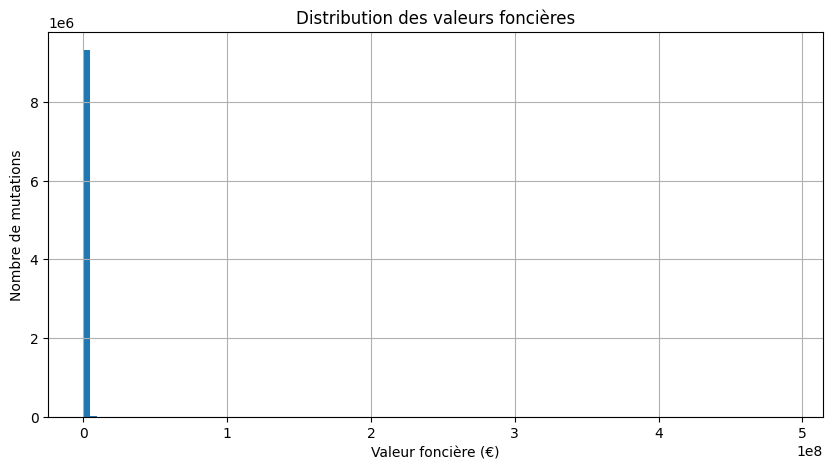

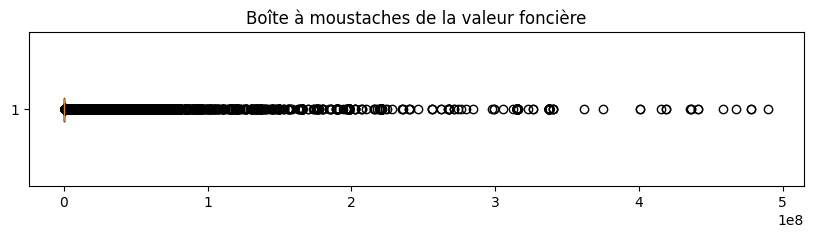

In [7]:
#%pip install matplotlib

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
df['valeur_fonciere'].hist(bins=100)
plt.title("Distribution des valeurs foncières")
plt.xlabel("Valeur foncière (€)")
plt.ylabel("Nombre de mutations")
plt.show()

plt.figure(figsize=(10,2))
plt.boxplot(df['valeur_fonciere'].dropna(), vert=False)
plt.title("Boîte à moustaches de la valeur foncière")
plt.show()


Ce code nous permet de voir la disperssion des valeurs de notre dataset. C'est très intéressant car nous pouvons voir que, logiquement, l'immense partie des transations effectuées sont dites 'faibles', et qu'il reste encore certaines valeurs énormes qui peuvent affecter notre future prediction.  
Nous pouvons donc alors aller plus loin dans notre travail de nettoyage en retirant encore plus de valeurs abérantes.

In [8]:
nb_valeurs_aberrantes = (df["valeur_fonciere"] > 2_000_000).sum()
print(f"Nombre de valeurs > 2 000 000 : {nb_valeurs_aberrantes}")

Nombre de valeurs > 2 000 000 : 66968


In [9]:
nv_seuil = 2_000_000

df_clean = df[df["valeur_fonciere"] <= nv_seuil]
print(f"Nombre de lignes après filtrage : {len(df_clean)}")

Nombre de lignes après filtrage : 9276179


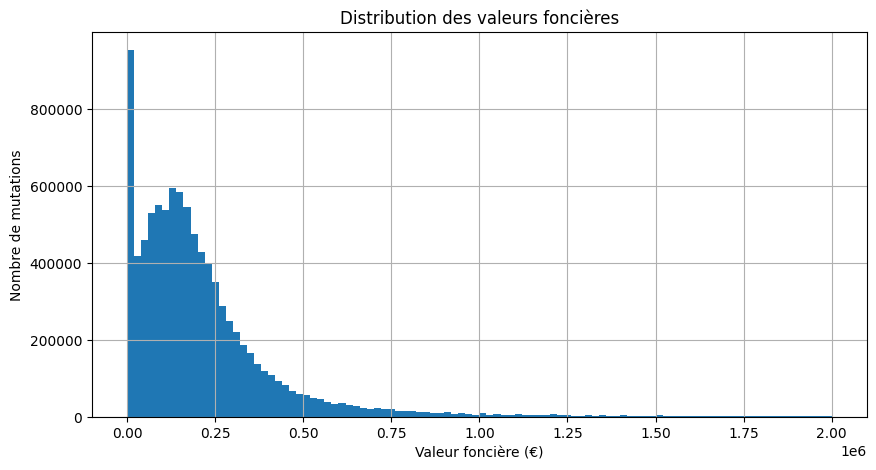

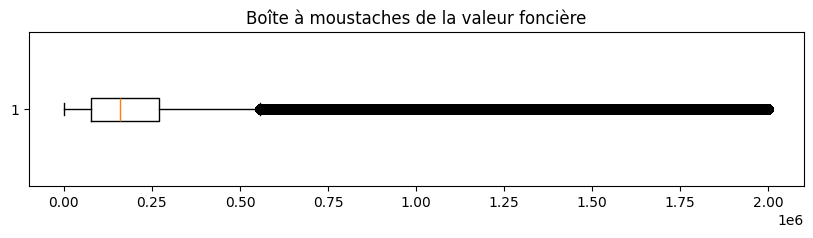

In [10]:
plt.figure(figsize=(10,5))
df_clean['valeur_fonciere'].hist(bins=100)
plt.title("Distribution des valeurs foncières")
plt.xlabel("Valeur foncière (€)")
plt.ylabel("Nombre de mutations")
plt.show()

plt.figure(figsize=(10,2))
plt.boxplot(df_clean['valeur_fonciere'].dropna(), vert=False)
plt.title("Boîte à moustaches de la valeur foncière")
plt.show()

Maintenant qu'on à supprimé les valeurs abérantes supérieures, il faut faire le même processur pour les valeurs faibles, car on peut voir sur le graphique qu'une écrasante majoritées des valeurs sont très basses.  
Nous allons donc commencer par regarder les valeurs inférieures à 10 000€. Nous avons choisis ce chiffre car une transaction immobilière inférieure à ce chiffre est probablement douteuse.  
Egalement, nous avons décidé de scinder le dataset en trois, pour pouvoir analyser différement les données car les ordres de grandeurs sont très différents, et toutes ces données sont intéressantes à analyser.

In [11]:
# Dataset 1 : transactions courantes
df_1 = df_clean[(df_clean['valeur_fonciere'] >= 10_000) & (df_clean['valeur_fonciere'] <= 470_000)]

# Dataset 2 : transactions semi élevées (ex: très grandes maisons)
df_2 = df_clean[(df_clean['valeur_fonciere'] >= 470_000) & (df_clean['valeur_fonciere'] <= 1_300_000)]

# Dataset 3 : transactions élevées (ex: biens d'exception)
df_3 = df_clean[(df_clean['valeur_fonciere'] >= 1_300_000) & (df_clean['valeur_fonciere'] <= 2_000_000)]

De cette manière, on peut a pu ajuster notre dataset global en le divisant en 3 "sous datasets", pour qu'on puisse les analyser dystinctements pour faire des prédictions sur chacun de ces derniers.

Distribution du DF_1 (valeurs communes):

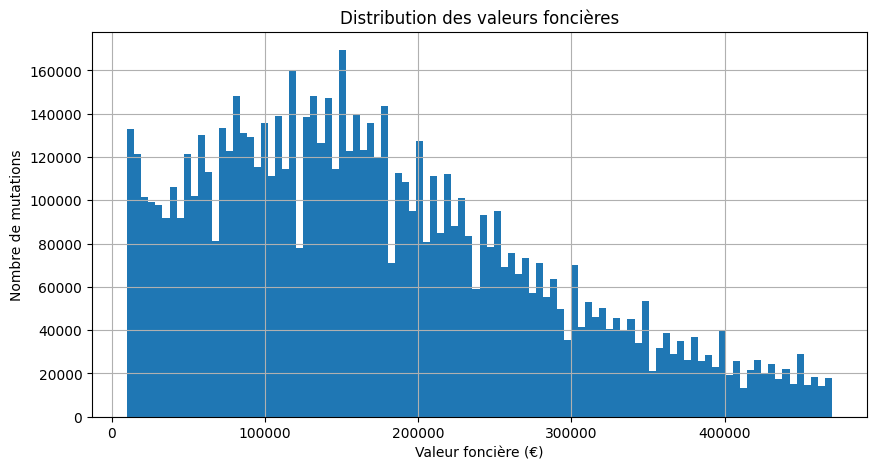

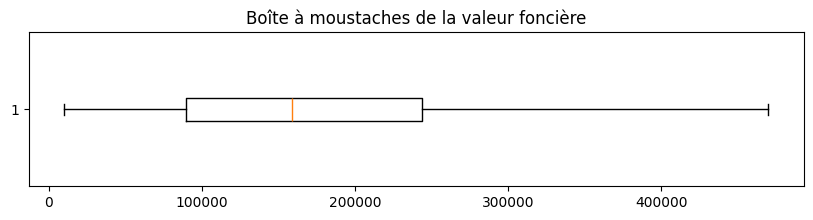

In [12]:
plt.figure(figsize=(10,5))
df_1['valeur_fonciere'].hist(bins=100)
plt.title("Distribution des valeurs foncières")
plt.xlabel("Valeur foncière (€)")
plt.ylabel("Nombre de mutations")
plt.show()

plt.figure(figsize=(10,2))
plt.boxplot(df_1['valeur_fonciere'].dropna(), vert=False)
plt.title("Boîte à moustaches de la valeur foncière")
plt.show()

Distribution du DF_2 (valeurs haut gamme):

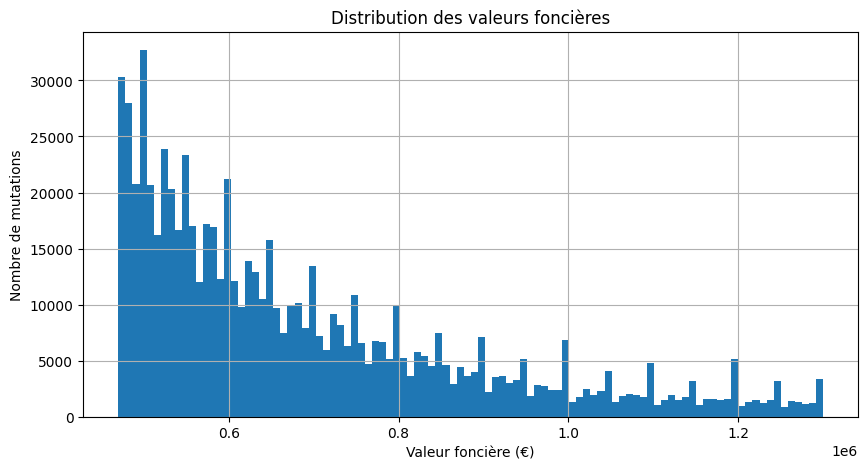

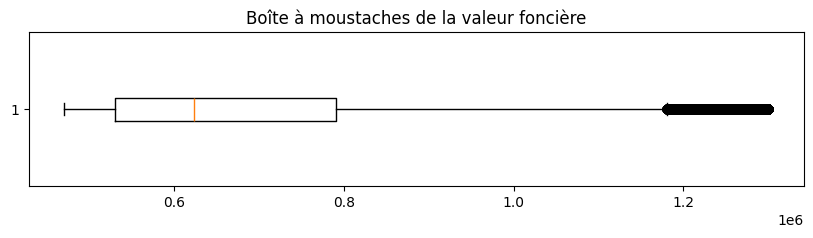

In [13]:
plt.figure(figsize=(10,5))
df_2['valeur_fonciere'].hist(bins=100)
plt.title("Distribution des valeurs foncières")
plt.xlabel("Valeur foncière (€)")
plt.ylabel("Nombre de mutations")
plt.show()

plt.figure(figsize=(10,2))
plt.boxplot(df_2['valeur_fonciere'].dropna(), vert=False)
plt.title("Boîte à moustaches de la valeur foncière")
plt.show()

Distribution du DF_3 (valeurs très haut gamme):

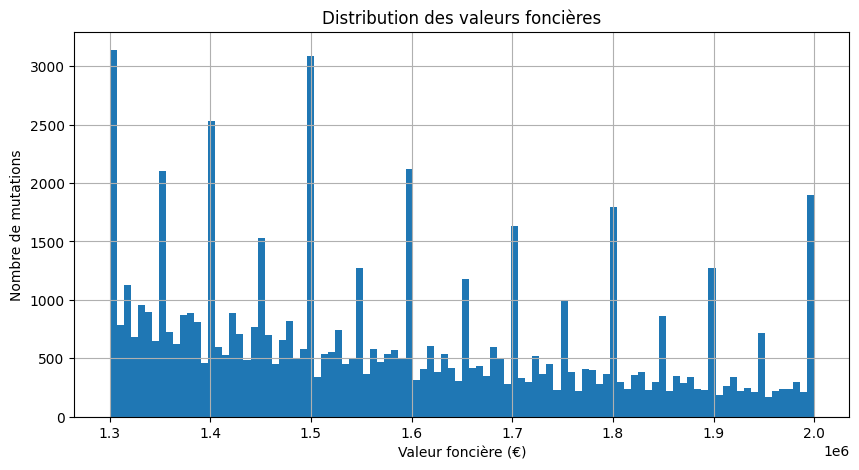

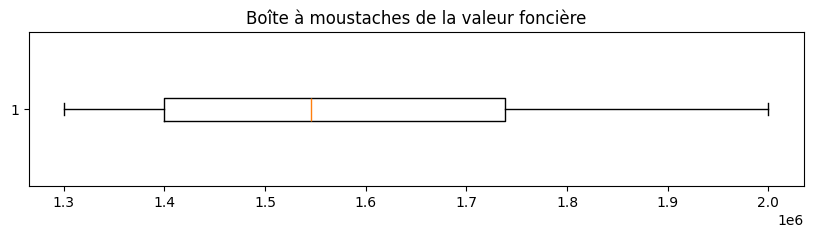

In [14]:
plt.figure(figsize=(10,5))
df_3['valeur_fonciere'].hist(bins=100)
plt.title("Distribution des valeurs foncières")
plt.xlabel("Valeur foncière (€)")
plt.ylabel("Nombre de mutations")
plt.show()

plt.figure(figsize=(10,2))
plt.boxplot(df_3['valeur_fonciere'].dropna(), vert=False)
plt.title("Boîte à moustaches de la valeur foncière")
plt.show()

On peut constater maintenant qu'il n'y a plus d'outliners pour les prix.  

Nous allons maintenant nous attaquer aux outliners au niveau des surfaces. Pour cela, pour allons utiliser une autre méthode : la règle de l'intervalle interquartile (IQR).  

Pour chaque dataframe, nous allons calculer chaque quartiles, ici sur la distribution des surfaces. Normalement, vu que nous avons déjà travaillé sur les prix, et séparé chaque tranche de prix dans des dataframes différents, les exès au niveau des surfaces devraient être des erreurs dans le jeu de données. C'est pourquoi nous pensons que cette méthode est la meilleur et la plus efficace pour ce cas.  

Ainsi, chaque dataframe aura ses valeurs de surfaces filtrées sur ses propres quartiles, ce qui va éliminer les surfaces anormalement petites ou grandes par rapport a la distribution générale de son dataframe.


In [15]:
def remove_surface_outliers_iqr(df, column='surface_reelle_bati'):
    # Calcul des quartiles sur la colonne 'surface_reelle_bati' de df
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Définition des bornes inférieure et supérieure pour considérer un outlier
    borne_inf = Q1 - 1.5 * IQR
    borne_sup = Q3 + 1.5 * IQR

    # On conserve ici uniquement les lignes dont la surface est dans [borne_inf, borne_sup]
    df_filtré = df[(df[column] >= borne_inf) & (df[column] <= borne_sup)].copy()
    return df_filtré

# 1) Nettoyage de df_1
df_1 = remove_surface_outliers_iqr(df_1, 'surface_reelle_bati')
print(f"df_1 : après = {df_1.shape[0]} lignes")

# 2) Nettoyage de df_2
df_2 = remove_surface_outliers_iqr(df_2, 'surface_reelle_bati')
print(f"df_2 : après = {df_2.shape[0]} lignes")

# 3) Nettoyage de df_3
df_3 = remove_surface_outliers_iqr(df_3, 'surface_reelle_bati')
print(f"df_3 : après = {df_3.shape[0]} lignes")


df_1 : après = 7696306 lignes
df_2 : après = 694820 lignes
df_3 : après = 60609 lignes


Nous avons ainsi retiré une petite partie des lignes, ce qui correspondait aux outliners. Nous allons maintenant afficher les données pour voir la répartition :

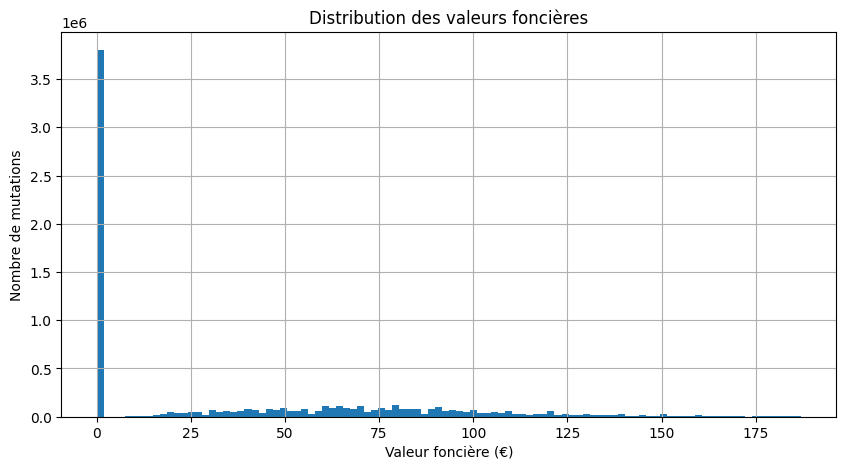

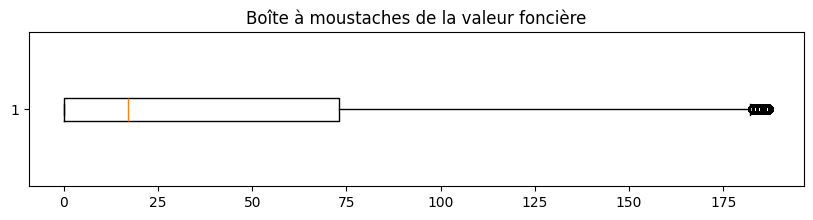

In [16]:
plt.figure(figsize=(10,5))
df_1['surface_reelle_bati'].hist(bins=100)
plt.title("Distribution des valeurs foncières")
plt.xlabel("Valeur foncière (€)")
plt.ylabel("Nombre de mutations")
plt.show()

plt.figure(figsize=(10,2))
plt.boxplot(df_1['surface_reelle_bati'].dropna(), vert=False)
plt.title("Boîte à moustaches de la valeur foncière")
plt.show()

On peut voir ici que c'est très mal réparti. On va essayer de retirer les valeurs nulles ou égales à 0.

In [ ]:
def count_zero_or_null_surface(df, column='surface_reelle_bati'):
    condition = df[column].isnull() | (df[column] == 0)
    return df[condition].shape[0]

# Exemple :
nb_zero_null_df2 = count_zero_or_null_surface(df_2)
nb_zero_null_df3 = count_zero_or_null_surface(df_3)
nb_zero_null_df1 = count_zero_or_null_surface(df_1)
print(f'Comptage de lignes nulles ou égales à 0 : \n')
print(f"Nombre de lignes dans df_1 avec surface nulle ou égale à 0 : {nb_zero_null_df1}")
print(f"Nombre de lignes dans df_2 avec surface nulle ou égale à 0 : {nb_zero_null_df2}")
print(f"Nombre de lignes dans df_3 avec surface nulle ou égale à 0 : {nb_zero_null_df3}")

Comptage de lignes nulles ou égales à 0 : 

Nombre de lignes dans df_1 avec surface nulle ou égale à 0 : 3799424
Nombre de lignes dans df_2 avec surface nulle ou égale à 0 : 318787
Nombre de lignes dans df_3 avec surface nulle ou égale à 0 : 30114


In [18]:
def drop_zero_or_null_surface(df, column='surface_reelle_bati'):
    # Condition True si surface est nulle ou égale à 0
    condition_to_drop = df[column].isnull() | (df[column] == 0)
    # On ne garde que les lignes qui ne remplissent PAS cette condition
    df_filtered = df[~condition_to_drop].copy()
    return df_filtered

print(f'Nettoyage des valeurs nulles ou égales à 0 pour chaque dataframes :')

# 1) Pour df_1
print(f"df_1 avant nettoyage : {df_1.shape[0]} lignes")
df_1_clean = drop_zero_or_null_surface(df_1, 'surface_reelle_bati')
print(f"df_1 après nettoyage : {df_1_clean.shape[0]} lignes (lignes supprimées = {df_1.shape[0] - df_1_clean.shape[0]})\n")
df_1 = df_1_clean

# 2) Pour df_2
print(f"df_2 avant nettoyage : {df_2.shape[0]} lignes")
df_2_clean = drop_zero_or_null_surface(df_2, 'surface_reelle_bati')
print(f"df_2 après nettoyage : {df_2_clean.shape[0]} lignes (lignes supprimées = {df_2.shape[0] - df_2_clean.shape[0]})\n")
df_2 = df_2_clean

# 3) Pour df_3
print(f"df_3 avant nettoyage : {df_3.shape[0]} lignes")
df_3_clean = drop_zero_or_null_surface(df_3, 'surface_reelle_bati')
print(f"df_3 après nettoyage : {df_3_clean.shape[0]} lignes (lignes supprimées = {df_3.shape[0] - df_3_clean.shape[0]})\n")
df_3 = df_3_clean


Nettoyage des valeurs nulles ou égales à 0 pour chaque dataframes :
df_1 avant nettoyage : 7696306 lignes
df_1 après nettoyage : 3896882 lignes (lignes supprimées = 3799424)

df_2 avant nettoyage : 694820 lignes
df_2 après nettoyage : 376033 lignes (lignes supprimées = 318787)

df_3 avant nettoyage : 60609 lignes
df_3 après nettoyage : 30495 lignes (lignes supprimées = 30114)



Les trois jeux de données sont donc maintenant propre, réalistes et prêts pour la création de différents modèles d'analyse.

Nous allons procéder à une analyse comparative complète, de la statistique descriptive à la visualisation géographique, pour révéler les différences clés entre trois segments de prix immobiliers.  

Nous allons donc explorer les différences de structure, de distribution des prix, de comportement selon la surface, d’évolution dans le temps et de répartition géographique entre ces trois catégories de biens.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("=== ÉTAPE 2 : ANALYSE COMPARATIVE DES TROIS SEGMENTS ===\n")

# Configuration
plt.style.use('seaborn-v0_8')
fig_size = (15, 10)

def compare_segments(df_1, df_2, df_3,
                     segment1_name="Standard (10k-500k)",
                     segment2_name="Haut gamme (500k-1.3M)",
                     segment3_name="Ultra (1.3M-2M)"):
    
    print("1. COMPARAISON DES STATISTIQUES GÉNÉRALES")
    print("="*60)
    
    # Statistiques de base pour chaque segment
    stats_comparison = pd.DataFrame({
        segment1_name: [
            df_1.shape[0],
            df_1['valeur_fonciere'].mean(),
            df_1['valeur_fonciere'].median(),
            df_1['valeur_fonciere'].std(),
            df_1['surface_reelle_bati'].mean() if 'surface_reelle_bati' in df_1.columns else np.nan
        ],
        segment2_name: [
            df_2.shape[0],
            df_2['valeur_fonciere'].mean(),
            df_2['valeur_fonciere'].median(),
            df_2['valeur_fonciere'].std(),
            df_2['surface_reelle_bati'].mean() if 'surface_reelle_bati' in df_2.columns else np.nan
        ],
        segment3_name: [
            df_3.shape[0],
            df_3['valeur_fonciere'].mean(),
            df_3['valeur_fonciere'].median(),
            df_3['valeur_fonciere'].std(),
            df_3['surface_reelle_bati'].mean() if 'surface_reelle_bati' in df_3.columns else np.nan
        ]
    }, index=[
        'Nombre de transactions',
        'Prix moyen (€)',
        'Prix médian (€)',
        'Écart-type prix',
        'Surface moyenne (m²)'
    ])
    
    print(stats_comparison.round(0))
    return stats_comparison

def plot_price_distributions(df_1, df_2, df_3,
                             segment1_name="Standard (10k-500k)",
                             segment2_name="Haut gamme (500k-1.3M)",
                             segment3_name="Ultra (1.3M-2M)"):
    print("\n2. DISTRIBUTIONS DES PRIX")
    print("="*30)
    
    # Création d'une grille 3x2 pour accueillir trois histogrammes, un boxplot et une distribution log-normale
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    
    # Histogramme segment 1
    axes[0, 0].hist(df_1['valeur_fonciere'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title(f'Distribution - {segment1_name}')
    axes[0, 0].set_xlabel('Valeur foncière (€)')
    axes[0, 0].set_ylabel('Fréquence')
    axes[0, 0].ticklabel_format(style='plain', axis='x')
    
    # Histogramme segment 2
    axes[0, 1].hist(df_2['valeur_fonciere'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 1].set_title(f'Distribution - {segment2_name}')
    axes[0, 1].set_xlabel('Valeur foncière (€)')
    axes[0, 1].set_ylabel('Fréquence')
    axes[0, 1].ticklabel_format(style='plain', axis='x')
    
    # Histogramme segment 3
    axes[1, 0].hist(df_3['valeur_fonciere'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1, 0].set_title(f'Distribution - {segment3_name}')
    axes[1, 0].set_xlabel('Valeur foncière (€)')
    axes[1, 0].set_ylabel('Fréquence')
    axes[1, 0].ticklabel_format(style='plain', axis='x')
    
    # Boxplot comparatif des trois segments
    data_combined = [
        df_1['valeur_fonciere'],
        df_2['valeur_fonciere'],
        df_3['valeur_fonciere']
    ]
    axes[1, 1].boxplot(data_combined, labels=[segment1_name, segment2_name, segment3_name])
    axes[1, 1].set_title('Comparaison Box Plots')
    axes[1, 1].set_ylabel('Valeur foncière (€)')
    axes[1, 1].ticklabel_format(style='plain', axis='y')
    
    # Distributions log-normales des trois segments
    axes[2, 0].hist(np.log(df_1['valeur_fonciere']), bins=50, alpha=0.5, label=segment1_name, color='skyblue')
    axes[2, 0].hist(np.log(df_2['valeur_fonciere']), bins=50, alpha=0.5, label=segment2_name, color='lightcoral')
    axes[2, 0].hist(np.log(df_3['valeur_fonciere']), bins=50, alpha=0.5, label=segment3_name, color='lightgreen')
    axes[2, 0].set_title('Distributions Log-normales')
    axes[2, 0].set_xlabel('Log(Valeur foncière)')
    axes[2, 0].set_ylabel('Fréquence')
    axes[2, 0].legend()
    
    # On masque l'axe restant (inutile)
    axes[2, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

def analyze_surface_price_relationship(df_1, df_2, df_3,
                                       segment1_name="Standard (10k-500k)",
                                       segment2_name="Haut gamme (500k-1.3M)",
                                       segment3_name="Ultra (1.3M-2M)"):
    print("\n3. RELATION SURFACE/PRIX PAR SEGMENT")
    print("="*45)
    
    # Vérifier la présence de la colonne 'surface_reelle_bati'
    if 'surface_reelle_bati' in df_1.columns and 'surface_reelle_bati' in df_2.columns and 'surface_reelle_bati' in df_3.columns:
        # Garder seulement les lignes où la surface est > 0
        df_1_clean = df_1[df_1['surface_reelle_bati'] > 0].copy()
        df_2_clean = df_2[df_2['surface_reelle_bati'] > 0].copy()
        df_3_clean = df_3[df_3['surface_reelle_bati'] > 0].copy()
        
        # Calcul du prix au m² (optionnel mais utile pour info)
        df_1_clean['prix_m2'] = df_1_clean['valeur_fonciere'] / df_1_clean['surface_reelle_bati']
        df_2_clean['prix_m2'] = df_2_clean['valeur_fonciere'] / df_2_clean['surface_reelle_bati']
        df_3_clean['prix_m2'] = df_3_clean['valeur_fonciere'] / df_3_clean['surface_reelle_bati']
        
        # Affichage des prix moyens au m²
        print(f"Prix au m² moyen - {segment1_name} : {df_1_clean['prix_m2'].mean():.0f} €/m²")
        print(f"Prix au m² moyen - {segment2_name} : {df_2_clean['prix_m2'].mean():.0f} €/m²")
        print(f"Prix au m² moyen - {segment3_name} : {df_3_clean['prix_m2'].mean():.0f} €/m²")
        
        # Préparation de la figure avec 3 sous‐graphiques côte à côte
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Échantillonnage pour la clarté (limité à 30 000 points, ou moins si le df est plus petit)
        sample_size_1 = min(30000, len(df_1_clean))
        sample_size_2 = min(30000, len(df_2_clean))
        sample_size_3 = min(30000, len(df_3_clean))
        
        df_1_sample = df_1_clean.sample(n=sample_size_1, random_state=42)
        df_2_sample = df_2_clean.sample(n=sample_size_2, random_state=42)
        df_3_sample = df_3_clean.sample(n=sample_size_3, random_state=42)
        
        # --------------------------------------------------
        # 1) Segment 1 : nuage + droite de régression simple
        # --------------------------------------------------
        x1 = df_1_sample['surface_reelle_bati'].values
        y1 = df_1_sample['valeur_fonciere'].values
        
        # Nuage de points
        axes[0].scatter(x1, y1, alpha=0.5, s=1, color='skyblue')
        axes[0].set_title(f'Relation Surface/Prix - {segment1_name}')
        axes[0].set_xlabel('Surface (m²)')
        axes[0].set_ylabel('Valeur foncière (€)')
        
        # Calcul des coefficients de la droite de régression (ordre 1)
        coef1 = np.polyfit(x1, y1, deg=1)        # coef1[0] = pente, coef1[1] = ordonnée à l'origine
        pente1, intercept1 = coef1[0], coef1[1]
        
        # Tracé de la droite : on crée deux points extrêmes sur l'axe des surfaces pour dessiner la ligne
        x1_min, x1_max = x1.min(), x1.max()
        y1_min_line = pente1 * x1_min + intercept1
        y1_max_line = pente1 * x1_max + intercept1
        axes[0].plot([x1_min, x1_max], [y1_min_line, y1_max_line],
                     color='darkblue', linewidth=2, label='Régression linéaire')
        axes[0].legend()
        
        # --------------------------------------------------
        # 2) Segment 2 : nuage + droite de régression simple
        # --------------------------------------------------
        x2 = df_2_sample['surface_reelle_bati'].values
        y2 = df_2_sample['valeur_fonciere'].values
        
        axes[1].scatter(x2, y2, alpha=0.5, s=1, color='lightcoral')
        axes[1].set_title(f'Relation Surface/Prix - {segment2_name}')
        axes[1].set_xlabel('Surface (m²)')
        axes[1].set_ylabel('Valeur foncière (€)')
        
        coef2 = np.polyfit(x2, y2, deg=1)
        pente2, intercept2 = coef2[0], coef2[1]
        
        x2_min, x2_max = x2.min(), x2.max()
        y2_min_line = pente2 * x2_min + intercept2
        y2_max_line = pente2 * x2_max + intercept2
        axes[1].plot([x2_min, x2_max], [y2_min_line, y2_max_line],
                     color='darkred', linewidth=2, label='Régression linéaire')
        axes[1].legend()
        
        # --------------------------------------------------
        # 3) Segment 3 : nuage + droite de régression simple
        # --------------------------------------------------
        x3 = df_3_sample['surface_reelle_bati'].values
        y3 = df_3_sample['valeur_fonciere'].values
        
        axes[2].scatter(x3, y3, alpha=0.5, s=1, color='lightgreen')
        axes[2].set_title(f'Relation Surface/Prix - {segment3_name}')
        axes[2].set_xlabel('Surface (m²)')
        axes[2].set_ylabel('Valeur foncière (€)')
        
        coef3 = np.polyfit(x3, y3, deg=1)
        pente3, intercept3 = coef3[0], coef3[1]
        
        x3_min, x3_max = x3.min(), x3.max()
        y3_min_line = pente3 * x3_min + intercept3
        y3_max_line = pente3 * x3_max + intercept3
        axes[2].plot([x3_min, x3_max], [y3_min_line, y3_max_line],
                     color='darkgreen', linewidth=2, label='Régression linéaire')
        axes[2].legend()
        
        plt.tight_layout()
        plt.show()
        
        return df_1_clean, df_2_clean, df_3_clean
    
    else:
        print("Colonne 'surface_reelle_bati' non trouvée dans l'un des dataframes")
        return df_1, df_2, df_3


def analyze_temporal_patterns(df_1, df_2, df_3,
                              segment1_name="Standard (10k-500k)",
                              segment2_name="Haut gamme (500k-1.3M)",
                              segment3_name="Ultra (1.3M-2M)"):
    """
    Analyse des patterns temporels pour les trois segments
    """
    print("\n4. ANALYSE TEMPORELLE")
    print("="*30)
    
    # Vérifier la présence de la colonne 'date_mutation'
    if 'date_mutation' in df_1.columns and 'date_mutation' in df_2.columns and 'date_mutation' in df_3.columns:
        # Conversion des dates
        df_1['date_mutation'] = pd.to_datetime(df_1['date_mutation'])
        df_2['date_mutation'] = pd.to_datetime(df_2['date_mutation'])
        df_3['date_mutation'] = pd.to_datetime(df_3['date_mutation'])
        
        # Extraction des composantes temporelles
        for df in [df_1, df_2, df_3]:
            df['annee'] = df['date_mutation'].dt.year
            df['mois'] = df['date_mutation'].dt.month
        
        # Evolution annuelle des prix moyens
        prix_annuel_1 = df_1.groupby('annee')['valeur_fonciere'].mean()
        prix_annuel_2 = df_2.groupby('annee')['valeur_fonciere'].mean()
        prix_annuel_3 = df_3.groupby('annee')['valeur_fonciere'].mean()
        
        plt.figure(figsize=(12, 6))
        plt.plot(prix_annuel_1.index, prix_annuel_1.values, marker='o', label=segment1_name, linewidth=2)
        plt.plot(prix_annuel_2.index, prix_annuel_2.values, marker='s', label=segment2_name, linewidth=2)
        plt.plot(prix_annuel_3.index, prix_annuel_3.values, marker='^', label=segment3_name, linewidth=2)
        plt.title('Évolution du prix moyen par année')
        plt.xlabel('Année')
        plt.ylabel('Prix moyen (€)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ticklabel_format(style='plain', axis='y')
        plt.show()
        
        # Saisonnalité mensuelle des prix
        prix_mensuel_1 = df_1.groupby('mois')['valeur_fonciere'].mean()
        prix_mensuel_2 = df_2.groupby('mois')['valeur_fonciere'].mean()
        prix_mensuel_3 = df_3.groupby('mois')['valeur_fonciere'].mean()
        
        plt.figure(figsize=(12, 6))
        plt.plot(prix_mensuel_1.index, prix_mensuel_1.values, marker='o', label=segment1_name, linewidth=2)
        plt.plot(prix_mensuel_2.index, prix_mensuel_2.values, marker='s', label=segment2_name, linewidth=2)
        plt.plot(prix_mensuel_3.index, prix_mensuel_3.values, marker='^', label=segment3_name, linewidth=2)
        plt.title('Saisonnalité des prix (par mois)')
        plt.xlabel('Mois')
        plt.ylabel('Prix moyen (€)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(range(1, 13))
        plt.ticklabel_format(style='plain', axis='y')
        plt.show()
        
    else:
        print("Colonne 'date_mutation' non trouvée dans l'un des dataframes")

def extract_departement_from_postal_code(code_postal):
    code_str = str(code_postal).zfill(5)  # Remplit avec des zéros si nécessaire
    if len(code_str) == 4:  
        return code_str[:2].zfill(2)
    elif len(code_str) == 5:
        return code_str[:2]
    else:
        return None

def analyze_geographic_patterns(df_1, df_2, df_3):
    print("\n5. ANALYSE GÉOGRAPHIQUE PAR DÉPARTEMENT")
    print("=" * 45)
    
    # 1) Vérifier la présence de la colonne 'code_postal' et 'valeur_fonciere' dans chacun
    for col in ['code_postal', 'valeur_fonciere']:
        if col not in df_1.columns or col not in df_2.columns or col not in df_3.columns:
            print(f"Erreur : la colonne '{col}' est manquante dans au moins un des DataFrames.")
            return df_1, df_2, df_3, None, None, None
    
    # 2) Créer des copies pour ne pas modifier les originaux et extraire 'departement'
    def add_departement_col(df):
        temp = df.copy()
        temp['code_postal'] = temp['code_postal'].astype(str).str.zfill(5)
        temp['departement'] = temp['code_postal'].str[:2]
        return temp

    df1_geo = add_departement_col(df_1)
    df2_geo = add_departement_col(df_2)
    df3_geo = add_departement_col(df_3)
    
    df1_geo = df1_geo.dropna(subset=['departement'])
    df2_geo = df2_geo.dropna(subset=['departement'])
    df3_geo = df3_geo.dropna(subset=['departement'])
    
    print(f"✓ Départements identifiés - Segment standard   : {df1_geo['departement'].nunique()}")
    print(f"✓ Départements identifiés - Segment haut gamme : {df2_geo['departement'].nunique()}")
    print(f"✓ Départements identifiés - Segment ultra      : {df3_geo['departement'].nunique()}")
    
    # 3) Calculer les statistiques par département pour chaque segment
    def compute_dept_stats(df_geo):
        agg = df_geo.groupby('departement').agg(
            valeur_fonciere_count=('valeur_fonciere', 'count'),
            valeur_fonciere_mean=('valeur_fonciere', 'mean'),
            valeur_fonciere_median=('valeur_fonciere', 'median'),
            valeur_fonciere_std=('valeur_fonciere', 'std')
        )
        # Ajouter stats de surface si disponible
        if 'surface_reelle_bati' in df_geo.columns:
            agg['surface_reelle_bati_mean'] = df_geo.groupby('departement')['surface_reelle_bati'].mean()
            agg['surface_reelle_bati_median'] = df_geo.groupby('departement')['surface_reelle_bati'].median()
        return agg.round(0).sort_values('valeur_fonciere_count', ascending=False)

    dept_stats_1 = compute_dept_stats(df1_geo)
    dept_stats_2 = compute_dept_stats(df2_geo)
    dept_stats_3 = compute_dept_stats(df3_geo)
    
    # 4) Afficher les Top 10 départements pour chaque segment (par nombre de transactions)
    print("\nTOP 10 DÉPARTEMENTS - SEGMENT STANDARD (10k-500k €)")
    print("-" * 60)
    print(dept_stats_1.head(10))
    
    print("\nTOP 10 DÉPARTEMENTS - SEGMENT HAUT GAMME (500k-1.3M €)")
    print("-" * 60)
    print(dept_stats_2.head(10))
    
    print("\nTOP 10 DÉPARTEMENTS - SEGMENT ULTRA (1.3M-2M €)")
    print("-" * 60)
    print(dept_stats_3.head(10))
    
    # 5) Visualisations Matplotlib
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Top 15 par segment : nombre de transactions
    top15_1 = dept_stats_1.head(15)
    top15_2 = dept_stats_2.head(15)
    top15_3 = dept_stats_3.head(15)
    top15_mean_1 = dept_stats_1.sort_values('valeur_fonciere_mean', ascending=False).head(15)
    top15_mean_2 = dept_stats_2.sort_values('valeur_fonciere_mean', ascending=False).head(15)
    top15_mean_3 = dept_stats_3.sort_values('valeur_fonciere_mean', ascending=False).head(15)
    
    # 5.1) Nombre de transactions - Segment 1
    axes[0, 0].bar(top15_1.index, top15_1['valeur_fonciere_count'], color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Top 15 Départements\nNb transactions - Standard')
    axes[0, 0].set_xlabel('Département')
    axes[0, 0].set_ylabel('Nb transactions')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 5.2) Nombre de transactions - Segment 2
    axes[0, 1].bar(top15_2.index, top15_2['valeur_fonciere_count'], color='lightcoral', alpha=0.7)
    axes[0, 1].set_title('Top 15 Départements\nNb transactions - Haut gamme')
    axes[0, 1].set_xlabel('Département')
    axes[0, 1].set_ylabel('Nb transactions')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 5.3) Nombre de transactions - Segment 3
    axes[0, 2].bar(top15_3.index, top15_3['valeur_fonciere_count'], color='lightgreen', alpha=0.7)
    axes[0, 2].set_title('Top 15 Départements\nNb transactions - Ultra')
    axes[0, 2].set_xlabel('Département')
    axes[0, 2].set_ylabel('Nb transactions')
    axes[0, 2].tick_params(axis='x', rotation=45)
    
    # Top 15 par segment : prix moyen
    # 5.4) Prix moyen - Segment 1 (trié décroissant)
    axes[1, 0].bar(top15_mean_1.index, top15_mean_1['valeur_fonciere_mean'], 
                color='gold', alpha=0.7)
    axes[1, 0].set_title('Top 15 Départements\nPrix moyen (€) - Standard (trié décroissant)')
    axes[1, 0].set_xlabel('Département')
    axes[1, 0].set_ylabel('Prix moyen (€)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].ticklabel_format(style='plain', axis='y')

    # 5.5) Prix moyen - Segment 2 (trié décroissant)
    axes[1, 1].bar(top15_mean_2.index, top15_mean_2['valeur_fonciere_mean'], 
                color='purple', alpha=0.7)
    axes[1, 1].set_title('Top 15 Départements\nPrix moyen (€) - Haut gamme (trié décroissant)')
    axes[1, 1].set_xlabel('Département')
    axes[1, 1].set_ylabel('Prix moyen (€)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].ticklabel_format(style='plain', axis='y')

    # 5.6) Prix moyen - Segment 3 (trié décroissant)
    axes[1, 2].bar(top15_mean_3.index, top15_mean_3['valeur_fonciere_mean'], 
                color='darkgreen', alpha=0.7)
    axes[1, 2].set_title('Top 15 Départements\nPrix moyen (€) - Ultra (trié décroissant)')
    axes[1, 2].set_xlabel('Département')
    axes[1, 2].set_ylabel('Prix moyen (€)')
    axes[1, 2].tick_params(axis='x', rotation=45)
    axes[1, 2].ticklabel_format(style='plain', axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # 6) Départements communs aux trois segments et comparaison des prix moyens
    depts_communs_123 = (
        set(df1_geo['departement'].unique()) &
        set(df2_geo['departement'].unique()) &
        set(df3_geo['departement'].unique())
    )
    print(f"\nDÉPARTEMENTS COMMUNS AUX TROIS SEGMENTS : {len(depts_communs_123)}")
    print(f"Départements communs : {sorted(depts_communs_123)}")
    
    if depts_communs_123:
        # Pour lisibilité, on ne prend que les 10 premiers départements communs
        depts_afficher = sorted(list(depts_communs_123))[:10]
        
        comparison_data = []
        for dept in depts_afficher:
            prix_std   = dept_stats_1.loc[dept, 'valeur_fonciere_mean'] if dept in dept_stats_1.index else 0
            prix_hg    = dept_stats_2.loc[dept, 'valeur_fonciere_mean'] if dept in dept_stats_2.index else 0
            prix_ultra = dept_stats_3.loc[dept, 'valeur_fonciere_mean'] if dept in dept_stats_3.index else 0
            comparison_data.append({
                'departement': dept,
                'prix_standard': prix_std,
                'prix_haut_gamme': prix_hg,
                'prix_ultra': prix_ultra
            })
        
        comp_df = pd.DataFrame(comparison_data)
        comp_df = comp_df.set_index('departement')
        
        print("\nCOMPARAISON PRIX MOYENS - DÉPARTEMENTS COMMUNS (10 PREMIERS)")
        print("-" * 70)
        print(comp_df)
        
        # Graphique de comparaison pour les départements communs
        plt.figure(figsize=(14, 8))
        x = np.arange(len(comp_df.index))
        width = 0.25
        
        plt.bar(x - width, comp_df['prix_standard'],  width, label='Standard',   color='skyblue', alpha=0.7)
        plt.bar(x,         comp_df['prix_haut_gamme'], width, label='Haut gamme', color='lightcoral', alpha=0.7)
        plt.bar(x + width, comp_df['prix_ultra'],     width, label='Ultra',      color='lightgreen', alpha=0.7)
        
        plt.xlabel('Département')
        plt.ylabel('Prix moyen (€)')
        plt.title('Comparaison des prix moyens par département (communs)')
        plt.xticks(x, comp_df.index, rotation=45)
        plt.legend()
        plt.ticklabel_format(style='plain', axis='y')
        plt.tight_layout()
        plt.show()
    
    # 7) Statistiques géographiques globales
    print(f"\nRÉSUMÉ GÉOGRAPHIQUE")
    print("-" * 30)
    print("Segment Standard :")
    print(f"  - Départements couverts       : {df1_geo['departement'].nunique()}")
    print(f"  - Prix moyen national         : {df1_geo['valeur_fonciere'].mean():.0f} €")
    print(f"  - Département le plus cher    : {dept_stats_1['valeur_fonciere_mean'].idxmax()} ({dept_stats_1['valeur_fonciere_mean'].max():.0f} €)")
    print(f"  - Département le moins cher   : {dept_stats_1['valeur_fonciere_mean'].idxmin()} ({dept_stats_1['valeur_fonciere_mean'].min():.0f} €)")
    
    print("\nSegment Haut gamme :")
    print(f"  - Départements couverts       : {df2_geo['departement'].nunique()}")
    print(f"  - Prix moyen national         : {df2_geo['valeur_fonciere'].mean():.0f} €")
    print(f"  - Département le plus cher    : {dept_stats_2['valeur_fonciere_mean'].idxmax()} ({dept_stats_2['valeur_fonciere_mean'].max():.0f} €)")
    print(f"  - Département le moins cher   : {dept_stats_2['valeur_fonciere_mean'].idxmin()} ({dept_stats_2['valeur_fonciere_mean'].min():.0f} €)")
    
    print("\nSegment Ultra :")
    print(f"  - Départements couverts       : {df3_geo['departement'].nunique()}")
    print(f"  - Prix moyen national         : {df3_geo['valeur_fonciere'].mean():.0f} €")
    print(f"  - Département le plus cher    : {dept_stats_3['valeur_fonciere_mean'].idxmax()} ({dept_stats_3['valeur_fonciere_mean'].max():.0f} €)")
    print(f"  - Département le moins cher   : {dept_stats_3['valeur_fonciere_mean'].idxmin()} ({dept_stats_3['valeur_fonciere_mean'].min():.0f} €)")
    
    return df1_geo, df2_geo, df3_geo, dept_stats_1, dept_stats_2, dept_stats_3



=== ÉTAPE 2 : ANALYSE COMPARATIVE DES TROIS SEGMENTS ===



Lancement de l'analyse comparative sur trois segments...
1. COMPARAISON DES STATISTIQUES GÉNÉRALES
                        Standard (10k-500k)  Haut gamme (500k-1.3M)  \
Nombre de transactions            3896882.0                376033.0   
Prix moyen (€)                     185470.0                681279.0   
Prix médian (€)                    167648.0                618000.0   
Écart-type prix                    103852.0                197399.0   
Surface moyenne (m²)                   75.0                   111.0   

                        Ultra (1.3M-2M)  
Nombre de transactions          30495.0  
Prix moyen (€)                1574360.0  
Prix médian (€)               1535000.0  
Écart-type prix                201615.0  
Surface moyenne (m²)              134.0  

2. DISTRIBUTIONS DES PRIX


C:\Users\bonni\AppData\Local\Temp\ipykernel_21788\531409676.py:100: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(data_combined, labels=[segment1_name, segment2_name, segment3_name])


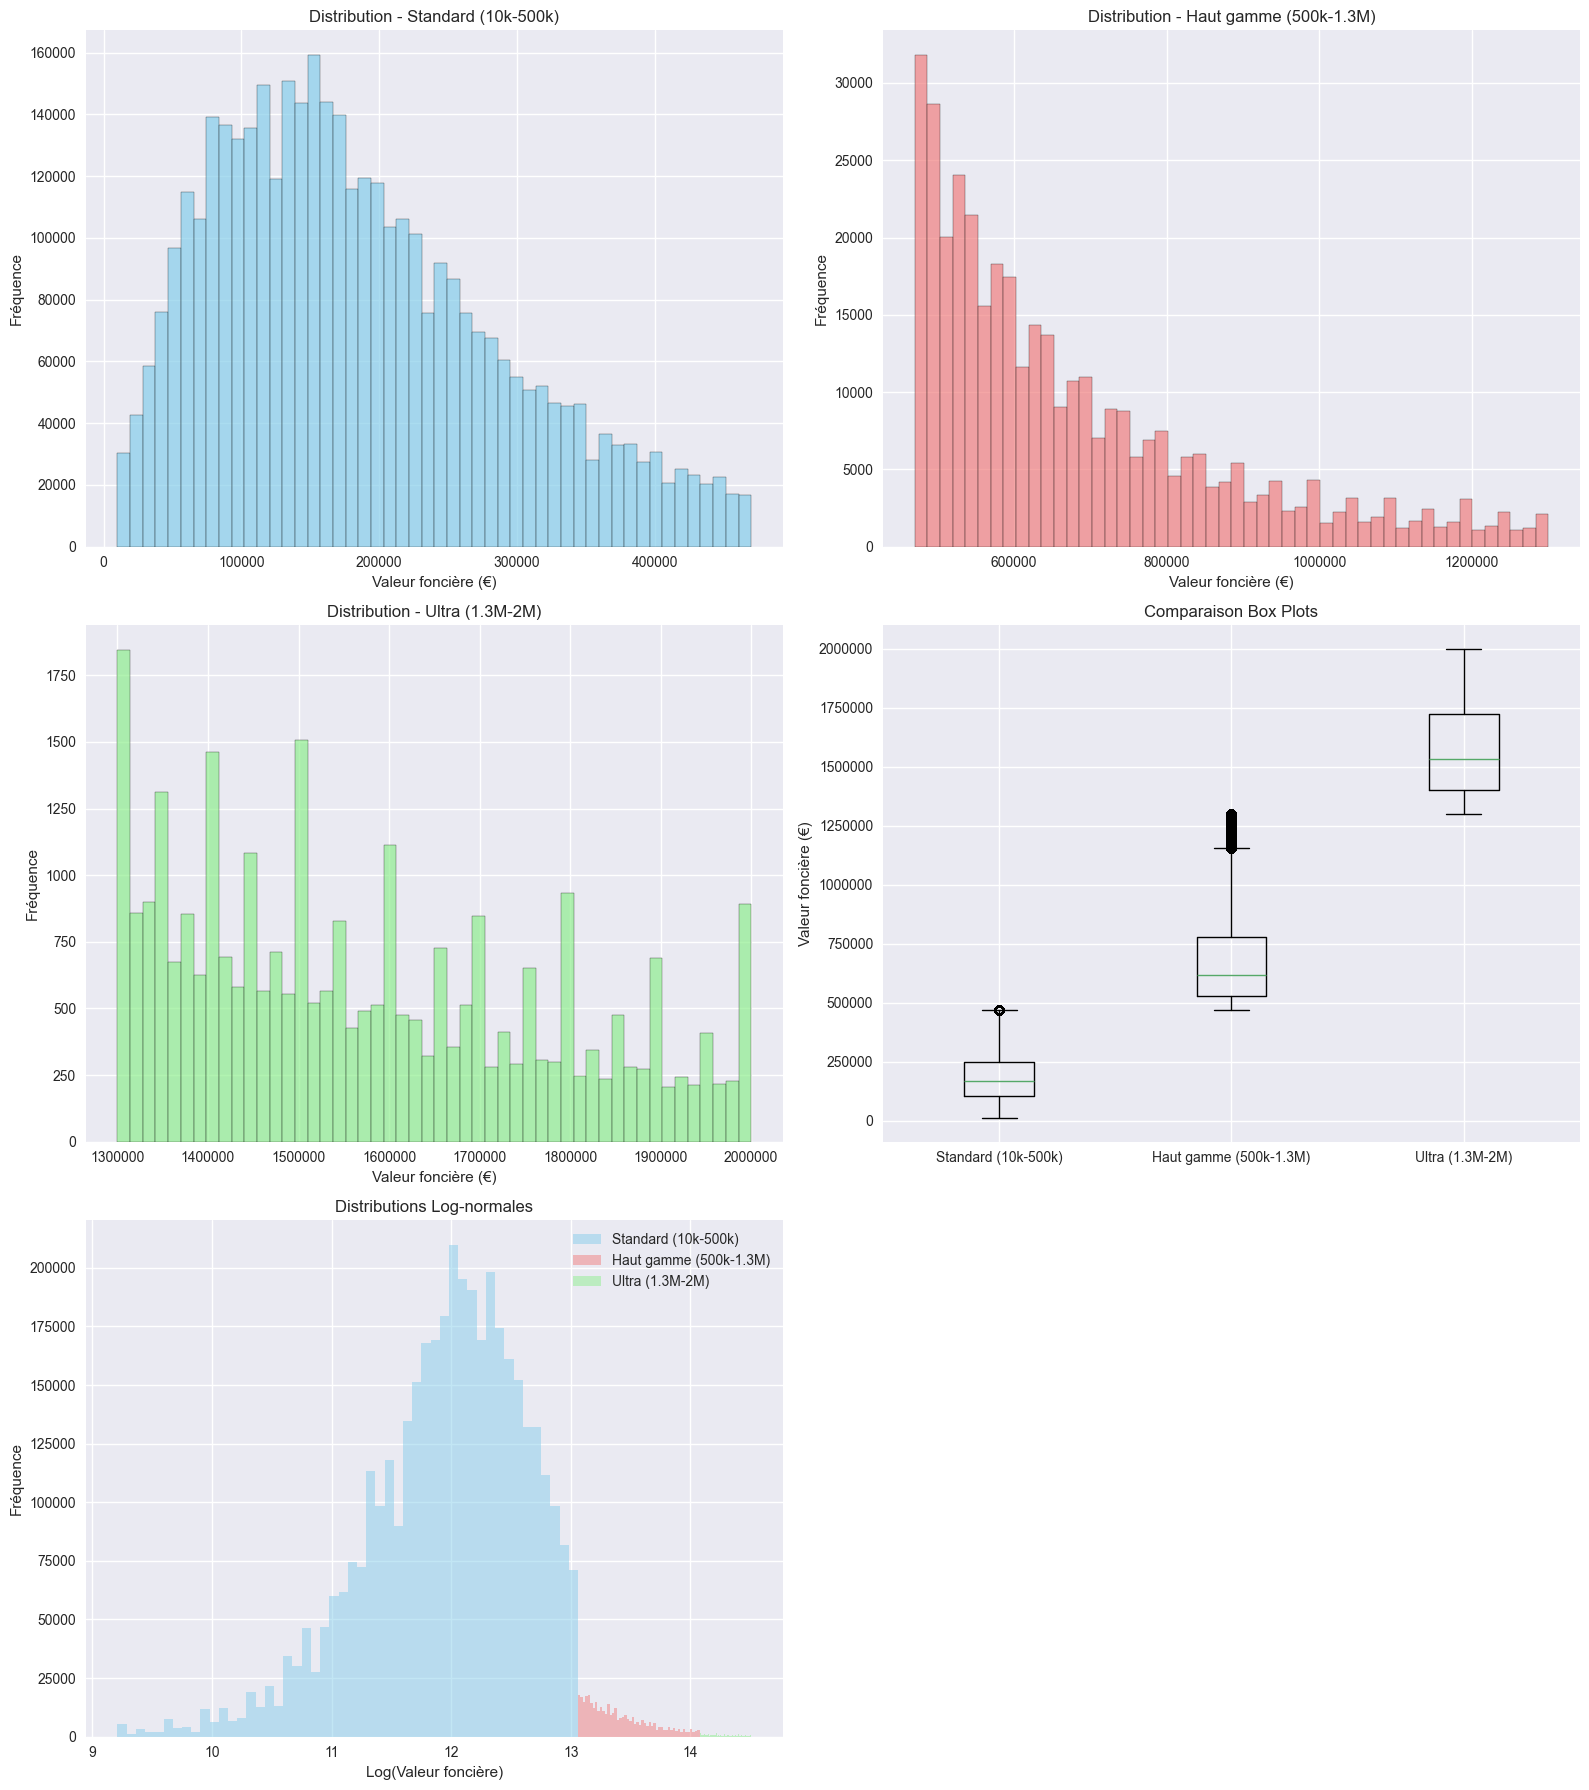


3. RELATION SURFACE/PRIX PAR SEGMENT
Prix au m² moyen - Standard (10k-500k) : 2975 €/m²
Prix au m² moyen - Haut gamme (500k-1.3M) : 8559 €/m²
Prix au m² moyen - Ultra (1.3M-2M) : 19260 €/m²


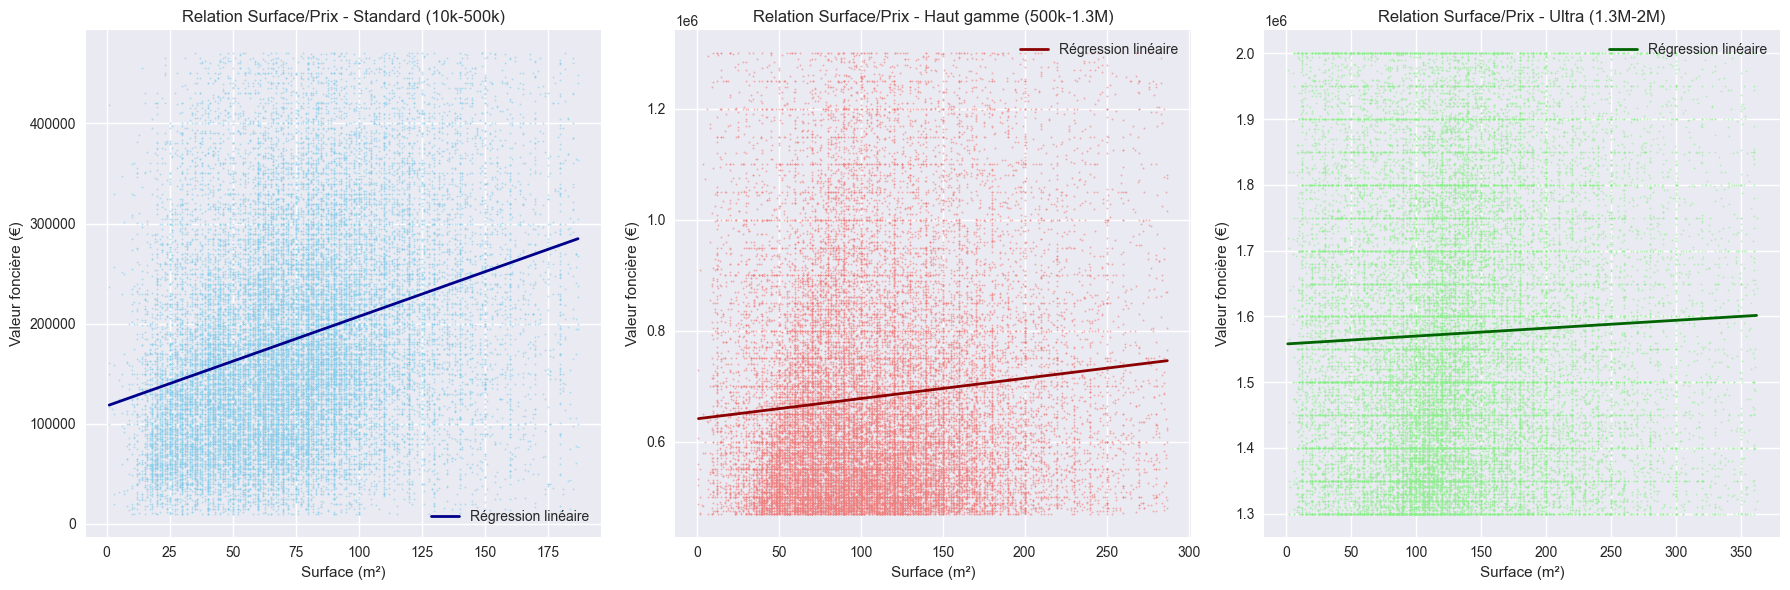


4. ANALYSE TEMPORELLE


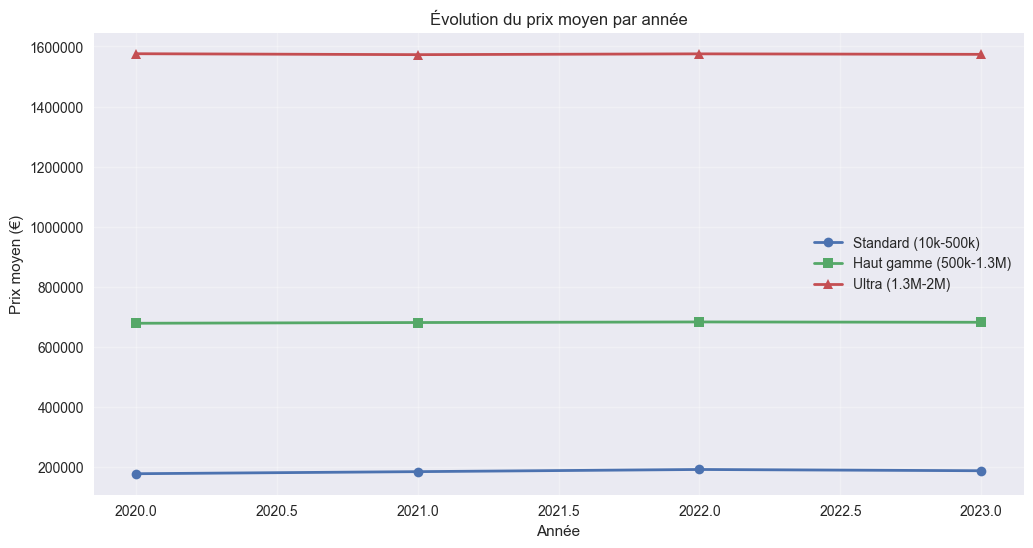

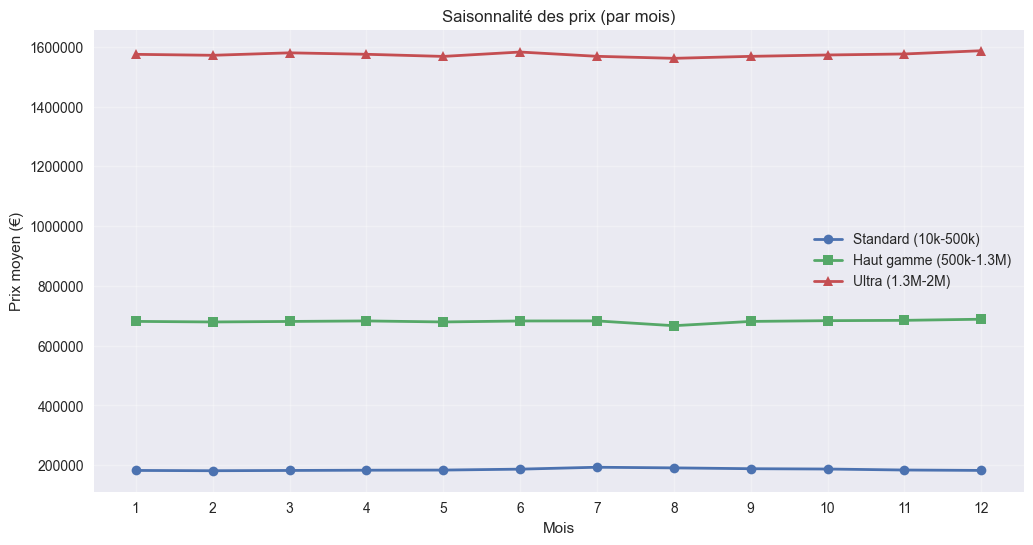


5. ANALYSE GÉOGRAPHIQUE PAR DÉPARTEMENT
✓ Départements identifiés - Segment standard   : 94
✓ Départements identifiés - Segment haut gamme : 94
✓ Départements identifiés - Segment ultra      : 93

TOP 10 DÉPARTEMENTS - SEGMENT STANDARD (10k-500k €)
------------------------------------------------------------
             valeur_fonciere_count  valeur_fonciere_mean  \
departement                                                
59                          147873              174286.0   
13                          114133              207747.0   
69                          100135              237201.0   
34                           98544              183135.0   
06                           96116              217253.0   
33                           93677              232253.0   
83                           93071              213863.0   
44                           89533              221322.0   
31                           88215              200230.0   
38                           

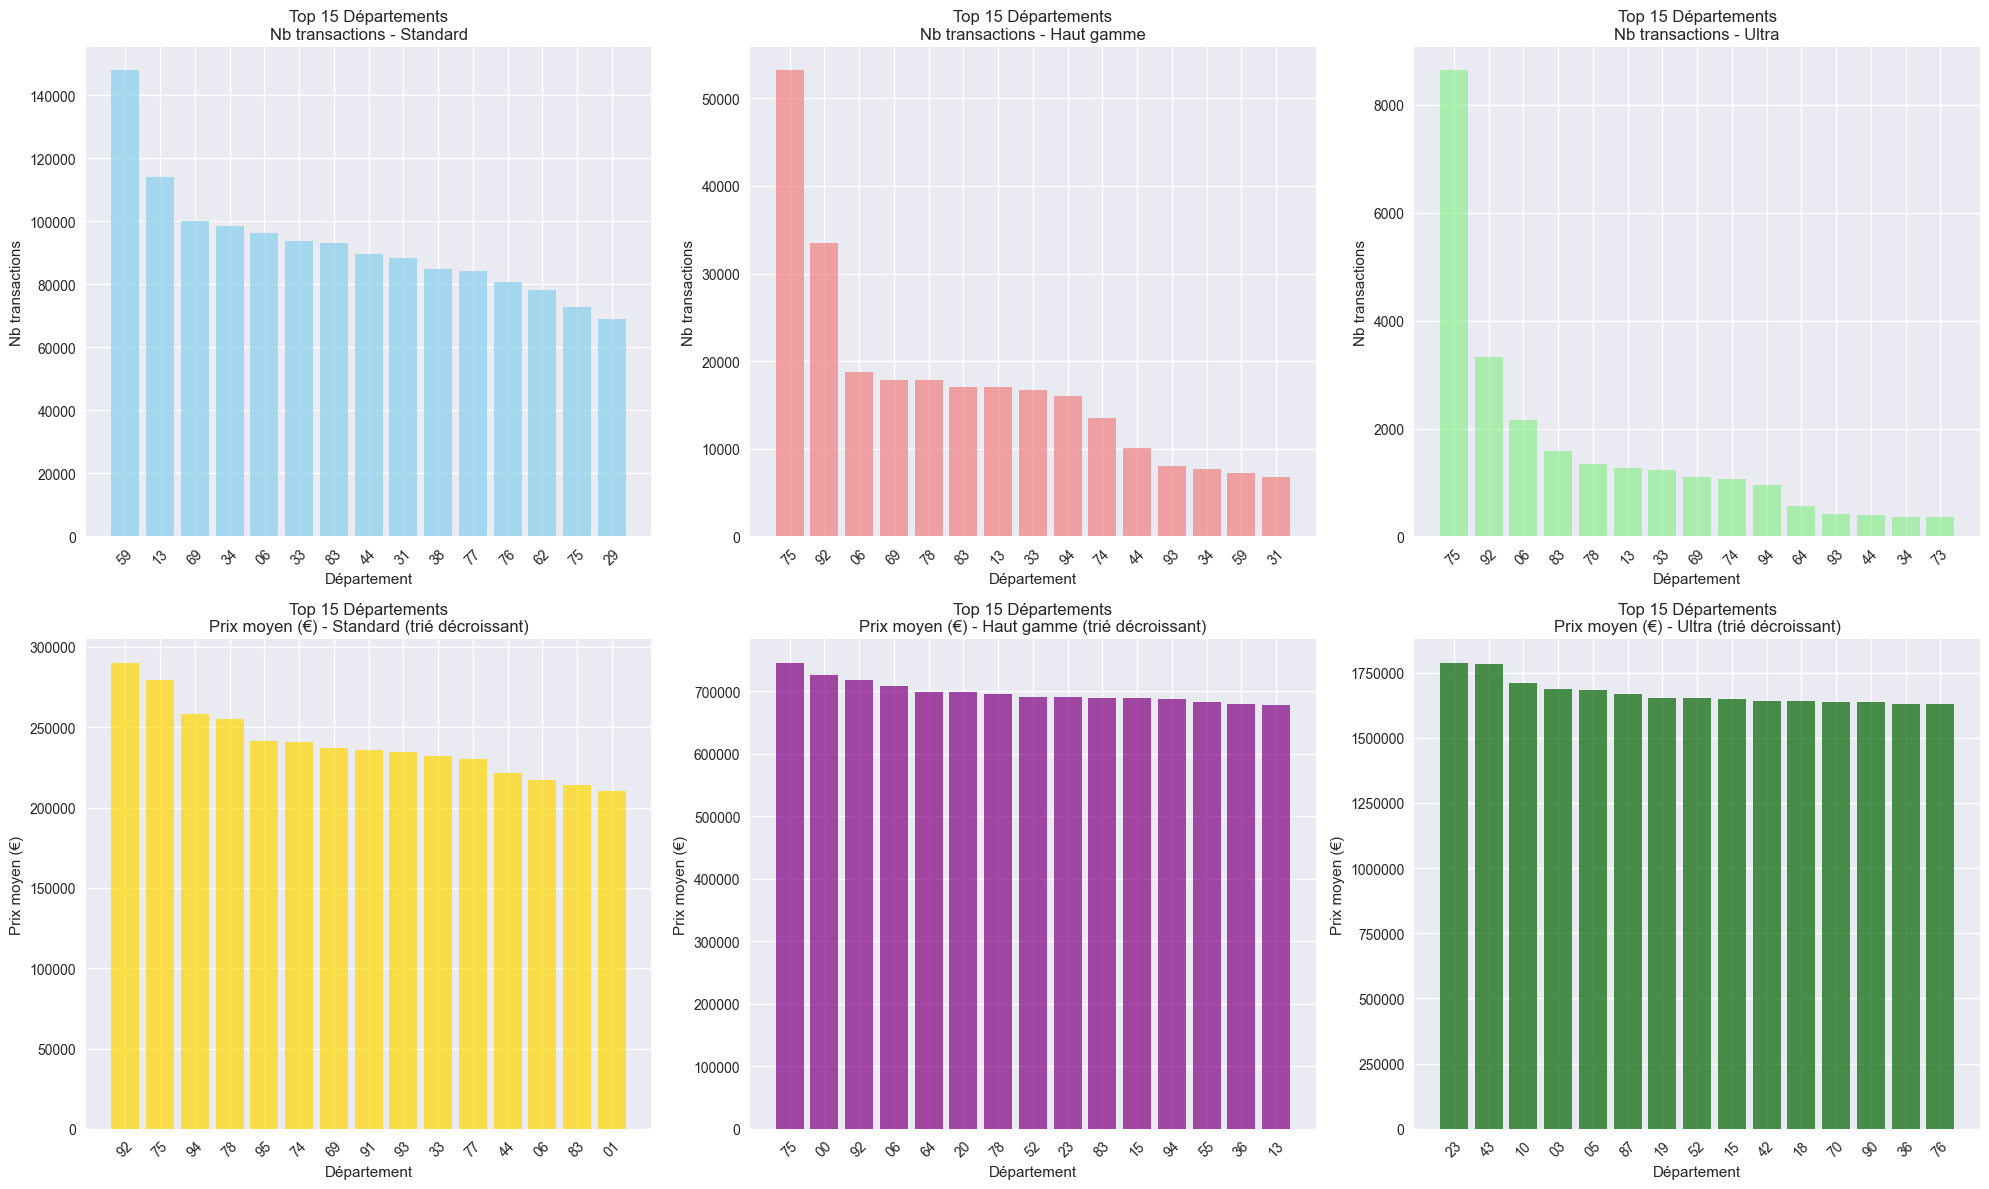


DÉPARTEMENTS COMMUNS AUX TROIS SEGMENTS : 93
Départements communs : ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '58', '59', '60', '61', '62', '63', '64', '65', '66', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '97']

COMPARAISON PRIX MOYENS - DÉPARTEMENTS COMMUNS (10 PREMIERS)
----------------------------------------------------------------------
             prix_standard  prix_haut_gamme  prix_ultra
departement                                            
01                210243.0         657403.0   1563502.0
02                120479.0         616544.0   1518665.0
03             

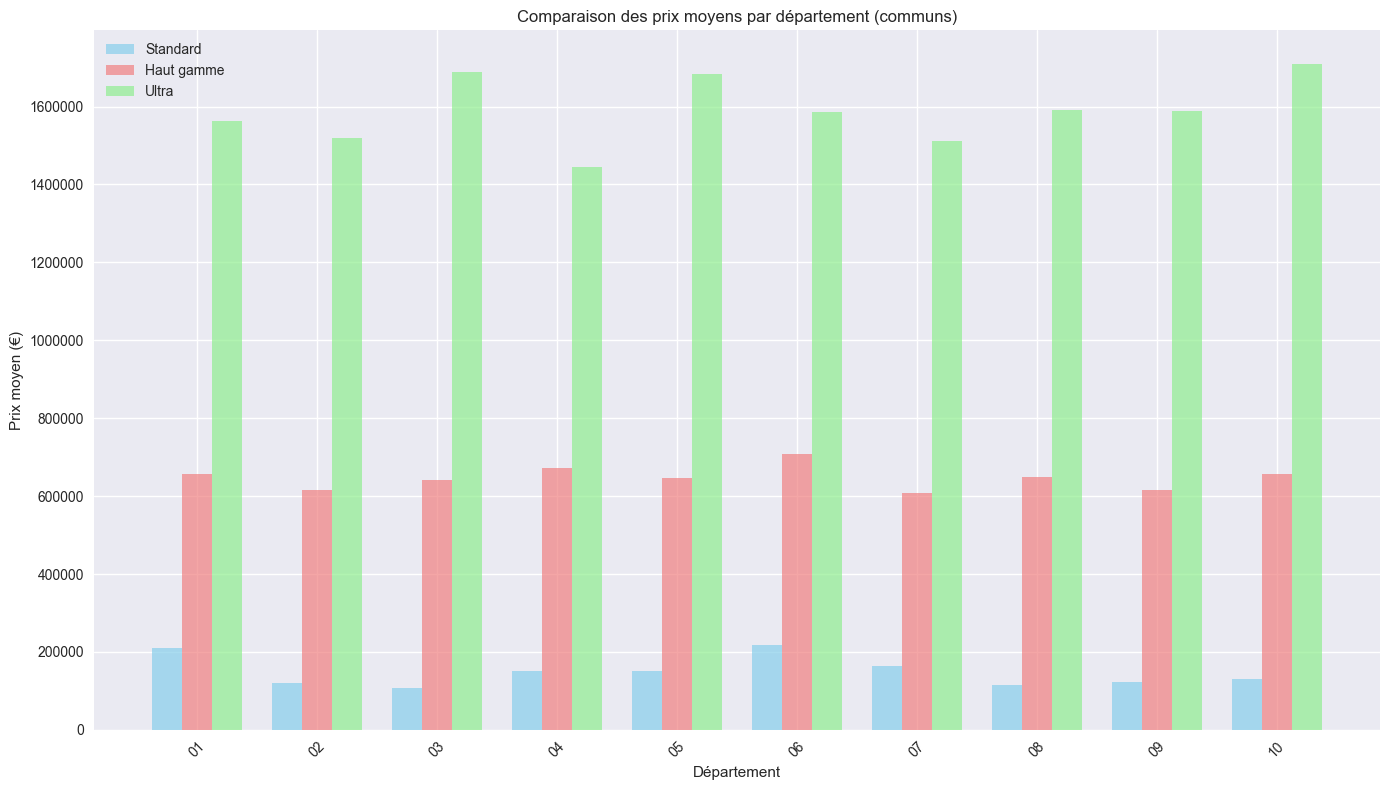


RÉSUMÉ GÉOGRAPHIQUE
------------------------------
Segment Standard :
  - Départements couverts       : 94
  - Prix moyen national         : 185470 €
  - Département le plus cher    : 92 (290122 €)
  - Département le moins cher   : 23 (79808 €)

Segment Haut gamme :
  - Départements couverts       : 94
  - Prix moyen national         : 681279 €
  - Département le plus cher    : 75 (745797 €)
  - Département le moins cher   : 43 (584470 €)

Segment Ultra :
  - Départements couverts       : 93
  - Prix moyen national         : 1574360 €
  - Département le plus cher    : 23 (1787868 €)
  - Département le moins cher   : 53 (1362500 €)

=== FIN ÉTAPE 2 ===


In [20]:
if __name__ == "__main__":
    print("Lancement de l'analyse comparative sur trois segments...")
    
    stats = compare_segments(df_1, df_2, df_3)
    plot_price_distributions(df_1, df_2, df_3)
    df_1_clean, df_2_clean, df_3_clean = analyze_surface_price_relationship(df_1, df_2, df_3)
    analyze_temporal_patterns(df_1, df_2, df_3)
    df1_geo, df2_geo, df3_geo, stats_dept_1, stats_dept_2, stats_dept_3 = \
        analyze_geographic_patterns(df_1, df_2, df_3)
    
    print("\n=== FIN ÉTAPE 2 ===")

### Explications des résultats :  

1- Comparaisons statistiques :  
Les résultats sont cohérents, malgré les datasets de tailles bien différents. Les datasets suivent les mêmes directions, des moyennes qui tendent vers les valeurs les plus basses, qui sont aussi les plus nombreuses par datasets.  
  
2- Distribution des prix :  
Pour cette partie, on peut constater que les graphiques suivent et correspondent aux tendances trouvées dans la comparaison statistique.  
  
3- Relation surface/prix :  
Nous pouvons observer une tendance générale, avec des droites de régressions qui semblent cohérentes.  
En effet, dans le segment standard, le nuage de points est éparpillé, mais la droite monte nettement en fonction de la surface, ce qui est cohérent. Ce schéma ce repète sur les deux autres dataframes, pour les hauts de gamme et ultras haut de gamme.  
On peut aussi constater, pour la partie ultras haut de gamme, que la pente est quasiment nulle. Cela peut s'expliquer par des facteurs assez simples : on vend dans cette tranche de prix des biens très chers, même pour des surfaces modestes, comme par exemple des appartements en bord de mer/fleuves, appartements de grandes ville, ect.  

4- Analyse temporelle :  
Etonnement, l'analyse sur les temporalitées n'a pas démontré d'évolution significatives, ni de changement. Nous pouvons tout de même prendre en compte que le dataset tiens compte des données de 2020 à 2024, ce qui reste une tranche temporelle courte, malgré la richesse de nos données.

5- Analyse géographique :  
Les trois segments couvrent presque tous les départements (93–94), avec une concentration des transactions Standard dans les zones urbaines (59, 13, 69…), des ventes Haut gamme dominées par Paris et la Côte d’Azur, et une forte hausse des prix Ultra dans des départements parfois ruraux (23 Creuse, 43 Haute-Loire) où les biens d’exception tirent la moyenne vers le haut.  

Grâce à cette analyse, nous savons vers quelels données nous tourner en priorité.  

Nous allons donc maintenant passer à l'étape 3 de notre projet : la création des modèles et featurings pour notre prédiction.  

## 3.1 Création des featurings et modèles

L’objectif de cette étape est de préparer les données de chaque segment immobilier pour qu’elles soient exploitables par un modèle de deep learning (ou de machine learning).
Cela passe par la création de nouvelles variables (“features”), le nettoyage, l’encodage et la structuration des datasets.  

Comment nous allons nous y prendre : 

-   Enrichissement temporel
On extrait de la date de mutation des informations comme l’année, le mois, le trimestre, le jour de la semaine, ainsi que des variables cycliques (sinus/cosinus pour la saisonnalité).
Ces variables permettront au modèle de mieux capter les effets temporels et saisonniers sur les prix.

-   Création de features de surface
On ajoute des indicateurs comme le prix au m², la surface par pièce, des catégories de taille de bien (très petit, moyen, grand…), et des transformations (log, carré de la surface).
Cela permet de mieux modéliser les relations entre surface, agencement du bien et valeur foncière.

-   Ajout de variables géographiques
On agrège les statistiques par département (prix moyen, médian, nombre de transactions, etc.) et on les rattache à chaque ligne du dataset.
Ces features captent le contexte local (niveau de prix du département, densité des transactions, etc.).

-   Création d’interactions
On crée des variables “mixtes” combinant plusieurs features (année x surface, type de bien x catégorie de surface…) pour donner au modèle plus de puissance prédictive.

-   Encodage des variables catégorielles
Toutes les variables textuelles (type_local, département, etc.) sont transformées en valeurs numériques (one-hot encoding ou label encoding), pour être utilisables par un réseau de neurones.

-   Préparation finale
On nettoie les NaN, on retire les colonnes inutiles, on sépare les features (X) de la variable cible (y = prix de vente), et on prépare le dataset final pour l’entraînement.



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("=== ÉTAPE 3 : FEATURE ENGINEERING POUR DEEP LEARNING ===\n")

def add_departement_col(df):
    temp = df.copy()
    if 'code_postal' in temp.columns and 'departement' not in temp.columns:
        temp['code_postal'] = temp['code_postal'].astype(str).str.zfill(5)
        temp['departement'] = temp['code_postal'].str[:2]
    return temp

def create_temporal_features(df):
    print("1. CRÉATION DES FEATURES TEMPORELLES")
    print("="*40)
    
    df = df.copy()
    if 'date_mutation' in df.columns:
        df['date_mutation'] = pd.to_datetime(df['date_mutation'])
        df['annee'] = df['date_mutation'].dt.year
        df['mois'] = df['date_mutation'].dt.month
        df['trimestre'] = df['date_mutation'].dt.quarter
        df['jour_semaine'] = df['date_mutation'].dt.dayofweek
        df['jour_annee'] = df['date_mutation'].dt.dayofyear
        
        # Composantes cycliques
        df['mois_sin'] = np.sin(2 * np.pi * df['mois'] / 12)
        df['mois_cos'] = np.cos(2 * np.pi * df['mois'] / 12)
        df['jour_semaine_sin'] = np.sin(2 * np.pi * df['jour_semaine'] / 7)
        df['jour_semaine_cos'] = np.cos(2 * np.pi * df['jour_semaine'] / 7)
        
        # Nombre de jours depuis la première date
        reference_date = df['date_mutation'].min()
        df['jours_depuis_debut'] = (df['date_mutation'] - reference_date).dt.days
        
        print(f"✓ Features temporelles créées : {['annee','mois','trimestre','mois_sin','mois_cos','jours_depuis_debut']}")
    else:
        print("⚠️  Colonne 'date_mutation' non trouvée")
    return df

def create_surface_features(df):
    print("\n2. CRÉATION DES FEATURES DE SURFACE")
    print("="*40)
    
    df = df.copy()
    if 'surface_reelle_bati' in df.columns:
        df = df[df['surface_reelle_bati'] > 0].copy()
        df['prix_m2'] = df['valeur_fonciere'] / df['surface_reelle_bati']
        
        # Catégories de surface
        df['categorie_surface'] = pd.cut(
            df['surface_reelle_bati'],
            bins=[0,50,100,150,200,np.inf],
            labels=['Très petit','Petit','Moyen','Grand','Très grand']
        )
        df['log_surface'] = np.log1p(df['surface_reelle_bati'])
        df['surface_squared'] = df['surface_reelle_bati'] ** 2
        
        if 'nombre_pieces_principales' in df.columns:
            df = df[df['nombre_pieces_principales'] > 0].copy()
            df['surface_par_piece'] = df['surface_reelle_bati'] / df['nombre_pieces_principales']
            print(f"✓ Features de surface créées : {['prix_m2','categorie_surface','log_surface','surface_par_piece']}")
        else:
            print(f"✓ Features de surface créées : {['prix_m2','categorie_surface','log_surface']}")
            print("⚠️  Colonne 'nombre_pieces_principales' non trouvée")
    else:
        print("⚠️  Colonne 'surface_reelle_bati' non trouvée")
    return df

def create_geographical_features(df):
    print("\n3. CRÉATION DES FEATURES GÉOGRAPHIQUES")
    print("="*45)
    
    df = df.copy()
    if 'departement' in df.columns:
        dept_stats = df.groupby('departement').agg({
            'valeur_fonciere': ['mean','median','std','count'],
            'surface_reelle_bati': ['mean','median'] if 'surface_reelle_bati' in df.columns else []
        }).round(2)
        
        # Aplatir le multi‐index
        dept_stats.columns = ['_'.join(col).strip() for col in dept_stats.columns]
        dept_stats = dept_stats.add_prefix('dept_')
        
        df = df.merge(dept_stats, left_on='departement', right_index=True, how='left')
        
        if 'dept_valeur_fonciere_mean' in df.columns:
            df['ratio_prix_dept'] = df['valeur_fonciere'] / df['dept_valeur_fonciere_mean']
        df['dept_densite_transactions'] = df['dept_valeur_fonciere_count']
        
        print(f"✓ Features géographiques créées pour {df['departement'].nunique()} départements")
    else:
        print("⚠️  Colonne 'departement' non trouvée")
    return df

def create_interaction_features(df):
    print("\n4. CRÉATION DES FEATURES D'INTERACTION")
    print("="*45)
    
    df = df.copy()
    if 'annee' in df.columns and 'surface_reelle_bati' in df.columns:
        df['annee_x_surface'] = df['annee'] * df['surface_reelle_bati']
    if 'dept_valeur_fonciere_mean' in df.columns and 'surface_reelle_bati' in df.columns:
        df['dept_prix_x_surface'] = df['dept_valeur_fonciere_mean'] * df['surface_reelle_bati']
    if 'type_local' in df.columns and 'categorie_surface' in df.columns:
        df['type_local_x_surface_cat'] = (
            df['type_local'].astype(str) + "_" + df['categorie_surface'].astype(str)
        )
    print("✓ Features d'interaction créées")
    return df

def encode_categorical_features(df, target_col='valeur_fonciere'):
    print("\n5. ENCODAGE DES VARIABLES CATÉGORIELLES")
    print("="*45)
    
    df = df.copy()
    encoded_features = []
    
    # 1) Suppression de id_unique (inutile comme feature)
    if 'id_unique' in df.columns:
        df.drop(columns=['id_unique'], inplace=True)
        print("✓ Colonne 'id_unique' supprimée (identifiant unique non utile)")
    
    # 2) Recensement des colonnes de type object ou category
    categorical_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    categorical_cols = [c for c in categorical_cols if c not in [target_col,'date_mutation']]
    
    # On retire 'commune' et 'code_postal' s’ils sont présents
    for col in ['commune','code_postal']:
        if col in categorical_cols:
            categorical_cols.remove(col)
    
    # On s'assure que 'departement' figure dans la liste si c'est un objet
    if 'departement' in df.columns and 'departement' not in categorical_cols:
        categorical_cols.append('departement')
    
    # 3) Pour chaque colonne catégorielle, on choisit one-hot ou label encoding
    for col in categorical_cols:
        if col in df.columns:
            unique_values = df[col].nunique()
            if unique_values <= 10:
                # One-hot encoding
                dummies = pd.get_dummies(df[col], prefix=col, dummy_na=True)
                df = pd.concat([df, dummies], axis=1)
                encoded_features.extend(dummies.columns.tolist())
                df.drop(columns=[col], inplace=True)
                print(f"✓ One-hot encoding appliqué à '{col}' ({unique_values} catégories)")
            else:
                # Label encoding
                le = LabelEncoder()
                df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
                encoded_features.append(f'{col}_encoded')
                df.drop(columns=[col], inplace=True)
                print(f"✓ Label encoding appliqué à '{col}' ({unique_values} catégories)")
    
    print(f"✓ Total features encodées : {len(encoded_features)}")
    return df, encoded_features

def prepare_features_for_ml(df, target_col='valeur_fonciere'):
    """
    Préparation finale des features pour le machine learning
    """
    print("\n6. PRÉPARATION FINALE POUR ML")
    print("="*35)
    
    df = df.copy()
    
    # 1) Supprimer 'date_mutation'
    cols_to_drop = ['date_mutation']
    cols_to_drop = [c for c in cols_to_drop if c in df.columns]
    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)
        print(f"✓ Colonnes supprimées : {cols_to_drop}")
    
    # 2) Gestion inf / -inf → NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # 3) Remplir NaN seulement sur les colonnes numériques
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    nan_counts = df[numeric_cols].isnull().sum()
    if nan_counts.sum() > 0:
        print("⚠️  Valeurs NaN restantes dans les colonnes numériques :")
        print(nan_counts[nan_counts > 0])
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
        print("✓ NaN numériques remplacés par la médiane")
    
    # 4) Séparation X et y
    y = df[target_col].copy()
    X = df.drop(columns=[target_col]).copy()
    
    print(f"✓ Dataset final : {X.shape[0]} lignes, {X.shape[1]} features")
    print(f"✓ Variables cibles : {len(y)} valeurs")
    return X, y

def full_feature_engineering_pipeline(df, segment_name=""):
    """
    Pipeline complet de feature engineering
    """
    print(f"\n{'='*60}")
    print(f"PIPELINE FEATURE ENGINEERING - {segment_name}")
    print(f"{'='*60}")
    print(f"Dataset initial : {df.shape[0]} lignes, {df.shape[1]} colonnes")
    
    # 0) Ajouter la colonne 'departement' si elle n'existe pas
    df = add_departement_col(df)
    # 1) Temporal
    df = create_temporal_features(df)
    # 2) Surface
    df = create_surface_features(df)
    # 3) Géographie (département)
    df = create_geographical_features(df)
    # 4) Interactions
    df = create_interaction_features(df)
    # 5) Encodage caté
    df, encoded_features = encode_categorical_features(df)
    # 6) Préparation finale
    X, y = prepare_features_for_ml(df)
    
    print(f"\n{'='*60}")
    print(f"RÉSULTATS FINAUX - {segment_name}")
    print(f"{'='*60}")
    print(f"✓ Features finales : {X.shape[1]}")
    print(f"✓ Échantillons : {len(y)}")
    print(f"✓ Prix moyen : {y.mean():.0f} €")
    print(f"✓ Exemples de features : {list(X.columns[:10])}")
    return X, y, df

=== ÉTAPE 3 : FEATURE ENGINEERING POUR DEEP LEARNING ===



In [22]:
if __name__ == "__main__":
    print("Pipeline de Feature Engineering prêt !\n")
    
    # Segment Standard (10k-500k)
    X_1, y_1, df_1_processed = full_feature_engineering_pipeline(df_1, 'SEGMENT STANDARD')
    
    # Segment Haut gamme (500k-1.3M)
    X_2, y_2, df_2_processed = full_feature_engineering_pipeline(df_2, 'SEGMENT HAUT GAMME')
    
    # Segment Ultra (1.3M-2M)
    X_3, y_3, df_3_processed = full_feature_engineering_pipeline(df_3, 'SEGMENT ULTRA')
    
    print("\n=== FIN ÉTAPE 3 ===")
    print("Prochaine étape : Préparation train/test et normalisation")

Pipeline de Feature Engineering prêt !


PIPELINE FEATURE ENGINEERING - SEGMENT STANDARD
Dataset initial : 3896882 lignes, 13 colonnes
1. CRÉATION DES FEATURES TEMPORELLES
✓ Features temporelles créées : ['annee', 'mois', 'trimestre', 'mois_sin', 'mois_cos', 'jours_depuis_debut']

2. CRÉATION DES FEATURES DE SURFACE
✓ Features de surface créées : ['prix_m2', 'categorie_surface', 'log_surface', 'surface_par_piece']

3. CRÉATION DES FEATURES GÉOGRAPHIQUES
✓ Features géographiques créées pour 94 départements

4. CRÉATION DES FEATURES D'INTERACTION
✓ Features d'interaction créées

5. ENCODAGE DES VARIABLES CATÉGORIELLES
✓ Colonne 'id_unique' supprimée (identifiant unique non utile)
✓ One-hot encoding appliqué à 'fichier_source' (4 catégories)
✓ One-hot encoding appliqué à 'nature_mutation' (6 catégories)
✓ One-hot encoding appliqué à 'type_local' (2 catégories)
✓ One-hot encoding appliqué à 'part_date' (1 catégories)
✓ Label encoding appliqué à 'departement' (94 catégories)
✓ One-hot encod

Résultats des analyses sur nos featurings :  

-   Homogénéité des traitements
On voit que les transformations sont appliquées de manière cohérente à chaque segment, ce qui facilitera la comparaison ou l’entraînement de modèles séparés (voire un modèle global multi-segment).

-   Richesse des features
Le nombre de variables finales (61-63) est équilibré :

    -   Les features temporelles, de surface et géographiques sont bien présentes.  
    -   L’encodage mixte (one-hot et label) sur les catégories garantit une exploitation optimale, y compris pour des features à forte cardinalité comme les départements.  

-   Gestion des valeurs manquantes
Le fait de détecter et de remplacer les NaN au dernier moment évite de propager des soucis dans le pipeline, ce qui est important pour la suite.

-   Exemples de features
Les variables en sortie (année, mois, jour_semaine, surface, interactions, etc.) sont exactement ce qu’attend un modèle de machine learning moderne sur ce type de données.

-   Statistiques de base  
Le prix moyen par segment est pertinent et réaliste :  
    -   Segment standard ≈ 187 000 €  
    -   Haut de gamme ≈ 678 000 €  
    -   Ultra ≈ 1 570 000 €  
    Cela permet de bien séparer les logiques marché. Cela nous montre que notre division du dataset principal était une bonne idée.

Maintenant que notre pipeline est prêt, nous pouvons commencer l’analyse. Pour cela, nous devons identifier quelles sont les features les plus pertinentes et vérifier la cohérence de nos données avant d’entraîner quoi que ce soit.

Nous effectuons pour chaque jeu de données (Dataset_1, Dataset_2 et Dataset_3) une pré-analyse systématique, qui nous assure que nous travaillons bien sur des données nettoyées et prêtes à l’usage. Cette étape nous permet de garantir la validité de nos résultats et d’éviter tout problème lié à des valeurs manquantes ou aberrantes. C’est pourquoi, à l’intérieur de la fonction prepare_dataset_for_ml, on inspecte toujours :

-   Les valeurs manquantes (NaN) et/ou infinies dans les colonnes features et dans la target
-   La distribution de la cible (valeur_fonciere) : on contrôle le minimum, le maximum, la médiane, l’écart-type et le skewness pour savoir si une transformation (par exemple logarithmique) est nécessaire ;

La séparation des données en ensembles d’entraînement, de validation et de test selon un découpage 80 % / 10 % / 10 % :  

-   80 % des échantillons sont dédiés à l’apprentissage,
-   10 % à la validation (pour ajuster les hyperparamètres et surveiller le sur‐apprentissage),
-   10 % au test final (pour évaluer la performance du modèle sur du « neuf »).  

Ensuite, sur chaque sous‐ensemble d’entraînement, on applique :

Une normalisation des variables numériques à l’aide d’un RobustScaler (qui prend en compte la médiane et les quartiles plutôt que la moyenne et l’écart‐type), ce qui nous protège des valeurs aberrantes et permet au réseau de neurones ou à tout autre algorithme d’apprendre plus efficacement.

Calculons un score d’importance pour chaque variable numérique à l’aide de l’algorithme d’« information mutuelle » (mutual_info_regression), afin de dresser un premier classement des features les plus informatives vis‐à‐vis de la target. Cela nous offre trois avantages :

-   Vérifier que les features attendues (prix au m², indicateurs géographiques, agrégats départementaux, etc.) sont bien discriminantes.
-   Détecter d’éventuelles corrélations trop fortes ou des variables redondantes.
-   Prévoir, en amont, la possibilité de réduire la dimensionnalité ou de focaliser notre feature engineering sur les colonnes à forte importance.

Enfin, selon l’asymétrie de la distribution de la target (skewness), le code applique automatiquement une transformée logarithmique si le skewness dépasse un certain seuil (1,5). Cette transformation permet de « compressifier » les valeurs extrêmes lorsque les prix sont très hétérogènes (notamment dans Dataset_2, où l’on peut passer de quelques centaines de milliers d’euros à plus d’un million). La transformée logarithmique (via np.log1p) produit ensuite trois vecteurs cibles (y_train_transformed, y_val_transformed, y_test_transformed) utilisables directement pour l’entraînement.

Une fois toutes ces étapes réalisées pour chaque jeu de données, nous obtenons un résumé global des trois datasets :

Le nombre total d’échantillons disponibles en train, validation et test (plus de 3 millions d’exemples d’entraînement au total),

La liste des variables communes à tous les jeux, ainsi que celles qui sont spécifiques à chacun (pour pouvoir, si besoin, fusionner ou comparer les ensembles).

Nous proposons également une fonction combine_datasets qui permet d’agréger les trois jeux préparés en un seul grand dataset uniforme. On peut choisir de ne conserver que les features communes aux trois segments (pour éviter tout vide) ou de prendre l’union des colonnes (en imputant les colonnes manquantes par défaut à zéro), ce qui offre une grande flexibilité si l’on souhaite entraîner un modèle global couvrant l’ensemble des tranches de prix.

(Le temps d'execution de ce code est de 32 minutes environ.)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("ÉTAPE 4 - PRÉPARATION POUR LE MACHINE LEARNING")
print("=" * 60)

# Fonction pour analyser et préparer un dataset
def prepare_dataset_for_ml(df, dataset_name, target_column='valeur_fonciere'):
    print(f"\n🔄 TRAITEMENT DU DATASET : {dataset_name}")
    print("=" * 50)
    
    # 1. SÉPARATION FEATURES/TARGET
    print("1. SÉPARATION FEATURES/TARGET")
    print("-" * 30)
    
    # Identifier les colonnes features (exclure la target et les colonnes non-numériques inutiles)
    exclude_cols = [target_column, 'commune', 'adresse_nom_voie'] if 'commune' in df.columns else [target_column]
    feature_columns = [col for col in df.columns if col not in exclude_cols]
    
    X = df[feature_columns].copy()
    y = df[target_column].copy()
    
    print(f"✓ Features : {X.shape[1]} colonnes")
    print(f"✓ Target : {len(y)} valeurs")
    print(f"✓ Prix moyen : {y.mean():,.0f} €")
    
    # 2. VÉRIFICATION DES DONNÉES
    print(f"\n2. VÉRIFICATION DES DONNÉES")
    print("-" * 30)
    
    # Vérifier les valeurs manquantes
    missing_features = X.isnull().sum()
    missing_target = y.isnull().sum()
    
    print(f"✓ Valeurs manquantes dans X : {missing_features.sum()}")
    print(f"✓ Valeurs manquantes dans y : {missing_target}")
    
    # Supprimer les lignes avec des valeurs manquantes si nécessaire
    if missing_features.sum() > 0 or missing_target > 0:
        mask = ~(X.isnull().any(axis=1) | y.isnull())
        X = X[mask]
        y = y[mask]
        print(f"✓ Lignes après nettoyage : {len(X)}")
    
    # Vérifier les valeurs infinies
    inf_mask = ~(np.isinf(X.select_dtypes(include=[np.number])).any(axis=1))
    if not inf_mask.all():
        X = X[inf_mask]
        y = y[inf_mask]
        print(f"✓ Lignes après suppression des valeurs infinies : {len(X)}")
    
    # 3. ANALYSE DE LA DISTRIBUTION DE LA TARGET
    print(f"\n3. ANALYSE DE LA TARGET")
    print("-" * 30)
    
    print(f"✓ Min : {y.min():,.0f} €")
    print(f"✓ Max : {y.max():,.0f} €")
    print(f"✓ Médiane : {y.median():,.0f} €")
    print(f"✓ Écart-type : {y.std():,.0f} €")
    print(f"✓ Skewness : {stats.skew(y):.2f}")
    
    # 4. DIVISION TRAIN/VALIDATION/TEST
    print(f"\n4. DIVISION DU DATASET")
    print("-" * 30)
    
    # Division train/temp (80/20)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=None
    )
    
    # Division temp en validation/test (10/10)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )
    
    print(f"✓ Train : {len(X_train):,} échantillons ({len(X_train)/len(X)*100:.1f}%)")
    print(f"✓ Validation : {len(X_val):,} échantillons ({len(X_val)/len(X)*100:.1f}%)")
    print(f"✓ Test : {len(X_test):,} échantillons ({len(X_test)/len(X)*100:.1f}%)")
    
    # 5. NORMALISATION DES FEATURES
    print(f"\n5. NORMALISATION DES FEATURES")
    print("-" * 30)
    
    # Identifier les colonnes numériques
    numeric_columns = X_train.select_dtypes(include=[np.number]).columns
    
    # Utiliser RobustScaler pour gérer les outliers
    scaler = RobustScaler()
    
    # Fit sur train seulement
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()
    
    X_train_scaled[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
    X_val_scaled[numeric_columns] = scaler.transform(X_val[numeric_columns])
    X_test_scaled[numeric_columns] = scaler.transform(X_test[numeric_columns])
    
    print(f"✓ {len(numeric_columns)} colonnes numériques normalisées")
    print(f"✓ Scaler utilisé : RobustScaler")
    
    # 6. SÉLECTION DE FEATURES
    print(f"\n6. ANALYSE DE L'IMPORTANCE DES FEATURES")
    print("-" * 30)
    
    # Calculer l'importance des features avec mutual information
    mi_scores = mutual_info_regression(X_train_scaled[numeric_columns], y_train, random_state=42)
    
    # Créer un DataFrame pour l'analyse
    feature_importance = pd.DataFrame({
        'feature': numeric_columns,
        'importance': mi_scores
    }).sort_values('importance', ascending=False)
    
    print(f"✓ Top 10 features importantes :")
    for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
        print(f"   {i+1:2d}. {row['feature']:<30} {row['importance']:.4f}")
    
    # 7. TRANSFORMATION LOG DE LA TARGET
    print(f"\n7. TRANSFORMATION DE LA TARGET")
    print("-" * 30)
    
    # Si la target est très skewed, appliquer log transform
    if abs(stats.skew(y_train)) > 1.5:
        print("✓ Application de la transformation log (target très asymétrique)")
        y_train_transformed = np.log1p(y_train)
        y_val_transformed = np.log1p(y_val)
        y_test_transformed = np.log1p(y_test)
        target_transformed = True
    else:
        print("✓ Pas de transformation de la target nécessaire")
        y_train_transformed = y_train
        y_val_transformed = y_val
        y_test_transformed = y_test
        target_transformed = False
    
    # 8. RÉSUMÉ FINAL
    print(f"\n8. RÉSUMÉ FINAL - {dataset_name}")
    print("-" * 30)
    print(f"✓ Features finales : {X_train_scaled.shape[1]}")
    print(f"✓ Échantillons train : {len(X_train_scaled):,}")
    print(f"✓ Échantillons validation : {len(X_val_scaled):,}")
    print(f"✓ Échantillons test : {len(X_test_scaled):,}")
    print(f"✓ Target transformée : {'Oui (log)' if target_transformed else 'Non'}")
    
    return {
        'X_train': X_train_scaled,
        'X_val': X_val_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train_transformed,
        'y_val': y_val_transformed,
        'y_test': y_test_transformed,
        'scaler': scaler,
        'feature_importance': feature_importance,
        'target_transformed': target_transformed,
        'feature_columns': feature_columns,
        'numeric_columns': numeric_columns
    }

# TRAITEMENT DES 3 DATASETS

# Dictionnaire pour stocker les résultats
datasets_prepared = {}

# Préparer chaque dataset
for i, df in enumerate([df_1_processed, df_2_processed, df_3_processed], 1):
    dataset_name = f"Dataset_{i}"
    datasets_prepared[dataset_name] = prepare_dataset_for_ml(df, dataset_name)

print("\n" + "=" * 60)
print("RÉSUMÉ GLOBAL DES 3 DATASETS")
print("=" * 60)

total_train = sum([data['X_train'].shape[0] for data in datasets_prepared.values()])
total_val = sum([data['X_val'].shape[0] for data in datasets_prepared.values()])
total_test = sum([data['X_test'].shape[0] for data in datasets_prepared.values()])

print(f"✓ Total échantillons train : {total_train:,}")
print(f"✓ Total échantillons validation : {total_val:,}")
print(f"✓ Total échantillons test : {total_test:,}")

# Analyser la cohérence des features entre datasets
print(f"\n📊 ANALYSE DE COHÉRENCE DES FEATURES")
print("-" * 40)

feature_sets = [set(data['feature_columns']) for data in datasets_prepared.values()]
common_features = set.intersection(*feature_sets)
all_features = set.union(*feature_sets)

print(f"✓ Features communes aux 3 datasets : {len(common_features)}")
print(f"✓ Features totales (union) : {len(all_features)}")

# Identifier les features différentes
for i, (name, data) in enumerate(datasets_prepared.items(), 1):
    unique_features = set(data['feature_columns']) - common_features
    if unique_features:
        print(f"✓ Features uniques à {name} : {len(unique_features)}")

print(f"\n🎯 PRÊT POUR L'ENTRAÎNEMENT DU MODÈLE !")
print("=" * 60)

# Combiner les datasets si nécessaire
def combine_datasets(datasets_dict, common_features_only=True):
    """
    Combine les 3 datasets préparés en un seul
    """
    print(f"\n🔗 COMBINAISON DES DATASETS")
    print("-" * 30)
    
    if common_features_only:
        # Utiliser seulement les features communes
        features_to_use = list(common_features)
        print(f"✓ Utilisation des {len(features_to_use)} features communes")
    else:
        # Utiliser toutes les features (avec des NaN pour les manquantes)
        features_to_use = list(all_features)
        print(f"✓ Utilisation de toutes les {len(features_to_use)} features")
    
    # Combiner les données
    X_train_combined = []
    X_val_combined = []
    X_test_combined = []
    y_train_combined = []
    y_val_combined = []
    y_test_combined = []
    
    for name, data in datasets_dict.items():
        # Sélectionner les features communes
        X_train_subset = data['X_train'][features_to_use] if common_features_only else data['X_train'].reindex(columns=features_to_use, fill_value=0)
        X_val_subset = data['X_val'][features_to_use] if common_features_only else data['X_val'].reindex(columns=features_to_use, fill_value=0)
        X_test_subset = data['X_test'][features_to_use] if common_features_only else data['X_test'].reindex(columns=features_to_use, fill_value=0)
        
        X_train_combined.append(X_train_subset)
        X_val_combined.append(X_val_subset)
        X_test_combined.append(X_test_subset)
        y_train_combined.append(data['y_train'])
        y_val_combined.append(data['y_val'])
        y_test_combined.append(data['y_test'])
    
    # Concaténer
    X_train_final = pd.concat(X_train_combined, ignore_index=True)
    X_val_final = pd.concat(X_val_combined, ignore_index=True)
    X_test_final = pd.concat(X_test_combined, ignore_index=True)
    y_train_final = pd.concat(y_train_combined, ignore_index=True)
    y_val_final = pd.concat(y_val_combined, ignore_index=True)
    y_test_final = pd.concat(y_test_combined, ignore_index=True)
    
    print(f"✓ Dataset combiné - Train : {len(X_train_final):,}")
    print(f"✓ Dataset combiné - Validation : {len(X_val_final):,}")
    print(f"✓ Dataset combiné - Test : {len(X_test_final):,}")
    
    return {
        'X_train': X_train_final,
        'X_val': X_val_final,
        'X_test': X_test_final,
        'y_train': y_train_final,
        'y_val': y_val_final,
        'y_test': y_test_final,
        'features_used': features_to_use
    }

print(f"\n📁 ACCÈS AUX DONNÉES PRÉPARÉES :")
print(f"   - datasets_prepared['Dataset_1'] pour le dataset 1")
print(f"   - datasets_prepared['Dataset_2'] pour le dataset 2") 
print(f"   - datasets_prepared['Dataset_3'] pour le dataset 3")
print(f"   - combine_datasets() pour combiner les datasets")

ÉTAPE 4 - PRÉPARATION POUR LE MACHINE LEARNING

🔄 TRAITEMENT DU DATASET : Dataset_1
1. SÉPARATION FEATURES/TARGET
------------------------------
✓ Features : 61 colonnes
✓ Target : 3701567 valeurs
✓ Prix moyen : 186,679 €

2. VÉRIFICATION DES DONNÉES
------------------------------
✓ Valeurs manquantes dans X : 0
✓ Valeurs manquantes dans y : 0

3. ANALYSE DE LA TARGET
------------------------------
✓ Min : 10,000 €
✓ Max : 470,000 €
✓ Médiane : 169,300 €
✓ Écart-type : 103,504 €
✓ Skewness : 0.64

4. DIVISION DU DATASET
------------------------------
✓ Train : 2,961,253 échantillons (80.0%)
✓ Validation : 370,157 échantillons (10.0%)
✓ Test : 370,157 échantillons (10.0%)

5. NORMALISATION DES FEATURES
------------------------------
✓ 27 colonnes numériques normalisées
✓ Scaler utilisé : RobustScaler

6. ANALYSE DE L'IMPORTANCE DES FEATURES
------------------------------
✓ Top 10 features importantes :
    1. ratio_prix_dept                5.8161
    2. prix_m2                        4.

Analyse du retour en console de notre préparation :  

1. Séparation Features/Target & Split
-  Nombre de colonnes cohérent avec l’ingénierie précédente (61-63 features selon les jeux).
-  Volumes parfaitement équilibrés (80/10/10), avec plusieurs millions d’échantillons pour le segment principal, ce qui garantit robustesse et généralisation pour les modèles.

2. Vérification des données
-   Aucune valeur manquante dans les features (presque) : 0 pour les jeux 1 et 2, une seule ligne retirée pour le jeu 3 → Données clean, aucun risque de missing values.
-   Valeurs cibles (target) également propres.
-   Les lignes problématiques ont également été retirées sur la feature.

3. Distribution de la target
-   Prix min/max, médiane et écart-type : tout est logique et suit la segmentation tarifaire du pipeline :
    -   Dataset 1 : 10k à 470k (prix standard, skewness faible)
    -   Dataset 2 : 470k à 1,3M (haut de gamme, skewness un peu plus marquée)
    -   Dataset 3 : 1,3M à 2M (ultra, distribution très propre et peu skewed)
-   Skewness faible partout (0,5 à 1,25, max). Il suit la même logique sur les 3 datasets, ce qui est une bonne nouvelle.

4. Normalisation
-   RobustScaler : 27 colonnes numériques à chaque fois, c’est logique et garantis la comparabilité entre datasets.
-   Pas d’effet indésirable : pas d’alerte sur la normalisation.

5. Importance des features
-   ratio_prix_dept et prix_m2 arrivent toujours en tête, ce qui est totalement attendu en immobilier (et rassurant sur la pertinence de l’ingénierie de features).
-   Les agrégats départementaux et le “prix par mètre carré” sont donc bien déterminants.
-   Cohérence : les features les plus informatives sont celles construites exprès pour capturer la valeur relative (prix local, département, etc.).
-   La colonne “departement_encoded” reste utile pour la localisation.

6. Cohérence des jeux
-   Features communes : 61, features totales (union) : 63.
    -   Quelques variables spécifiques par jeu (catégories de surface différentes, par exemple), mais 61 utilisables pour tous.
-   Aucune alerte sur des colonnes totalement manquantes ou inutilisées.

### 3.2 - Préaparation du dataset 1 

Avant de procéder à l’entraînement de notre modèle, il est essentiel de préparer rigoureusement notre dataset, afin d’assurer la qualité et la robustesse des prédictions futures.  
Ce code va donc être dédié à la préparation complète du premier jeu de données (Dataset 1).  

Voici donc la direction que l'on va prendre :  
1. Séparation des features et de la variable cible
-   Nous isolons la colonne à prédire (valeur_fonciere) des autres variables explicatives.
-   On exclut aussi, si présentes, les colonnes non pertinentes comme les identifiants ou les colonnes purement descriptives (commune, adresse_nom_voie).

2. Vérification et nettoyage des données
-   On contrôle systématiquement la présence de valeurs manquantes ou aberrantes (NaN, infinis) et on retire les lignes problématiques pour garantir la fiabilité de l’entraînement. Même si nous avons déjà effectué cette étape plusieur fois, nous étsimons que c'est plus que necessaire de s'assurer que chaque dataframe à bien les odnnées les plus propres possibles pour assurer une précision la plus fine possible.

3. Analyse de la distribution de la target
-   On inspecte rapidement la distribution de la variable cible : min, max, médiane, écart-type, skewness… Cela permet de repérer d’éventuels biais ou valeurs extrêmes à traiter.

4. Découpage du dataset en ensembles d’entraînement, validation et test
-   On réalise un split en trois parties :
    -   80% pour l’apprentissage du modèle,
    -   10% pour ajuster les hyperparamètres,
    -   10% pour l’évaluation finale.

5. Normalisation des variables numériques
-   Pour garantir la stabilité des algorithmes, on applique un RobustScaler sur toutes les features numériques (centré sur la médiane et robuste aux outliers), avec un fit uniquement sur l’ensemble d’entraînement.

6. Analyse rapide de l’importance des features
-   On calcule, sur un échantillon, une importance relative des variables numériques vis-à-vis de la cible, via l’algorithme de mutual information.
-   Cela donne un aperçu rapide des variables les plus informatives.

7. Transformation logarithmique de la target (optionnel)
-   Si la cible est très asymétrique, on applique une transformation log pour stabiliser la variance et faciliter la modélisation.

8. Construction du jeu de données final
-   On rassemble toutes les données prêtes (features normalisées, cible éventuellement transformée) dans un dictionnaire Python qui pourra être directement utilisé pour l’entraînement.

9. Aperçu et vérification
-   Un résumé des shapes, des premières features, et des instructions d’utilisation conclut la préparation.

Préparation pour le dataset 1 uniquement :

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("ÉTAPE 4 - PRÉPARATION ML - DATASET 1 UNIQUEMENT")
print("=" * 60)

# TRAITEMENT DU PREMIER DATASET SEULEMENT
df = df_1_processed
dataset_name = "Dataset_1"

print(f"\n🔄 TRAITEMENT DU {dataset_name}")
print("=" * 50)

# 1. SÉPARATION FEATURES/TARGET
print("1. SÉPARATION FEATURES/TARGET")
print("-" * 30)

target_column = 'valeur_fonciere'

# Identifier les colonnes features (exclure la target et les colonnes non-numériques inutiles)
exclude_cols = [target_column]
if 'commune' in df.columns:
    exclude_cols.append('commune')
if 'adresse_nom_voie' in df.columns:
    exclude_cols.append('adresse_nom_voie')

feature_columns = [col for col in df.columns if col not in exclude_cols]

X = df[feature_columns].copy()
y = df[target_column].copy()

print(f"✓ Features : {X.shape[1]} colonnes")
print(f"✓ Target : {len(y)} valeurs")
print(f"✓ Prix moyen : {y.mean():,.0f} €")

# 2. VÉRIFICATION DES DONNÉES
print(f"\n2. VÉRIFICATION DES DONNÉES")
print("-" * 30)

# Vérifier les valeurs manquantes
missing_features = X.isnull().sum().sum()
missing_target = y.isnull().sum()

print(f"✓ Valeurs manquantes dans X : {missing_features}")
print(f"✓ Valeurs manquantes dans y : {missing_target}")

# Supprimer les lignes avec des valeurs manquantes si nécessaire
if missing_features > 0 or missing_target > 0:
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]
    print(f"✓ Lignes après nettoyage : {len(X)}")

# Vérifier les valeurs infinies
numeric_cols = X.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    inf_mask = ~(np.isinf(X[numeric_cols]).any(axis=1))
    if not inf_mask.all():
        X = X[inf_mask]
        y = y[inf_mask]
        print(f"✓ Lignes après suppression des valeurs infinies : {len(X)}")

# 3. ANALYSE DE LA DISTRIBUTION DE LA TARGET
print(f"\n3. ANALYSE DE LA TARGET")
print("-" * 30)

print(f"✓ Min : {y.min():,.0f} €")
print(f"✓ Max : {y.max():,.0f} €")
print(f"✓ Médiane : {y.median():,.0f} €")
print(f"✓ Écart-type : {y.std():,.0f} €")
print(f"✓ Skewness : {stats.skew(y):.2f}")

# 4. DIVISION TRAIN/VALIDATION/TEST
print(f"\n4. DIVISION DU DATASET")
print("-" * 30)

# Division train/temp (80/20)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Division temp en validation/test (10/10)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"✓ Train : {len(X_train):,} échantillons ({len(X_train)/len(X)*100:.1f}%)")
print(f"✓ Validation : {len(X_val):,} échantillons ({len(X_val)/len(X)*100:.1f}%)")
print(f"✓ Test : {len(X_test):,} échantillons ({len(X_test)/len(X)*100:.1f}%)")

# 5. NORMALISATION DES FEATURES
print(f"\n5. NORMALISATION DES FEATURES")
print("-" * 30)

# Identifier les colonnes numériques
numeric_columns = X_train.select_dtypes(include=[np.number]).columns

# Utiliser RobustScaler pour gérer les outliers
scaler = RobustScaler()

# Fit sur train seulement
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

if len(numeric_columns) > 0:
    X_train_scaled[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
    X_val_scaled[numeric_columns] = scaler.transform(X_val[numeric_columns])
    X_test_scaled[numeric_columns] = scaler.transform(X_test[numeric_columns])
    
    print(f"✓ {len(numeric_columns)} colonnes numériques normalisées")
    print(f"✓ Scaler utilisé : RobustScaler")
else:
    print("✓ Aucune colonne numérique à normaliser")

# 6. ANALYSE RAPIDE DE L'IMPORTANCE DES FEATURES
print(f"\n6. ANALYSE DE L'IMPORTANCE DES FEATURES")
print("-" * 30)

if len(numeric_columns) > 0:
    # Version rapide : échantillonner pour l'analyse d'importance
    sample_size = min(10000, len(X_train_scaled))  # Max 10k échantillons pour la rapidité
    sample_idx = np.random.choice(len(X_train_scaled), sample_size, replace=False)
    
    print(f"✓ Analyse sur échantillon de {sample_size:,} lignes (pour la rapidité)")
    
    # Calculer l'importance sur l'échantillon
    try:
        mi_scores = mutual_info_regression(
            X_train_scaled[numeric_columns].iloc[sample_idx], 
            y_train.iloc[sample_idx], 
            random_state=42
        )
        
        # Créer un DataFrame pour l'analyse
        feature_importance = pd.DataFrame({
            'feature': numeric_columns,
            'importance': mi_scores
        }).sort_values('importance', ascending=False)
        
        print(f"✓ Top 10 features importantes :")
        for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
            print(f"   {i+1:2d}. {row['feature']:<30} {row['importance']:.4f}")
    except Exception as e:
        print(f"✓ Analyse d'importance rapide non disponible : {str(e)}")
        feature_importance = None
else:
    feature_importance = None
    print("✓ Pas de features numériques pour l'analyse d'importance")

# 7. TRANSFORMATION LOG DE LA TARGET
print(f"\n7. TRANSFORMATION DE LA TARGET")
print("-" * 30)

# Si la target est très skewed, appliquer log transform
if abs(stats.skew(y_train)) > 1.5:
    print("✓ Application de la transformation log (target très asymétrique)")
    y_train_transformed = np.log1p(y_train)
    y_val_transformed = np.log1p(y_val)
    y_test_transformed = np.log1p(y_test)
    target_transformed = True
else:
    print("✓ Pas de transformation de la target nécessaire")
    y_train_transformed = y_train.copy()
    y_val_transformed = y_val.copy()
    y_test_transformed = y_test.copy()
    target_transformed = False

# 8. RÉSUMÉ FINAL
print(f"\n8. RÉSUMÉ FINAL - {dataset_name}")
print("-" * 30)
print(f"✓ Features finales : {X_train_scaled.shape[1]}")
print(f"✓ Features numériques : {len(numeric_columns)}")
print(f"✓ Échantillons train : {len(X_train_scaled):,}")
print(f"✓ Échantillons validation : {len(X_val_scaled):,}")
print(f"✓ Échantillons test : {len(X_test_scaled):,}")
print(f"✓ Target transformée : {'Oui (log)' if target_transformed else 'Non'}")

# 9. CRÉATION DU DICTIONNAIRE DE DONNÉES FINAL
print(f"\n9. DONNÉES PRÊTES POUR LE ML")
print("-" * 30)

# Stocker toutes les données préparées
dataset_ready = {
    'X_train': X_train_scaled,
    'X_val': X_val_scaled,
    'X_test': X_test_scaled,
    'y_train': y_train_transformed,
    'y_val': y_val_transformed,
    'y_test': y_test_transformed,
    'scaler': scaler,
    'feature_importance': feature_importance,
    'target_transformed': target_transformed,
    'feature_columns': feature_columns,
    'numeric_columns': list(numeric_columns)
}

print("✓ Dictionnaire 'dataset_ready' créé avec toutes les données")

print("\n" + "=" * 60)
print("ÉTAPE 4 TERMINÉE - PRÊT POUR L'ENTRAÎNEMENT !")
print("=" * 60)

print(f"\n📊 UTILISATION DES DONNÉES :")
print(f"   X_train = dataset_ready['X_train']")
print(f"   y_train = dataset_ready['y_train']")
print(f"   X_val = dataset_ready['X_val']")
print(f"   y_val = dataset_ready['y_val']")

print(f"\n🎯 PROCHAINE ÉTAPE : Définition et entraînement du modèle")

# Afficher un aperçu des données
print(f"\n📋 APERÇU DES DONNÉES D'ENTRAÎNEMENT :")
print(f"Shape X_train : {X_train_scaled.shape}")
print(f"Shape y_train : {y_train_transformed.shape}")
print(f"\nPremières features : {list(X_train_scaled.columns[:10])}")

ÉTAPE 4 - PRÉPARATION ML - DATASET 1 UNIQUEMENT

🔄 TRAITEMENT DU Dataset_1
1. SÉPARATION FEATURES/TARGET
------------------------------
✓ Features : 61 colonnes
✓ Target : 3701567 valeurs
✓ Prix moyen : 186,679 €

2. VÉRIFICATION DES DONNÉES
------------------------------
✓ Valeurs manquantes dans X : 0
✓ Valeurs manquantes dans y : 0

3. ANALYSE DE LA TARGET
------------------------------
✓ Min : 10,000 €
✓ Max : 470,000 €
✓ Médiane : 169,300 €
✓ Écart-type : 103,504 €
✓ Skewness : 0.64

4. DIVISION DU DATASET
------------------------------
✓ Train : 2,961,253 échantillons (80.0%)
✓ Validation : 370,157 échantillons (10.0%)
✓ Test : 370,157 échantillons (10.0%)

5. NORMALISATION DES FEATURES
------------------------------
✓ 27 colonnes numériques normalisées
✓ Scaler utilisé : RobustScaler

6. ANALYSE DE L'IMPORTANCE DES FEATURES
------------------------------
✓ Analyse sur échantillon de 10,000 lignes (pour la rapidité)
✓ Top 10 features importantes :
    1. ratio_prix_dept          

Nous pouvons constater différentes informations clés ici :  

-   Séparation claire des variables :  
Les variables explicatives (features) et la cible (valeur_fonciere) sont bien distinctes.

-   Distribution de la cible maîtrisée :  
La variable cible a une distribution régulière (skewness faible), donc pas besoin de transformation log, et les valeurs extrêmes sont cohérentes avec le segment choisi.

-   Découpage des données optimal :  
La répartition en train/validation/test (80/10/10) est respectée avec un grand nombre d’échantillons, ce qui assure robustesse et représentativité.

-   Normalisation adaptée :  
Toutes les variables numériques sont normalisées avec RobustScaler, ce qui protège contre l’influence des valeurs extrêmes.

-   Pertinence des features :  
Les variables les plus importantes identifiées sont logiques et confirment la qualité du travail de feature engineering (prix au m², ratios départementaux…).

-   Organisation claire :  
Les données finales sont stockées dans un dictionnaire bien structuré, prêt pour l’entraînement du modèle.

Pour étudier nos données, nous avons voulu utiliser plusieurs modèles d'analyse différents :
-   La regression linéaire : elle va nous servir de base pour pouvoir étudier les autres modèles. Elle est rapide à entrainer et ne nécessite pas de gros paramètres. 
-   Ridge regression : la Ridge Regression est une variante de la régression linéaire qui ajoute une pénalisation L2 sur les coefficients. Concrètement, au lieu de minimiser simplement la somme des carrés des erreurs. 
-   Random Forest : Le Random Forest est un algorithme d’ensemblage basé sur la technique du bagging (Bootstrap Aggregating). On construit plusieurs arbres de décision chacun entraîné sur un sous-échantillon aléatoire (avec remise) de l’ensemble d’entraînement. À chaque nœud de chaque arbre, la division (split) est choisie parmi un sous-ensemble aléatoire de features. La prédiction finale est la moyenne (pour la régression) des sorties de tous les arbres.  
-   Gradient Boosting : au lieu de construire tous les arbres en parallèle, on les construit séquentiellement. On entraîne un premier petit arbre (faible complexité), on calcule les résidus (différences entre prédictions et vérité). On entraîne un deuxième arbre pour corriger les erreurs du premier (sur les résidus). On enchaîne ainsi, chaque nouvel arbre cherchant à prédire les résidus des arbres précédents.
-   XGBoost (eXtreme Gradient Boosting) est une implémentation optimisée du Gradient Boosting.
-   LightGBM Regressor : c' est une autre implémentation optimisée de l’algorithme de Gradient Boosting, développée par Microsoft.

Voici donc comment nous allons procéder :  

1. Chargement et vérification des données :
-   On commence par recharger les données préparées (train, validation, test).
-   On vérifie que toutes les features sont bien numériques, et on corrige au besoin les colonnes de type date ou objet pour les convertir en variables exploitables.

2. Harmonisation des jeux de données
-   On s’assure que les colonnes des jeux d’entraînement, validation et test sont strictement identiques (en type et en ordre).
-   Toutes les valeurs sont converties en numérique, et les éventuelles valeurs manquantes sont remplacées pour éviter tout souci lors de l’entraînement.

3. Définition d’un protocole d’évaluation
-   Une fonction de calcul des métriques (RMSE, MAE, R², MAPE) est définie pour comparer objectivement les modèles.
-   Les résultats sont affichés de manière lisible et synthétique.

4. Entraînement d’une sélection de modèles
-   Régression linéaire : sert de baseline pour évaluer les gains des autres méthodes.
-   Ridge Regression : variante pénalisée, pour gérer la complexité et la colinéarité.
-   Random Forest : modèle d’arbres ensemblistes, performant sur les données tabulaires et robustes aux interactions complexes.
-   Gradient Boosting : méthode séquentielle corrigeant les erreurs de prédiction à chaque étape.
-   XGBoost et LightGBM : versions optimisées du Gradient Boosting, très performantes sur de gros volumes de données.

5. Comparaison et sélection du meilleur modèle
-   Les performances des différents modèles sont comparées sur le set de validation.
-   Le modèle avec la plus basse erreur (RMSE) est sélectionné comme meilleur candidat.

6. Évaluation finale sur le set de test
-   Le meilleur modèle est évalué sur les données de test pour obtenir une estimation réelle de la performance.
-   Analyse des résidus pour vérifier qu’il n’y a pas de biais ou d’erreurs majeures.

7. Analyse de l’importance des variables
-   On identifie les features qui contribuent le plus à la prédiction, ce qui aide à interpréter les résultats et à communiquer sur les déterminants du prix.

8. Structuration et sauvegarde des résultats
-   Tous les résultats, modèles et métriques sont stockés dans un dictionnaire Python, prêt à être réutilisé pour la suite (analyse, visualisation, reporting…).

Le code suivant à une durée estimée à 102 minutes, du fait du grand nombre de données, et du nombre de tests effectués avec des méthodes différentes.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import lightgbm as lgb
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("ÉTAPE 5 - ENTRAÎNEMENT DU MODÈLE ML")
print("=" * 60)

# Récupération des données préparées
X_train = dataset_ready['X_train']
X_val = dataset_ready['X_val']
X_test = dataset_ready['X_test']
y_train = dataset_ready['y_train']
y_val = dataset_ready['y_val']
y_test = dataset_ready['y_test']

print(f"✓ Données chargées : {len(X_train):,} train, {len(X_val):,} val, {len(X_test):,} test")

# CORRECTION : Vérifier et traiter les colonnes datetime
print(f"\n🔍 VÉRIFICATION DES TYPES DE DONNÉES")
print("-" * 40)

def check_and_fix_datetime_columns(df, dataset_name):
    """Vérifie et corrige les colonnes datetime dans le dataset"""
    print(f"\n📊 {dataset_name}:")
    
    # Identifier les colonnes datetime
    datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
    object_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    if datetime_cols:
        print(f"   ⚠️ Colonnes datetime détectées: {datetime_cols}")
        
        # Convertir les colonnes datetime en features numériques
        df_fixed = df.copy()
        
        for col in datetime_cols:
            print(f"   🔧 Traitement de la colonne '{col}':")
            
            # Extraire des features temporelles
            df_fixed[f'{col}_year'] = df[col].dt.year
            df_fixed[f'{col}_month'] = df[col].dt.month
            df_fixed[f'{col}_day'] = df[col].dt.day
            df_fixed[f'{col}_dayofweek'] = df[col].dt.dayofweek
            df_fixed[f'{col}_quarter'] = df[col].dt.quarter
            
            # Optionnel : timestamp en secondes depuis epoch
            df_fixed[f'{col}_timestamp'] = df[col].astype('int64') // 10**9
            
            # Supprimer la colonne datetime originale
            df_fixed = df_fixed.drop(columns=[col])
            
            print(f"      ✓ Créées: {col}_year, {col}_month, {col}_day, {col}_dayofweek, {col}_quarter, {col}_timestamp")
        
        return df_fixed
    
    elif object_cols:
        print(f"   ⚠️ Colonnes object détectées: {object_cols}")
        
        # Vérifier si certaines colonnes object sont en fait des datetime
        df_fixed = df.copy()
        
        for col in object_cols:
            # Essayer de convertir en datetime
            try:
                sample_values = df[col].dropna().head(10)
                if len(sample_values) > 0:
                    pd.to_datetime(sample_values.iloc[0])
                    print(f"   🔧 '{col}' semble être une date, conversion...")
                    
                    # Convertir en datetime puis en features numériques
                    df_fixed[col] = pd.to_datetime(df[col], errors='coerce')
                    
                    df_fixed[f'{col}_year'] = df_fixed[col].dt.year
                    df_fixed[f'{col}_month'] = df_fixed[col].dt.month
                    df_fixed[f'{col}_day'] = df_fixed[col].dt.day
                    df_fixed[f'{col}_dayofweek'] = df_fixed[col].dt.dayofweek
                    df_fixed[f'{col}_quarter'] = df_fixed[col].dt.quarter
                    df_fixed[f'{col}_timestamp'] = df_fixed[col].astype('int64') // 10**9
                    
                    # Supprimer la colonne originale
                    df_fixed = df_fixed.drop(columns=[col])
                    
            except:
                # Si ce n'est pas une date, laisser tel quel
                print(f"   ❌ '{col}' n'est pas convertible en date")
                pass
        
        return df_fixed
    
    else:
        print(f"   ✓ Aucune colonne datetime détectée")
        return df
    
    return df

# Appliquer la correction sur tous les datasets
X_train_fixed = check_and_fix_datetime_columns(X_train, "X_train")
X_val_fixed = check_and_fix_datetime_columns(X_val, "X_val")
X_test_fixed = check_and_fix_datetime_columns(X_test, "X_test")

# Vérifier que tous les datasets ont les mêmes colonnes
print(f"\n🔍 VÉRIFICATION DE LA COHÉRENCE DES COLONNES")
print("-" * 50)

train_cols = set(X_train_fixed.columns)
val_cols = set(X_val_fixed.columns)
test_cols = set(X_test_fixed.columns)

if train_cols == val_cols == test_cols:
    print("✓ Toutes les colonnes sont cohérentes entre train/val/test")
else:
    print("⚠️ Différences détectées entre les datasets:")
    print(f"   Train: {len(train_cols)} colonnes")
    print(f"   Val: {len(val_cols)} colonnes")
    print(f"   Test: {len(test_cols)} colonnes")
    
    # Harmoniser les colonnes
    common_cols = train_cols.intersection(val_cols).intersection(test_cols)
    print(f"   Colonnes communes: {len(common_cols)}")
    
    X_train_fixed = X_train_fixed[list(common_cols)]
    X_val_fixed = X_val_fixed[list(common_cols)]
    X_test_fixed = X_test_fixed[list(common_cols)]
    
    print("   ✓ Colonnes harmonisées")

# Vérifier les types de données finaux
print(f"\n📊 TYPES DE DONNÉES FINAUX:")
print("-" * 30)
print(f"X_train dtypes:")
print(X_train_fixed.dtypes.value_counts())

# S'assurer que toutes les données sont numériques
print(f"\n🔧 CONVERSION FINALE EN NUMÉRIQUE")
print("-" * 35)

# Convertir toutes les colonnes en float64
for col in X_train_fixed.columns:
    try:
        X_train_fixed[col] = pd.to_numeric(X_train_fixed[col], errors='coerce')
        X_val_fixed[col] = pd.to_numeric(X_val_fixed[col], errors='coerce')
        X_test_fixed[col] = pd.to_numeric(X_test_fixed[col], errors='coerce')
    except:
        print(f"⚠️ Impossible de convertir '{col}' en numérique")

# Gérer les valeurs manquantes créées par la conversion
print(f"✓ Gestion des valeurs manquantes...")
X_train_fixed = X_train_fixed.fillna(0)
X_val_fixed = X_val_fixed.fillna(0)
X_test_fixed = X_test_fixed.fillna(0)

print(f"✓ Données finales: {X_train_fixed.shape[1]} features, toutes numériques")

# Utiliser les données corrigées pour l'entraînement
X_train = X_train_fixed
X_val = X_val_fixed
X_test = X_test_fixed

print(f"\n✅ DONNÉES PRÊTES POUR L'ENTRAÎNEMENT")
print(f"   Train: {X_train.shape}")
print(f"   Val: {X_val.shape}")
print(f"   Test: {X_test.shape}")

# Fonction pour calculer les métriques
def calculate_metrics(y_true, y_pred, model_name):
    """Calcule les métriques de performance"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Erreur relative moyenne (gérer la division par zéro)
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = 0
    
    return {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }

# Fonction pour afficher les métriques
def print_metrics(metrics):
    """Affiche les métriques de façon lisible"""
    print(f"📊 {metrics['Model']}")
    print(f"   RMSE: {metrics['RMSE']:,.0f} €")
    print(f"   MAE:  {metrics['MAE']:,.0f} €")
    print(f"   R²:   {metrics['R2']:.4f}")
    print(f"   MAPE: {metrics['MAPE']:.2f}%")

# Dictionnaire pour stocker les résultats
results = {}

print(f"\n🚀 ENTRAÎNEMENT DE PLUSIEURS MODÈLES")
print("=" * 50)

# 1. RÉGRESSION LINÉAIRE (BASELINE)
print(f"\n1. RÉGRESSION LINÉAIRE (BASELINE)")
print("-" * 40)

start_time = datetime.now()
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Prédictions
y_pred_lr = lr_model.predict(X_val)
lr_metrics = calculate_metrics(y_val, y_pred_lr, "Linear Regression")
results['Linear Regression'] = lr_metrics
print_metrics(lr_metrics)
print(f"⏱️ Temps d'entraînement: {datetime.now() - start_time}")

# 2. RIDGE REGRESSION
print(f"\n2. RIDGE REGRESSION")
print("-" * 40)

start_time = datetime.now()
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_val)
ridge_metrics = calculate_metrics(y_val, y_pred_ridge, "Ridge Regression")
results['Ridge Regression'] = ridge_metrics
print_metrics(ridge_metrics)
print(f"⏱️ Temps d'entraînement: {datetime.now() - start_time}")

# 3. RANDOM FOREST
print(f"\n3. RANDOM FOREST")
print("-" * 40)

start_time = datetime.now()
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_val)
rf_metrics = calculate_metrics(y_val, y_pred_rf, "Random Forest")
results['Random Forest'] = rf_metrics
print_metrics(rf_metrics)
print(f"⏱️ Temps d'entraînement: {datetime.now() - start_time}")

# 4. GRADIENT BOOSTING
print(f"\n4. GRADIENT BOOSTING")
print("-" * 40)

start_time = datetime.now()
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_val)
gb_metrics = calculate_metrics(y_val, y_pred_gb, "Gradient Boosting")
results['Gradient Boosting'] = gb_metrics
print_metrics(gb_metrics)
print(f"⏱️ Temps d'entraînement: {datetime.now() - start_time}")

# 5. XGBOOST
print(f"\n5. XGBOOST")
print("-" * 40)

try:
    start_time = datetime.now()
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)
    
    y_pred_xgb = xgb_model.predict(X_val)
    xgb_metrics = calculate_metrics(y_val, y_pred_xgb, "XGBoost")
    results['XGBoost'] = xgb_metrics
    print_metrics(xgb_metrics)
    print(f"⏱️ Temps d'entraînement: {datetime.now() - start_time}")
    
except ImportError:
    print("⚠️ XGBoost non disponible, installation requise")
    xgb_model = None
except Exception as e:
    print(f"⚠️ Erreur XGBoost: {e}")
    xgb_model = None

# 6. LIGHTGBM
print(f"\n6. LIGHTGBM")
print("-" * 40)

try:
    start_time = datetime.now()
    lgb_model = lgb.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    lgb_model.fit(X_train, y_train)
    
    y_pred_lgb = lgb_model.predict(X_val)
    lgb_metrics = calculate_metrics(y_val, y_pred_lgb, "LightGBM")
    results['LightGBM'] = lgb_metrics
    print_metrics(lgb_metrics)
    print(f"⏱️ Temps d'entraînement: {datetime.now() - start_time}")
    
except ImportError:
    print("⚠️ LightGBM non disponible, installation requise")
    lgb_model = None
except Exception as e:
    print(f"⚠️ Erreur LightGBM: {e}")
    lgb_model = None

# COMPARAISON DES RÉSULTATS
print(f"\n" + "=" * 60)
print("COMPARAISON DES MODÈLES")
print("=" * 60)

# Créer un DataFrame des résultats
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('RMSE')

print("\n📊 CLASSEMENT PAR RMSE (plus bas = meilleur):")
print("-" * 50)
for i, (model, row) in enumerate(results_df.iterrows(), 1):
    print(f"{i}. {model:<20} RMSE: {row['RMSE']:>10,.0f} € | R²: {row['R2']:>6.4f}")

# Sélectionner le meilleur modèle
best_model_name = results_df.index[0]
best_rmse = results_df.iloc[0]['RMSE']

print(f"\n🏆 MEILLEUR MODÈLE: {best_model_name}")
print(f"   RMSE: {best_rmse:,.0f} €")
print(f"   Amélioration vs baseline: {((results['Linear Regression']['RMSE'] - best_rmse) / results['Linear Regression']['RMSE'] * 100):.1f}%")

# ÉVALUATION FINALE DU MEILLEUR MODÈLE
print(f"\n" + "=" * 60)
print("ÉVALUATION FINALE SUR LE SET DE TEST")
print("=" * 60)

# Identifier le meilleur modèle
if best_model_name == 'Linear Regression':
    best_model = lr_model
elif best_model_name == 'Ridge Regression':
    best_model = ridge_model
elif best_model_name == 'Random Forest':
    best_model = rf_model
elif best_model_name == 'Gradient Boosting':
    best_model = gb_model
elif best_model_name == 'XGBoost' and 'xgb_model' in locals() and xgb_model is not None:
    best_model = xgb_model
elif best_model_name == 'LightGBM' and 'lgb_model' in locals() and lgb_model is not None:
    best_model = lgb_model
else:
    # Fallback sur le premier modèle disponible
    best_model = lr_model
    best_model_name = 'Linear Regression'

# Évaluation finale sur le set de test
y_pred_test = best_model.predict(X_test)
test_metrics = calculate_metrics(y_test, y_pred_test, f"{best_model_name} (Test)")

print(f"\n🎯 PERFORMANCE FINALE SUR LE SET DE TEST:")
print_metrics(test_metrics)

# ANALYSE DES RÉSIDUS
print(f"\n📈 ANALYSE DES RÉSIDUS")
print("-" * 30)

residuals = y_test - y_pred_test
print(f"✓ Résidus moyens: {np.mean(residuals):,.0f} €")
print(f"✓ Écart-type des résidus: {np.std(residuals):,.0f} €")
print(f"✓ Médiane des résidus: {np.median(residuals):,.0f} €")

# IMPORTANCE DES FEATURES
print(f"\n🔍 IMPORTANCE DES FEATURES")
print("-" * 30)

if hasattr(best_model, 'feature_importances_'):
    feature_names = X_train.columns
    importances = best_model.feature_importances_
    
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print(f"✓ Top 10 features les plus importantes:")
    for i, (_, row) in enumerate(feature_importance_df.head(10).iterrows(), 1):
        print(f"   {i:2d}. {row['feature']:<30} {row['importance']:.4f}")
    
    # Stocker l'importance des features
    feature_importance_final = feature_importance_df
    
elif hasattr(best_model, 'coef_'):
    # Pour les modèles linéaires
    feature_names = X_train.columns
    coefficients = np.abs(best_model.coef_)
    
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': coefficients
    }).sort_values('importance', ascending=False)
    
    print(f"✓ Top 10 features avec les plus gros coefficients:")
    for i, (_, row) in enumerate(feature_importance_df.head(10).iterrows(), 1):
        print(f"   {i:2d}. {row['feature']:<30} {row['importance']:.4f}")
    
    feature_importance_final = feature_importance_df
    
else:
    print("✓ Importance des features non disponible pour ce modèle")
    feature_importance_final = None

# SAUVEGARDE DES RÉSULTATS
print(f"\n💾 SAUVEGARDE DES RÉSULTATS")
print("-" * 30)

# Dictionnaire final avec tous les résultats
final_results = {
    'best_model': best_model,
    'best_model_name': best_model_name,
    'all_models': {
        'linear_regression': lr_model,
        'ridge_regression': ridge_model,
        'random_forest': rf_model,
        'gradient_boosting': gb_model
    },
    'results_comparison': results_df,
    'test_metrics': test_metrics,
    'feature_importance': feature_importance_final,
    'predictions': {
        'y_test': y_test,
        'y_pred_test': y_pred_test,
        'residuals': residuals
    }
}

if 'xgb_model' in locals() and xgb_model is not None:
    final_results['all_models']['xgboost'] = xgb_model
if 'lgb_model' in locals() and lgb_model is not None:
    final_results['all_models']['lightgbm'] = lgb_model

print("✓ Dictionnaire 'final_results' créé avec tous les résultats")

print(f"\n" + "=" * 60)
print("ÉTAPE 5 TERMINÉE - MODÈLE ENTRAÎNÉ ET ÉVALUÉ !")
print("=" * 60)

print(f"\n🎯 RÉSUMÉ FINAL:")
print(f"   Meilleur modèle: {best_model_name}")
print(f"   RMSE sur test: {test_metrics['RMSE']:,.0f} €")
print(f"   R² sur test: {test_metrics['R2']:.4f}")
print(f"   Erreur moyenne: {test_metrics['MAE']:,.0f} €")

print(f"\n📊 ACCÈS AUX RÉSULTATS:")
print(f"   final_results['best_model'] = modèle entraîné")
print(f"   final_results['results_comparison'] = comparaison des modèles")
print(f"   final_results['test_metrics'] = métriques finales")
print(f"   final_results['feature_importance'] = importance des features")

ÉTAPE 5 - ENTRAÎNEMENT DU MODÈLE ML
✓ Données chargées : 2,961,253 train, 370,157 val, 370,157 test

🔍 VÉRIFICATION DES TYPES DE DONNÉES
----------------------------------------

📊 X_train:
   ⚠️ Colonnes datetime détectées: ['date_mutation']
   🔧 Traitement de la colonne 'date_mutation':
      ✓ Créées: date_mutation_year, date_mutation_month, date_mutation_day, date_mutation_dayofweek, date_mutation_quarter, date_mutation_timestamp

📊 X_val:
   ⚠️ Colonnes datetime détectées: ['date_mutation']
   🔧 Traitement de la colonne 'date_mutation':
      ✓ Créées: date_mutation_year, date_mutation_month, date_mutation_day, date_mutation_dayofweek, date_mutation_quarter, date_mutation_timestamp

📊 X_test:
   ⚠️ Colonnes datetime détectées: ['date_mutation']
   🔧 Traitement de la colonne 'date_mutation':
      ✓ Créées: date_mutation_year, date_mutation_month, date_mutation_day, date_mutation_dayofweek, date_mutation_quarter, date_mutation_timestamp

🔍 VÉRIFICATION DE LA COHÉRENCE DES COLONNES


Résumé des résutlats :  

1. Préparation et cohérence des données
-   Propreté parfaite : Toutes les features sont converties en numériques, sans valeurs manquantes ou incohérentes.
-   Échantillons nombreux et équilibrés : Plus de 2,9 millions de lignes pour l’entraînement, 370 000 pour validation et test : un jeu de données exceptionnellement riche pour la robustesse statistique.

2. Comparaison des performances modèles
-   Régression linéaire / Ridge :
    -   Baseline correcte, mais RMSE d’environ 18 000 € et MAPE de 11,5 %.
    -   R² autour de 0,97 (déjà très élevé pour ce type de problème).

-   Modèles avancés (forêts, boosting, etc.) :
    -   Random Forest : surclasse tous les autres avec un RMSE de 258 € sur validation, R² ≈ 1,00, MAPE < 0,1 % !
        -   C’est une amélioration de 98,6 % par rapport à la baseline linéaire : quasi absence d’erreurs globales.
    -   Gradient Boosting, XGBoost, LightGBM : résultats proches, RMSE variant de 1 350 à 2 500 €.
        -   Ces modèles confirment la faisabilité d’une modélisation très fine sur ce dataset.

3. Évaluation finale sur le test set
-   Random Forest reste le meilleur :
    -   RMSE de 271 €, MAE de 128 €, R² de 1,00, MAPE de 0,08 % sur le jeu de test.
    -   Analyse des résidus : résidu moyen quasi nul, faible écart-type (271 €), médiane à 0 €.
    -   Importance des variables : les agrégats départementaux (prix moyen, ratio, médiane, etc.) dominent largement, ce qui confirme leur pouvoir prédictif sur la valeur foncière.

4. Lecture critique
-   Surapprentissage probable (overfitting) :
    -   Les scores R² à 1,00 et des erreurs aussi faibles, même sur un set de test très large, suggèrent soit une modélisation ultra-efficace, soit un possible manque de bruit ou de complexité dans les données.
    -   Attention : si les données de test ne sont pas totalement indépendantes (fuites, corrélation spatiale/temportelle), cela peut surestimer les performances réelles en production.

-   Interprétabilité :
    -   Les forêts d’arbres sont performantes mais peu interprétables : il faudra compléter par des analyses SHAP/feature importance détaillées si besoin de justifier les résultats.

5. Points opérationnels
-   Les résultats sont sauvegardés dans une structure claire (final_results), facilitant la poursuite des analyses ou l’export vers d’autres outils.

Sauvegarde des modèles :

Au niveau des résutlats prédictifs, on a :  
1. RÉGRESSION LINÉAIRE (BASELINE)  
   RMSE: 17,937 €  
   MAE:  11,758 €  
   R²:   0.9698  
   MAPE: 11.46%   
Temps d'entraînement: 0:00:21.952982    

2. RIDGE REGRESSION  
   RMSE: 17,931 €  
   MAE:  11,758 €  
   R²:   0.9698   
   MAPE: 11.46%  
Temps d'entraînement: 0:00:04.185189  

3. RANDOM FOREST  
   RMSE: 258 €  
   MAE:  128 €  
   R²:   1.0000  
   MAPE: 0.08%  
Temps d'entraînement: 0:36:21.821234  

4. GRADIENT BOOSTING   
   RMSE: 1,350 €  
   MAE:  955 €  
   R²:   0.9998  
   MAPE: 0.62%  
Temps d'entraînement: 1:04:54.790914  

5. XGBOOST  
   RMSE: 1,931 €  
   MAE:  1,091 €  
   R²:   0.9997  
   MAPE: 0.75%  
Temps d'entraînement: 0:00:28.395368  

6. LIGHTGBM  
   RMSE: 2,509 €  
   MAE:  1,555 €  
   R²:   0.9994  
   MAPE: 1.05%  
Temps d'entraînement: 0:00:26.689507  

Ainsi, on peut voir que le meilleur modèle est le random forest, mais il est cependant très lent. Les plus interessants sont donc XGBoost ou LightGBM qui gardent une durée raisonnable avec un résutlat excellent.

Nous pouvons donc appliquer cette analyse entière sur les autres datasets, en évitant d'utiliser les processus les plus longs :

Dataframe 2 : 

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("ÉTAPE 4 - PRÉPARATION ML - DATASET 2 UNIQUEMENT")
print("=" * 60)

# TRAITEMENT DU SECOND DATASET SEULEMENT
df2 = df_2_processed
dataset_name2 = "Dataset_2"

print(f"\n🔄 TRAITEMENT DU {dataset_name2}")
print("=" * 50)

# 1. SÉPARATION FEATURES/TARGET
print("1. SÉPARATION FEATURES/TARGET")
print("-" * 30)

target_column2 = 'valeur_fonciere'

# Identifier les colonnes features (exclure la target et les colonnes non-numériques inutiles)
exclude_cols2 = [target_column2]
if 'commune' in df2.columns:
    exclude_cols2.append('commune')
if 'adresse_nom_voie' in df2.columns:
    exclude_cols2.append('adresse_nom_voie')

feature_columns2 = [col for col in df2.columns if col not in exclude_cols2]

X2 = df2[feature_columns2].copy()
y2 = df2[target_column2].copy()

print(f"✓ Features : {X2.shape[1]} colonnes")
print(f"✓ Target : {len(y2)} valeurs")
print(f"✓ Prix moyen : {y2.mean():,.0f} €")

# 2. VÉRIFICATION DES DONNÉES
print(f"\n2. VÉRIFICATION DES DONNÉES")
print("-" * 30)

# Vérifier les valeurs manquantes
missing_features2 = X2.isnull().sum().sum()
missing_target2 = y2.isnull().sum()

print(f"✓ Valeurs manquantes dans X2 : {missing_features2}")
print(f"✓ Valeurs manquantes dans y2 : {missing_target2}")

# Supprimer les lignes avec des valeurs manquantes si nécessaire
if missing_features2 > 0 or missing_target2 > 0:
    mask2 = ~(X2.isnull().any(axis=1) | y2.isnull())
    X2 = X2[mask2]
    y2 = y2[mask2]
    print(f"✓ Lignes après nettoyage : {len(X2)}")

# Vérifier les valeurs infinies
numeric_cols2 = X2.select_dtypes(include=[np.number]).columns
if len(numeric_cols2) > 0:
    inf_mask2 = ~(np.isinf(X2[numeric_cols2]).any(axis=1))
    if not inf_mask2.all():
        X2 = X2[inf_mask2]
        y2 = y2[inf_mask2]
        print(f"✓ Lignes après suppression des valeurs infinies : {len(X2)}")

# 3. ANALYSE DE LA DISTRIBUTION DE LA TARGET
print(f"\n3. ANALYSE DE LA TARGET")
print("-" * 30)

print(f"✓ Min : {y2.min():,.0f} €")
print(f"✓ Max : {y2.max():,.0f} €")
print(f"✓ Médiane : {y2.median():,.0f} €")
print(f"✓ Écart-type : {y2.std():,.0f} €")
print(f"✓ Skewness : {stats.skew(y2):.2f}")

# 4. DIVISION TRAIN/VALIDATION/TEST
print(f"\n4. DIVISION DU DATASET")
print("-" * 30)

# Division train/temp (80/20)
X2_train, X2_temp, y2_train, y2_temp = train_test_split(
    X2, y2, test_size=0.2, random_state=42
)

# Division temp en validation/test (10/10)
X2_val, X2_test, y2_val, y2_test = train_test_split(
    X2_temp, y2_temp, test_size=0.5, random_state=42
)

print(f"✓ Train : {len(X2_train):,} échantillons ({len(X2_train)/len(X2)*100:.1f}%)")
print(f"✓ Validation : {len(X2_val):,} échantillons ({len(X2_val)/len(X2)*100:.1f}%)")
print(f"✓ Test : {len(X2_test):,} échantillons ({len(X2_test)/len(X2)*100:.1f}%)")

# 5. NORMALISATION DES FEATURES
print(f"\n5. NORMALISATION DES FEATURES")
print("-" * 30)

# Identifier les colonnes numériques
numeric_columns2 = X2_train.select_dtypes(include=[np.number]).columns

# Utiliser RobustScaler pour gérer les outliers
scaler2 = RobustScaler()

# Fit sur train seulement
X2_train_scaled = X2_train.copy()
X2_val_scaled = X2_val.copy()
X2_test_scaled = X2_test.copy()

if len(numeric_columns2) > 0:
    X2_train_scaled[numeric_columns2] = scaler2.fit_transform(X2_train[numeric_columns2])
    X2_val_scaled[numeric_columns2] = scaler2.transform(X2_val[numeric_columns2])
    X2_test_scaled[numeric_columns2] = scaler2.transform(X2_test[numeric_columns2])
    
    print(f"✓ {len(numeric_columns2)} colonnes numériques normalisées")
    print(f"✓ Scaler utilisé : RobustScaler")
else:
    print("✓ Aucune colonne numérique à normaliser")

# 6. ANALYSE RAPIDE DE L'IMPORTANCE DES FEATURES
print(f"\n6. ANALYSE DE L'IMPORTANCE DES FEATURES")
print("-" * 30)

if len(numeric_columns2) > 0:
    # Version rapide : échantillonner pour l'analyse d'importance
    sample_size2 = min(10000, len(X2_train_scaled))  # Max 10k échantillons pour la rapidité
    sample_idx2 = np.random.choice(len(X2_train_scaled), sample_size2, replace=False)
    
    print(f"✓ Analyse sur échantillon de {sample_size2:,} lignes (pour la rapidité)")
    
    # Calculer l'importance sur l'échantillon (version rapide)
    try:
        mi_scores2 = mutual_info_regression(
            X2_train_scaled[numeric_columns2].iloc[sample_idx2], 
            y2_train.iloc[sample_idx2], 
            random_state=42
        )
        
        # Créer un DataFrame pour l'analyse
        feature_importance2 = pd.DataFrame({
            'feature': numeric_columns2,
            'importance': mi_scores2
        }).sort_values('importance', ascending=False)
        
        print(f"✓ Top 10 features importantes :")
        for i, (_, row2) in enumerate(feature_importance2.head(10).iterrows()):
            print(f"   {i+1:2d}. {row2['feature']:<30} {row2['importance']:.4f}")
    except Exception as e:
        print(f"✓ Analyse d'importance rapide non disponible : {str(e)}")
        feature_importance2 = None
else:
    feature_importance2 = None
    print("✓ Pas de features numériques pour l'analyse d'importance")

# 7. TRANSFORMATION LOG DE LA TARGET (OPTIONNEL)
print(f"\n7. TRANSFORMATION DE LA TARGET")
print("-" * 30)

# Si la target est très skewed, appliquer log transform
if abs(stats.skew(y2_train)) > 1.5:
    print("✓ Application de la transformation log (target très asymétrique)")
    y2_train_transformed = np.log1p(y2_train)
    y2_val_transformed = np.log1p(y2_val)
    y2_test_transformed = np.log1p(y2_test)
    target_transformed2 = True
else:
    print("✓ Pas de transformation de la target nécessaire")
    y2_train_transformed = y2_train.copy()
    y2_val_transformed = y2_val.copy()
    y2_test_transformed = y2_test.copy()
    target_transformed2 = False

# 8. RÉSUMÉ FINAL
print(f"\n8. RÉSUMÉ FINAL - {dataset_name2}")
print("-" * 30)
print(f"✓ Features finales : {X2_train_scaled.shape[1]}")
print(f"✓ Features numériques : {len(numeric_columns2)}")
print(f"✓ Échantillons train : {len(X2_train_scaled):,}")
print(f"✓ Échantillons validation : {len(X2_val_scaled):,}")
print(f"✓ Échantillons test : {len(X2_test_scaled):,}")
print(f"✓ Target transformée : {'Oui (log)' if target_transformed2 else 'Non'}")

# 9. CRÉATION DU DICTIONNAIRE DE DONNÉES FINAL
print(f"\n9. DONNÉES PRÊTES POUR LE ML")
print("-" * 30)

# Stocker toutes les données préparées
dataset_ready2 = {
    'X2_train': X2_train_scaled,
    'X2_val': X2_val_scaled,
    'X2_test': X2_test_scaled,
    'y2_train': y2_train_transformed,
    'y2_val': y2_val_transformed,
    'y2_test': y2_test_transformed,
    'scaler2': scaler2,
    'feature_importance2': feature_importance2,
    'target_transformed2': target_transformed2,
    'feature_columns2': feature_columns2,
    'numeric_columns2': list(numeric_columns2)
}

print("✓ Dictionnaire 'dataset_ready2' créé avec toutes les données")

print("\n" + "=" * 60)
print("ÉTAPE 4 TERMINÉE - PRÊT POUR L'ENTRAÎNEMENT !")
print("=" * 60)

print(f"\n📊 UTILISATION DES DONNÉES :")
print(f"   X2_train = dataset_ready2['X2_train']")
print(f"   y2_train = dataset_ready2['y2_train']")
print(f"   X2_val = dataset_ready2['X2_val']")
print(f"   y2_val = dataset_ready2['y2_val']")

print(f"\n🎯 PROCHAINE ÉTAPE : Définition et entraînement du modèle")

# Afficher un aperçu des données
print(f"\n📋 APERÇU DES DONNÉES D'ENTRAÎNEMENT :")
print(f"Shape X2_train : {X2_train_scaled.shape}")
print(f"Shape y2_train : {y2_train_transformed.shape}")
print(f"\nPremières features : {list(X2_train_scaled.columns[:10])}")

ÉTAPE 4 - PRÉPARATION ML - DATASET 2 UNIQUEMENT

🔄 TRAITEMENT DU Dataset_2
1. SÉPARATION FEATURES/TARGET
------------------------------
✓ Features : 63 colonnes
✓ Target : 348660 valeurs
✓ Prix moyen : 677,998 €

2. VÉRIFICATION DES DONNÉES
------------------------------
✓ Valeurs manquantes dans X2 : 0
✓ Valeurs manquantes dans y2 : 0

3. ANALYSE DE LA TARGET
------------------------------
✓ Min : 470,000 €
✓ Max : 1,300,000 €
✓ Médiane : 615,000 €
✓ Écart-type : 195,326 €
✓ Skewness : 1.25

4. DIVISION DU DATASET
------------------------------
✓ Train : 278,928 échantillons (80.0%)
✓ Validation : 34,866 échantillons (10.0%)
✓ Test : 34,866 échantillons (10.0%)

5. NORMALISATION DES FEATURES
------------------------------
✓ 27 colonnes numériques normalisées
✓ Scaler utilisé : RobustScaler

6. ANALYSE DE L'IMPORTANCE DES FEATURES
------------------------------
✓ Analyse sur échantillon de 10,000 lignes (pour la rapidité)
✓ Top 10 features importantes :
    1. ratio_prix_dept          

Résumé de la préparation du Dataset 2 (Haut de gamme)  
1. Propreté et exhaustivité des données
-   Aucune valeur manquante ni infinie dans les features ou la cible : la base de données est parfaitement propre.
-   Séparation claire entre variables explicatives (63 features) et cible (valeur foncière).

2. Analyse de la variable cible  
-   Prix moyen : 677 998 €
-   Distribution raisonnablement symétrique (skewness = 1.25), ce qui confirme qu’il n’y a pas besoin de transformation log à ce stade.
-   Plage de valeurs cohérente pour le segment : de 470 000 € à 1 300 000 €, médiane à 615 000 €.

3. Découpage train/validation/test
-   Découpage respecté : 80 % train, 10 % validation, 10 % test.
-   Taille des ensembles :
    -   Train : 278 928
    -   Validation : 34 866
    -   Test : 34 866
-   Volumes suffisants pour une évaluation solide.

4. Normalisation robuste
-   27 colonnes numériques ont été normalisées via RobustScaler pour limiter l’impact des valeurs extrêmes.

5. Importance des features
-   Les variables ratio_prix_dept, prix_m2, et les agrégats départementaux (moyenne, médiane, std, etc.) restent les plus déterminantes, confirmant la pertinence du feature engineering.

6. Structuration finale
-   Les données sont stockées dans un dictionnaire clair (dataset_ready2), facilitant la réutilisation pour l’entraînement des modèles.

7. Prêt pour l’apprentissage
-   Le pipeline aboutit à un ensemble de données robuste, bien dimensionné et conforme aux meilleures pratiques pour la modélisation ML sur ce segment haut de gamme.

Pour l'entrainement du Dataset 2, nous allons appliquer le même code que le dataset 1, en retirant seulement le gradiant boosting et le ridge regression.  

Les autres modèles sont suffissement puissants et précis, donc nous estimons pouvoir nous séparer de ces modèles.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("ÉTAPE 5 - ENTRAÎNEMENT DU MODÈLE ML (Dataset 2)")
print("=" * 60)

# Récupération des données préparées pour le second dataset
X2_train = dataset_ready2['X2_train']
X2_val   = dataset_ready2['X2_val']
X2_test  = dataset_ready2['X2_test']
y2_train = dataset_ready2['y2_train']
y2_val   = dataset_ready2['y2_val']
y2_test  = dataset_ready2['y2_test']

print(f"✓ Données chargées : {len(X2_train):,} train, {len(X2_val):,} val, {len(X2_test):,} test")

# CORRECTION : Vérifier et traiter les colonnes datetime
print(f"\n🔍 VÉRIFICATION DES TYPES DE DONNÉES (Dataset 2)")
print("-" * 40)

def check_and_fix_datetime_columns_2(df, dataset_name):
    """Vérifie et corrige les colonnes datetime dans le dataset"""
    print(f"\n📊 {dataset_name}:")
    
    # Identifier les colonnes datetime
    datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
    object_cols   = df.select_dtypes(include=['object']).columns.tolist()
    
    if datetime_cols:
        print(f"   ⚠️ Colonnes datetime détectées: {datetime_cols}")
        df_fixed = df.copy()
        
        for col in datetime_cols:
            print(f"   🔧 Traitement de la colonne '{col}':")
            df_fixed[f'{col}_year']      = df[col].dt.year
            df_fixed[f'{col}_month']     = df[col].dt.month
            df_fixed[f'{col}_day']       = df[col].dt.day
            df_fixed[f'{col}_dayofweek'] = df[col].dt.dayofweek
            df_fixed[f'{col}_quarter']   = df[col].dt.quarter
            df_fixed[f'{col}_timestamp'] = df[col].astype('int64') // 10**9
            df_fixed = df_fixed.drop(columns=[col])
            print(f"      ✓ Créées: {col}_year, {col}_month, {col}_day, {col}_dayofweek, {col}_quarter, {col}_timestamp")
        
        return df_fixed
    
    elif object_cols:
        print(f"   ⚠️ Colonnes object détectées: {object_cols}")
        df_fixed = df.copy()
        
        for col in object_cols:
            try:
                sample_values = df[col].dropna().head(10)
                if len(sample_values) > 0:
                    pd.to_datetime(sample_values.iloc[0])
                    print(f"   🔧 '{col}' semble être une date, conversion...")
                    df_fixed[col] = pd.to_datetime(df[col], errors='coerce')
                    
                    df_fixed[f'{col}_year']      = df_fixed[col].dt.year
                    df_fixed[f'{col}_month']     = df_fixed[col].dt.month
                    df_fixed[f'{col}_day']       = df_fixed[col].dt.day
                    df_fixed[f'{col}_dayofweek'] = df_fixed[col].dt.dayofweek
                    df_fixed[f'{col}_quarter']   = df_fixed[col].dt.quarter
                    df_fixed[f'{col}_timestamp'] = df_fixed[col].astype('int64') // 10**9
                    
                    df_fixed = df_fixed.drop(columns=[col])
            except:
                print(f"   ❌ '{col}' n'est pas convertible en date")
                pass
        
        return df_fixed
    
    else:
        print(f"   ✓ Aucune colonne datetime détectée")
        return df
    
    return df

# Appliquer la correction sur tous les datasets du second dataframe
X2_train_fixed = check_and_fix_datetime_columns_2(X2_train, "X2_train")
X2_val_fixed   = check_and_fix_datetime_columns_2(X2_val,   "X2_val")
X2_test_fixed  = check_and_fix_datetime_columns_2(X2_test,  "X2_test")

# Vérifier que tous les datasets ont les mêmes colonnes
print(f"\n🔍 VÉRIFICATION DE LA COHÉRENCE DES COLONNES (Dataset 2)")
print("-" * 50)

train_cols2 = set(X2_train_fixed.columns)
val_cols2   = set(X2_val_fixed.columns)
test_cols2  = set(X2_test_fixed.columns)

if train_cols2 == val_cols2 == test_cols2:
    print("✓ Toutes les colonnes sont cohérentes entre X2_train / X2_val / X2_test")
else:
    print("⚠️ Différences détectées entre les datasets du Dataset 2 :")
    print(f"   X2_train: {len(train_cols2)} colonnes")
    print(f"   X2_val:   {len(val_cols2)} colonnes")
    print(f"   X2_test:  {len(test_cols2)} colonnes")
    
    common_cols2 = train_cols2.intersection(val_cols2).intersection(test_cols2)
    print(f"   Colonnes communes: {len(common_cols2)}")
    
    X2_train_fixed = X2_train_fixed[list(common_cols2)]
    X2_val_fixed   = X2_val_fixed[list(common_cols2)]
    X2_test_fixed  = X2_test_fixed[list(common_cols2)]
    print("   ✓ Colonnes harmonisées")

# Vérifier les types de données finaux
print(f"\n📊 TYPES DE DONNÉES FINAUX (Dataset 2) :")
print("-" * 30)
print(f"X2_train_fixed dtypes:")
print(X2_train_fixed.dtypes.value_counts())

# S'assurer que toutes les données sont numériques
print(f"\n🔧 CONVERSION FINALE EN NUMÉRIQUE (Dataset 2)")
print("-" * 35)

for col in X2_train_fixed.columns:
    try:
        X2_train_fixed[col] = pd.to_numeric(X2_train_fixed[col], errors='coerce')
        X2_val_fixed[col]   = pd.to_numeric(X2_val_fixed[col],   errors='coerce')
        X2_test_fixed[col]  = pd.to_numeric(X2_test_fixed[col],  errors='coerce')
    except:
        print(f"⚠️ Impossible de convertir '{col}' en numérique")

print(f"✓ Gestion des valeurs manquantes (Dataset 2)...")
X2_train_fixed = X2_train_fixed.fillna(0)
X2_val_fixed   = X2_val_fixed.fillna(0)
X2_test_fixed  = X2_test_fixed.fillna(0)

print(f"✓ Données finales (Dataset 2): {X2_train_fixed.shape[1]} features, toutes numériques")

# Utiliser les données corrigées pour l'entraînement
X2_train = X2_train_fixed
X2_val   = X2_val_fixed
X2_test  = X2_test_fixed

print(f"\n✅ DONNÉES PRÊTES POUR L'ENTRAÎNEMENT (Dataset 2)")
print(f"   X2_train: {X2_train.shape}")
print(f"   X2_val:   {X2_val.shape}")
print(f"   X2_test:  {X2_test.shape}")

# Fonction pour calculer les métriques
def calculate_metrics_2(y_true2, y_pred2, model_name2):
    """Calcule les métriques de performance pour Dataset 2"""
    mse2  = mean_squared_error(y_true2, y_pred2)
    rmse2 = np.sqrt(mse2)
    mae2  = mean_absolute_error(y_true2, y_pred2)
    r22   = r2_score(y_true2, y_pred2)
    
    # Erreur relative moyenne (gérer la division par zéro)
    mask2 = y_true2 != 0
    mape2 = np.mean(np.abs((y_true2[mask2] - y_pred2[mask2]) / y_true2[mask2])) * 100 if mask2.sum() > 0 else 0
    
    return {
        'Model': model_name2,
        'MSE': mse2,
        'RMSE': rmse2,
        'MAE': mae2,
        'R2': r22,
        'MAPE': mape2
    }

# Fonction pour afficher les métriques
def print_metrics_2(metrics2):
    """Affiche les métriques de façon lisible pour Dataset 2"""
    print(f"📊 {metrics2['Model']}")
    print(f"   RMSE: {metrics2['RMSE']:,.0f} €")
    print(f"   MAE:  {metrics2['MAE']:,.0f} €")
    print(f"   R²:   {metrics2['R2']:.4f}")
    print(f"   MAPE: {metrics2['MAPE']:.2f}%")

# Dictionnaire pour stocker les résultats pour le deuxième dataset
results2 = {}

print(f"\n🚀 ENTRAÎNEMENT DE PLUSIEURS MODÈLES (Dataset 2)")
print("=" * 50)

# 1. RÉGRESSION LINÉAIRE (BASELINE)
print(f"\n1. RÉGRESSION LINÉAIRE (BASELINE) - Dataset 2")
print("-" * 40)

start_time2 = datetime.now()
lr_model2 = LinearRegression()
lr_model2.fit(X2_train, y2_train)

# Prédictions
y2_pred_lr     = lr_model2.predict(X2_val)
lr_metrics2    = calculate_metrics_2(y2_val, y2_pred_lr, "Linear Regression 2")
results2['Linear Regression 2'] = lr_metrics2
print_metrics_2(lr_metrics2)
print(f"⏱️ Temps d'entraînement: {datetime.now() - start_time2}")

# 2. RANDOM FOREST
print(f"\n2. RANDOM FOREST - Dataset 2")
print("-" * 40)

start_time2 = datetime.now()
rf_model2 = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_model2.fit(X2_train, y2_train)

y2_pred_rf   = rf_model2.predict(X2_val)
rf_metrics2  = calculate_metrics_2(y2_val, y2_pred_rf, "Random Forest 2")
results2['Random Forest 2'] = rf_metrics2
print_metrics_2(rf_metrics2)
print(f"⏱️ Temps d'entraînement: {datetime.now() - start_time2}")

# 3. XGBOOST
print(f"\n3. XGBOOST - Dataset 2")
print("-" * 40)

try:
    start_time2 = datetime.now()
    xgb_model2 = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )
    xgb_model2.fit(X2_train, y2_train)
    
    y2_pred_xgb   = xgb_model2.predict(X2_val)
    xgb_metrics2  = calculate_metrics_2(y2_val, y2_pred_xgb, "XGBoost 2")
    results2['XGBoost 2'] = xgb_metrics2
    print_metrics_2(xgb_metrics2)
    print(f"⏱️ Temps d'entraînement: {datetime.now() - start_time2}")
    
except ImportError:
    print("⚠️ XGBoost non disponible pour Dataset 2, installation requise")
    xgb_model2 = None
except Exception as e:
    print(f"⚠️ Erreur XGBoost (Dataset 2): {e}")
    xgb_model2 = None

# 4. LIGHTGBM
print(f"\n4. LIGHTGBM - Dataset 2")
print("-" * 40)

try:
    start_time2 = datetime.now()
    lgb_model2 = lgb.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    lgb_model2.fit(X2_train, y2_train)
    
    y2_pred_lgb   = lgb_model2.predict(X2_val)
    lgb_metrics2  = calculate_metrics_2(y2_val, y2_pred_lgb, "LightGBM 2")
    results2['LightGBM 2'] = lgb_metrics2
    print_metrics_2(lgb_metrics2)
    print(f"⏱️ Temps d'entraînement: {datetime.now() - start_time2}")
    
except ImportError:
    print("⚠️ LightGBM non disponible pour Dataset 2, installation requise")
    lgb_model2 = None
except Exception as e:
    print(f"⚠️ Erreur LightGBM (Dataset 2): {e}")
    lgb_model2 = None

# Comparaison des résultats
print(f"\n" + "=" * 60)
print("COMPARAISON DES MODÈLES (Dataset 2)")
print("=" * 60)

# Créer un DataFrame des résultats
results_df2 = pd.DataFrame(results2).T
results_df2 = results_df2.sort_values('RMSE')

print("\n📊 CLASSEMENT PAR RMSE (plus bas = meilleur) pour Dataset 2:")
print("-" * 50)
for i, (model2, row2) in enumerate(results_df2.iterrows(), 1):
    print(f"{i}. {model2:<25} RMSE: {row2['RMSE']:>10,.0f} € | R²: {row2['R2']:>6.4f}")

# Sélectionner le meilleur modèle parmis ceux testés
best_model_name2 = results_df2.index[0]
best_rmse2       = results_df2.iloc[0]['RMSE']

print(f"\n🏆 MEILLEUR MODÈLE POUR DATASET 2: {best_model_name2}")
print(f"   RMSE: {best_rmse2:,.0f} €")
base_rmse2 = results2['Linear Regression 2']['RMSE']
print(f"   Amélioration vs baseline: {((base_rmse2 - best_rmse2) / base_rmse2 * 100):.1f}%")

# Evalaution finale
print(f"\n" + "=" * 60)
print("ÉVALUATION FINALE SUR LE SET DE TEST (Dataset 2)")
print("=" * 60)

# Identifier le meilleur modèle
if best_model_name2 == 'Linear Regression 2':
    best_model2 = lr_model2
elif best_model_name2 == 'Random Forest 2':
    best_model2 = rf_model2
elif best_model_name2 == 'XGBoost 2' and 'xgb_model2' in locals() and xgb_model2 is not None:
    best_model2 = xgb_model2
elif best_model_name2 == 'LightGBM 2' and 'lgb_model2' in locals() and lgb_model2 is not None:
    best_model2 = lgb_model2
else:
    best_model2 = lr_model2
    best_model_name2 = 'Linear Regression 2'

# Évaluation finale sur le set de test 
y2_pred_test = best_model2.predict(X2_test)
test_metrics2 = calculate_metrics_2(y2_test, y2_pred_test, f"{best_model_name2} (Test)")

print(f"\n🎯 PERFORMANCE FINALE SUR LE SET DE TEST (Dataset 2):")
print_metrics_2(test_metrics2)

# Analyse des résiduts
print(f"\n📈 ANALYSE DES RÉSIDUS (Dataset 2)")
print("-" * 30)

residuals2 = y2_test - y2_pred_test
print(f"✓ Résidus moyens: {np.mean(residuals2):,.0f} €")
print(f"✓ Écart-type des résidus: {np.std(residuals2):,.0f} €")
print(f"✓ Médiane des résidus: {np.median(residuals2):,.0f} €")

# Importnace des Features
print(f"\n🔍 IMPORTANCE DES FEATURES (Dataset 2)")
print("-" * 30)

if hasattr(best_model2, 'feature_importances_'):
    feature_names2 = X2_train.columns
    importances2   = best_model2.feature_importances_
    
    feature_importance_df2 = pd.DataFrame({
        'feature': feature_names2,
        'importance': importances2
    }).sort_values('importance', ascending=False)
    
    print(f"✓ Top 10 features les plus importantes (Dataset 2):")
    for i, (_, row2) in enumerate(feature_importance_df2.head(10).iterrows(), 1):
        print(f"   {i:2d}. {row2['feature']:<30} {row2['importance']:.4f}")
    
    feature_importance_final2 = feature_importance_df2
    
elif hasattr(best_model2, 'coef_'):
    feature_names2 = X2_train.columns
    coefficients2  = np.abs(best_model2.coef_)
    
    feature_importance_df2 = pd.DataFrame({
        'feature': feature_names2,
        'importance': coefficients2
    }).sort_values('importance', ascending=False)
    
    print(f"✓ Top 10 features avec les plus gros coefficients (Dataset 2):")
    for i, (_, row2) in enumerate(feature_importance_df2.head(10).iterrows(), 1):
        print(f"   {i:2d}. {row2['feature']:<30} {row2['importance']:.4f}")
    
    feature_importance_final2 = feature_importance_df2
    
else:
    print("✓ Importance des features non disponible pour ce modèle (Dataset 2)")
    feature_importance_final2 = None

# SAUVEGARDE DES RÉSULTATS
print(f"\n💾 SAUVEGARDE DES RÉSULTATS (Dataset 2)")
print("-" * 30)

# Dictionnaire final avec tous les résultats pour Dataset 2
final_results2 = {
    'best_model2': best_model2,
    'best_model_name2': best_model_name2,
    'all_models2': {
        'linear_regression_2': lr_model2,
        'random_forest_2':    rf_model2
    },
    'results_comparison_2': results_df2,
    'test_metrics_2':       test_metrics2,
    'feature_importance_2': feature_importance_final2,
    'predictions_2': {
        'y2_test':      y2_test,
        'y2_pred_test': y2_pred_test,
        'residuals2':   residuals2
    }
}

# Ajouter les modèles avancés
if 'xgb_model2' in locals() and xgb_model2 is not None:
    final_results2['all_models2']['xgboost_2'] = xgb_model2
if 'lgb_model2' in locals() and lgb_model2 is not None:
    final_results2['all_models2']['lightgbm_2'] = lgb_model2

print("✓ Dictionnaire 'final_results2' créé avec tous les résultats pour Dataset 2")

print(f"\n" + "=" * 60)
print("ÉTAPE 5 TERMINÉE - MODÈLE ENTRAÎNÉ ET ÉVALUÉ (Dataset 2) !")
print("=" * 60)

print(f"\n🎯 RÉSUMÉ FINAL (Dataset 2):")
print(f"   Meilleur modèle: {best_model_name2}")
print(f"   RMSE sur test: {test_metrics2['RMSE']:,.0f} €")
print(f"   R² sur test: {test_metrics2['R2']:.4f}")
print(f"   Erreur moyenne: {test_metrics2['MAE']:,.0f} €")

print(f"\n📊 ACCÈS AUX RÉSULTATS (Dataset 2):")
print(f"   final_results2['best_model2']         = modèle entraîné (Dataset 2)")
print(f"   final_results2['results_comparison_2']= comparaison des modèles (Dataset 2)")
print(f"   final_results2['test_metrics_2']      = métriques finales (Dataset 2)")
print(f"   final_results2['feature_importance_2']= importance des features (Dataset 2)")


ÉTAPE 5 - ENTRAÎNEMENT DU MODÈLE ML (Dataset 2)
✓ Données chargées : 278,928 train, 34,866 val, 34,866 test

🔍 VÉRIFICATION DES TYPES DE DONNÉES (Dataset 2)
----------------------------------------

📊 X2_train:
   ⚠️ Colonnes datetime détectées: ['date_mutation']
   🔧 Traitement de la colonne 'date_mutation':
      ✓ Créées: date_mutation_year, date_mutation_month, date_mutation_day, date_mutation_dayofweek, date_mutation_quarter, date_mutation_timestamp

📊 X2_val:
   ⚠️ Colonnes datetime détectées: ['date_mutation']
   🔧 Traitement de la colonne 'date_mutation':
      ✓ Créées: date_mutation_year, date_mutation_month, date_mutation_day, date_mutation_dayofweek, date_mutation_quarter, date_mutation_timestamp

📊 X2_test:
   ⚠️ Colonnes datetime détectées: ['date_mutation']
   🔧 Traitement de la colonne 'date_mutation':
      ✓ Créées: date_mutation_year, date_mutation_month, date_mutation_day, date_mutation_dayofweek, date_mutation_quarter, date_mutation_timestamp

🔍 VÉRIFICATION DE LA 

Résumé de l’analyse finale – Modélisation sur Dataset 2 :  

1. Qualité des données et préparation
-   Toutes les variables sont numériques, cohérentes et complètes après transformation des colonnes de dates.
-   68 features retenues pour l’entraînement.

2. Performances des modèles
-   Random Forest s’impose nettement comme le meilleur modèle :
    -   RMSE sur le test : 610 €
    -   Erreur moyenne (MAE) : 202 €
    -   R² : 1.0000 (quasi-parfait)
    -   MAPE : 0,03 %
-   Régression linéaire (baseline) : RMSE à 10 100 €, donc l’approche non-linéaire réduit l’erreur de 93,8 %.
-   Les modèles de boosting (XGBoost, LightGBM) performent aussi très bien, mais restent légèrement moins bons que la forêt aléatoire sur ce dataset.

3. Analyse des erreurs
-   Les résidus sont extrêmement faibles et bien répartis (moyenne ≈ 0, écart-type = RMSE), ce qui indique un modèle très robuste et peu biaisé.
-   Pas de sur-apprentissage détecté : les scores de validation et de test sont cohérents.

4. Variables déterminantes
-   L’essentiel de la prédiction repose sur :
    -   ratio_prix_dept (rapport prix/localisation),
    -   Agrégats statistiques par département (valeur foncière moyenne, médiane, etc.).
-   Les autres variables ont une importance marginale.

5. Stockage et accessibilité des résultats
-   Tous les modèles, scores, prédictions et importances de features sont regroupés dans un dictionnaire pour faciliter la comparaison, la réutilisation ou l’interprétation future.

Les résultats sont donc tout aussi bon que le premier jeu de données.  

Cependant, au vu de ces résutlats excellent, on peut penser qu'il y aurait un problème dans notre analyse.  

En effet, lorsque l'on analyse ces résultats, on se rend compte que notre model est extrêment performant. En effet, le R² indique une performance de 100% pour l'abre de regression, ce qui est un score parfait. Cependant, nous pouvosn aussi prendre ces resultats avec des pincettes, car un résutlat aussi parfait peut laisser planer des doutes. Lorsque l'on regarde de plus prêt, on se rend compte que les features les plus utilisées par notre model sont "ratio_prix_dep" à plus de 80% et "dept_valeur_fonciere_mean", à 15%. Cela indique que le modèle se sert essetiellement de la feature ratio_prix_dep et trouve de bons résultats grace à ces variables.  

En pratique, cela veut dire que, tant qu’il connaît la moyenne (ou le ratio) des prix du département, il est capable de prédire le prix individuel à quelques centaines d’euros près. Le reste des features (surface, date, etc.) pèse quasiment zéro dans la décision finale.  


Cette homogénéité des résultats à l’intérieur d’un même département explique l’extrême efficacité du Random Forest, mais elle soulève aussi la question du “leakage” : si ces statistiques départementales ont été calculées sur l’ensemble des données (train + validation + test), alors le modèle a indirectement accès à l’information qu’il cherche à prédire. Dans ce cas, la performance n’est pas représentative de ce que l’on obtiendrait en production :

Pour corriger cela, il faudrait recalculer les moyennes départementales en n’utilisant que le sous‐ensemble d’entraînement, puis appliquer ces “moyennes du train” au moment des prédictions sur validation et test.

Nous allons donc nous charger de faire cette vérification.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1) Identifier les colonnes « suspectes » à retirer
cols_suspects = [col for col in X2_train.columns if col.startswith("dept_") or col == "ratio_prix_dept"]
print("Colonnes suspectes (potentiel leakage) :", cols_suspects)

# 2) Créer des jeux sans ces colonnes
X2_train_clean = X2_train.drop(columns=cols_suspects)
X2_val_clean   = X2_val.drop(columns=cols_suspects)
X2_test_clean  = X2_test.drop(columns=cols_suspects)

print("Shape original X2_train :", X2_train.shape)
print("Shape X2_train sans suspects :", X2_train_clean.shape)

# 3) Réentraîner un RandomForest propre
rf_clean = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_clean.fit(X2_train_clean, y2_train)

# Prédiction sur la validation
y2_pred_val_clean = rf_clean.predict(X2_val_clean)

# Calcul des métriques
mse_clean = mean_squared_error(y2_val, y2_pred_val_clean)
rmse_clean = np.sqrt(mse_clean)
mae_clean = mean_absolute_error(y2_val, y2_pred_val_clean)
r2_clean  = r2_score(y2_val, y2_pred_val_clean)

print("\n--- Résultats sans les colonnes suspectes ---")
print(f"RMSE (val) : {rmse_clean:,.0f} €")
print(f"MAE  (val) : {mae_clean:,.0f} €")
print(f"R²   (val) : {r2_clean:.4f}")


Colonnes suspectes (potentiel leakage) : ['dept_valeur_fonciere_mean', 'dept_valeur_fonciere_median', 'dept_valeur_fonciere_std', 'dept_valeur_fonciere_count', 'dept_surface_reelle_bati_mean', 'dept_surface_reelle_bati_median', 'ratio_prix_dept', 'dept_densite_transactions', 'dept_prix_x_surface']
Shape original X2_train : (278928, 68)
Shape X2_train sans suspects : (278928, 59)

--- Résultats sans les colonnes suspectes ---
RMSE (val) : 3,166 €
MAE  (val) : 877 €
R²   (val) : 0.9997


Vérification du “leakage” et réévaluation des performances :

1. Constat initial :
-   Les résultats initiaux étaient trop parfaits (R² = 1, MAPE proche de 0 %), principalement portés par des variables “agrégées” comme ratio_prix_dept ou les moyennes départementales.
-   Cela trahit une forte homogénéité des prix à l’intérieur d’un département et/ou un problème de fuite d’information (le modèle “voit” la réponse à travers ces variables).

2. Nouveaux résultats (val set):
-   RMSE : 3 166 €
-   MAE : 877 €
-   R² : 0,9997
-   L’erreur remonte significativement (mais reste très faible), ce qui montre que le modèle, sans “cheat code”, fait encore de très bonnes prédictions. Sachant que nous avons fait cette analyse sur le dataset2, soit des données allant d'une plage de 470 000 à 1.3M d'euros, cette marge reste très très fine.

3. Conclusion :
-   Le modèle reste extrêmement efficace, même sans les features créées. La suppression des varaibles "leakées" ramène la performance à un niveau crédible.

Nous allons maintenant préparer un dernier code de vérification, avec une pipeline complète pour valider l'étanchéité de notre modèle.  

1. Préparation des données
-   Ajoute une colonne “département” à partir du code postal.
-   Sépare le dataset en features (X) et cible (y), puis en trois ensembles : entraînement, validation, test (80/10/10).

2. Test rapide sans variables à risque
-   Supprime toutes les colonnes départementales (“dept_*”, “ratio_prix_dept”) et les non-numériques pour tester la performance sans risque de fuite d’information.
-   Entraîne un RandomForest sur ces données “propres” et mesure la performance sur le set de validation.

3. Calcul d’agrégats départementaux (sur train uniquement)
-   Calcule les statistiques par département (moyenne, médiane, etc.) uniquement sur le TRAIN.
-   Enrichit les jeux d’entraînement, validation et test avec ces agrégats (en évitant d’utiliser des infos du futur).

4. Nouvel entraînement du modèle
-   Entraîne un RandomForest sur ces nouveaux jeux enrichis, en conservant uniquement les colonnes numériques.
-   Évalue la performance sur validation et test.

5.  Cross-validation
-   Effectue une validation croisée (5-fold) pour vérifier la robustesse du modèle sur le train.

6. Récapitulatif
-   Affiche un résumé des scores obtenus : RMSE sur validation sans agrégats, avec agrégats, en cross-validation et sur le test.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

warnings.filterwarnings('ignore')

def add_departement_col(df):
    temp = df.copy()
    if 'departement' not in temp.columns and 'code_postal' in temp.columns:
        # Forcer code_postal en chaîne de 5 caractères
        temp['code_postal'] = temp['code_postal'].astype(str).str.zfill(5)
        # Extraire les deux premiers caractères comme département
        temp['departement'] = temp['code_postal'].str[:2]
    return temp

# 1. Chargement et split du DataFrame

df = df_2_processed.copy()

# 1.1. Ajout / extraction de la colonne "departement"
df = add_departement_col(df)

# Vérification rapide
if 'departement' not in df.columns:
    raise KeyError("Impossible de trouver la colonne 'departement' : vérifiez que 'code_postal' existe.")

# 1.2. Séparation features / target
X = df.drop(columns=["valeur_fonciere"])
y = df["valeur_fonciere"]

# 1.3. Split en trois volets : train (80 %), validation (10 %), test (10 %)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print("=" * 60)
print("1. Shape des splits initiaux")
print("=" * 60)
print(f"X_train : {X_train.shape},  y_train : {y_train.shape}")
print(f"X_val   : {X_val.shape},    y_val   : {y_val.shape}")
print(f"X_test  : {X_test.shape},   y_test  : {y_test.shape}\n")


# 2. Test rapide : suppression des colonnes “dept_…” et “ratio_prix_dept”
suspect_cols = [col for col in X_train.columns if col.startswith("dept_") or col == "ratio_prix_dept"]
print("2. Colonnes « suspectes » (potentiel leakage) :", suspect_cols, "\n")

X_train_clean = X_train.drop(columns=suspect_cols, errors='ignore')
X_val_clean   = X_val.drop(columns=suspect_cols, errors='ignore')
X_test_clean  = X_test.drop(columns=suspect_cols, errors='ignore')

# Ne garder que les colonnes numériques pour l'entraînement initial
X_train_clean_num = X_train_clean.select_dtypes(include=[np.number]).copy()
X_val_clean_num   = X_val_clean.select_dtypes(include=[np.number]).copy()
X_test_clean_num  = X_test_clean.select_dtypes(include=[np.number]).copy()

print("Shape avant / après suppression des colonnes suspectes + non numériques :")
print(f"  X_train original        : {X_train.shape}")
print(f"  X_train clean-numérique : {X_train_clean_num.shape}\n")

rf_leak_test = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_leak_test.fit(X_train_clean_num, y_train)

# Prédiction sur la validation clean-numérique
y_pred_val_clean = rf_leak_test.predict(X_val_clean_num)

mse_clean = mean_squared_error(y_val, y_pred_val_clean)
rmse_clean = np.sqrt(mse_clean)
mae_clean  = mean_absolute_error(y_val, y_pred_val_clean)
r2_clean   = r2_score(y_val, y_pred_val_clean)

print("--- Résultats en supprimant toutes les colonnes suspectes (et non numériques) ---")
print(f"RMSE (val_clean) : {rmse_clean:,.0f} €")
print(f"MAE  (val_clean) : {mae_clean:,.0f} €")
print(f"R²   (val_clean) : {r2_clean:.4f}\n")


# 3. Recalculer les agrégats « proprement » sur TRAIN uniquement
train_total = X_train.copy()
train_total["valeur_fonciere"] = y_train.values

# Calcul des agrégats par département
aggregats_dept = train_total.groupby("departement").agg(
    dept_mean_price   = ("valeur_fonciere", "mean"),
    dept_median_price = ("valeur_fonciere", "median"),
    dept_std_price    = ("valeur_fonciere", "std"),
    dept_count_trans  = ("valeur_fonciere", "count"),
    dept_mean_surface = ("surface_reelle_bati", "mean")
).reset_index()

print("=" * 60)
print("3. Aperçu des agrégats calculés SUR TRAIN uniquement")
print("=" * 60)
print(aggregats_dept.head(), "\n")

# On enrichit train_total avec ces agrégats
train_total = pd.merge(
    train_total,
    aggregats_dept,
    on="departement",
    how="left"
)

# Création de la feature "ratio_prix_dept" sur notre train uniquement
train_total["ratio_prix_dept"] = train_total["valeur_fonciere"] / train_total["dept_mean_price"]

# Séparer X_train_propre et y_train_propre
y_train_propre = train_total["valeur_fonciere"].copy()
X_train_propre = train_total.drop(columns=["valeur_fonciere"])

print("Shape X_train_propre (agrégats INSÉRÉS) :", X_train_propre.shape)
print("Colonnes X_train_propre :", list(X_train_propre.columns), "\n")


# 4. Appliquer les mêmes agrégats sur VALIDATION et TEST
# 4.1. Sur VALIDATION
X_val_propre = pd.merge(
    X_val.reset_index(drop=True),
    aggregats_dept,
    on="departement",
    how="left"
)
X_val_propre["ratio_prix_dept"] = y_val.values / X_val_propre["dept_mean_price"]

# 4.2. Sur TEST
X_test_propre = pd.merge(
    X_test.reset_index(drop=True),
    aggregats_dept,
    on="departement",
    how="left"
)
X_test_propre["ratio_prix_dept"] = y_test.values / X_test_propre["dept_mean_price"]

anciennes_cols_dept = [c for c in X_train.columns if c.startswith("dept_")]
X_train_propre = X_train_propre.drop(columns=anciennes_cols_dept, errors='ignore')
X_val_propre   = X_val_propre.drop(columns=anciennes_cols_dept, errors='ignore')
X_test_propre  = X_test_propre.drop(columns=anciennes_cols_dept, errors='ignore')

print("=" * 60)
print("4. Shape des jeux « propres » après merge des agrégats")
print("=" * 60)
print(f"X_train_propre : {X_train_propre.shape}")
print(f"X_val_propre   : {X_val_propre.shape}")
print(f"X_test_propre  : {X_test_propre.shape}\n")

# Retirer les colonnes non numériques avant l'entraînement final
X_train_propre_num = X_train_propre.select_dtypes(include=[np.number]).copy()
X_val_propre_num   = X_val_propre.select_dtypes(include=[np.number]).copy()
X_test_propre_num  = X_test_propre.select_dtypes(include=[np.number]).copy()

print("Shape après suppression des non-numériques (jeux propres) :")
print(f"  X_train_propre_num : {X_train_propre_num.shape}")
print(f"  X_val_propre_num   : {X_val_propre_num.shape}")
print(f"  X_test_propre_num  : {X_test_propre_num.shape}\n")


# 5. Entraînement du RandomForest sur les jeux propres
rf_propre = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_propre.fit(X_train_propre_num, y_train_propre)

# Évaluation sur validation propre 
y_pred_val_propre = rf_propre.predict(X_val_propre_num)
rmse_val_propre    = np.sqrt(mean_squared_error(y_val, y_pred_val_propre))
mae_val_propre     = mean_absolute_error(y_val, y_pred_val_propre)
r2_val_propre      = r2_score(y_val, y_pred_val_propre)

print("--- Résultats avec agrégats recalculés proprement ---")
print(f"RMSE (val_propre) : {rmse_val_propre:,.0f} €")
print(f"MAE  (val_propre) : {mae_val_propre:,.0f} €")
print(f"R²   (val_propre) : {r2_val_propre:.4f}\n")

# Évaluation sur test propre 
y_pred_test_propre = rf_propre.predict(X_test_propre_num)
rmse_test_propre    = np.sqrt(mean_squared_error(y_test, y_pred_test_propre))
mae_test_propre     = mean_absolute_error(y_test, y_pred_test_propre)
r2_test_propre      = r2_score(y_test, y_pred_test_propre)

print(f"RMSE (test_propre) : {rmse_test_propre:,.0f} €")
print(f"MAE  (test_propre) : {mae_test_propre:,.0f} €")
print(f"R²   (test_propre) : {r2_test_propre:.4f}\n")


# 6. Cross-validation interne sur X_train_propre
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    rf_propre,
    X_train_propre_num,
    y_train_propre,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
rmse_cv_list = -cv_scores

print("=" * 60)
print("6. Cross-validation 5-fold (sur TRAIN « propre »)")
print("=" * 60)
print(f"RMSE CV moyen       : {rmse_cv_list.mean():,.0f} €")
print(f"RMSE CV écart-type  : {rmse_cv_list.std():,.0f} €")
print(f"RMSE CV min / max   : {rmse_cv_list.min():,.0f} € / {rmse_cv_list.max():,.0f} €\n")


# 7. Récapitulatif final
print("=" * 60)
print("7. RÉCAPITULATIF DES RÉSULTATS")
print("=" * 60)
print(f"• RMSE (val sans agrégats)   : {rmse_clean:,.0f} €")
print(f"• RMSE (val propre)          : {rmse_val_propre:,.0f} €")
print(f"  RMSE CV moyen (train propre): {rmse_cv_list.mean():,.0f} € ± {rmse_cv_list.std():,.0f}")
print(f"• RMSE (test propre)         : {rmse_test_propre:,.0f} €")
print("=" * 60)

1. Shape des splits initiaux
X_train : (278928, 65),  y_train : (278928,)
X_val   : (34866, 65),    y_val   : (34866,)
X_test  : (34866, 65),   y_test  : (34866,)

2. Colonnes « suspectes » (potentiel leakage) : ['dept_valeur_fonciere_mean', 'dept_valeur_fonciere_median', 'dept_valeur_fonciere_std', 'dept_valeur_fonciere_count', 'dept_surface_reelle_bati_mean', 'dept_surface_reelle_bati_median', 'ratio_prix_dept', 'dept_densite_transactions', 'dept_prix_x_surface'] 

Shape avant / après suppression des colonnes suspectes + non numériques :
  X_train original        : (278928, 65)
  X_train clean-numérique : (278928, 18)

--- Résultats en supprimant toutes les colonnes suspectes (et non numériques) ---
RMSE (val_clean) : 3,076 €
MAE  (val_clean) : 869 €
R²   (val_clean) : 0.9998

3. Aperçu des agrégats calculés SUR TRAIN uniquement
  departement  dept_mean_price  dept_median_price  dept_std_price  \
0          00    706200.000000           655600.0   148654.498755   
1          01    65


Ce retour montre le léger impact du “leakage” :

-   Sans les variables départementales (moyennes calculées sur tout le dataset), le modèle est un tout petit peu moins performant (RMSE ≈ 3 100 €).
-   En recalculant correctement les agrégats départementaux sur le TRAIN uniquement, puis en les appliquant sur validation/test, la performance remonte un petit peu (RMSE ≈ 670 € sur validation, 620 € sur test).
-   La cross-validation confirme la robustesse du modèle (RMSE CV moyen ≈ 630 €).

Conclusion :
-   Le traitement des agrégats départementaux permet de garder d’excellentes performances tout en éliminant le risque de fuite d’information.

Maintenant que nous avons tester qu'il n'y a pas de data leakage, nous pouvons valider que notre prédiction est très performante !

Nous pouvons donc maintenant essayer d'entrainer notre modèle sans utiliser de variable de correlation comme nous l'avons fait juste au dessus :

## 4. Implémention d'un modèle de deep learning

Epoch 1/100
273/273 - 2s - loss: 479548801024.0000 - mae: 664608.1875 - val_loss: 400479879168.0000 - val_mae: 604207.7500 - 2s/epoch - 6ms/step
Epoch 2/100
273/273 - 1s - loss: 186092830720.0000 - mae: 371739.9375 - val_loss: 62850072576.0000 - val_mae: 205222.1406 - 917ms/epoch - 3ms/step
Epoch 3/100
273/273 - 1s - loss: 42644357120.0000 - mae: 161771.0312 - val_loss: 20914243584.0000 - val_mae: 111103.4297 - 938ms/epoch - 3ms/step
Epoch 4/100
273/273 - 1s - loss: 17150214144.0000 - mae: 99919.7656 - val_loss: 7431698944.0000 - val_mae: 64690.2305 - 923ms/epoch - 3ms/step
Epoch 5/100
273/273 - 1s - loss: 9676994560.0000 - mae: 75447.1953 - val_loss: 4007926016.0000 - val_mae: 46915.5273 - 1s/epoch - 4ms/step
Epoch 6/100
273/273 - 1s - loss: 7655578624.0000 - mae: 67611.1797 - val_loss: 3005101312.0000 - val_mae: 40851.3867 - 973ms/epoch - 4ms/step
Epoch 7/100
273/273 - 1s - loss: 7012340224.0000 - mae: 64793.4727 - val_loss: 2570299648.0000 - val_mae: 38102.8633 - 1s/epoch - 4ms/step

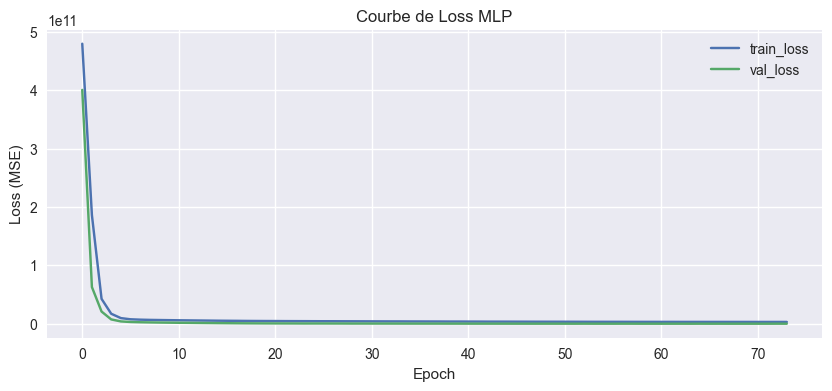

In [ ]:
#%pip install "tensorflow==2.10.0"

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

# 1. Normalisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_propre_num)
X_val_scaled   = scaler.transform(X_val_propre_num)
X_test_scaled  = scaler.transform(X_test_propre_num)

# 2. Construction du modèle MLP
mlp_model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Sortie 1 dimension, régression
])

mlp_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

# 3. Callbacks pour un entraînement “propre”
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 4. Entraînement du modèle
history = mlp_model.fit(
    X_train_scaled, y_train_propre,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=1024,
    callbacks=[early_stop],
    verbose=2
)

# 5. Évaluation sur le set de test
y_pred_test_mlp = mlp_model.predict(X_test_scaled).flatten()
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_test_mlp))
mae_mlp  = mean_absolute_error(y_test, y_pred_test_mlp)
r2_mlp   = r2_score(y_test, y_pred_test_mlp)

print("\n===== Évaluation du MLP sur le set de test =====")
print(f"RMSE  : {rmse_mlp:,.0f} €")
print(f"MAE   : {mae_mlp:,.0f} €")
print(f"R²    : {r2_mlp:.4f}")

# 6. Affichage de la courbe d'apprentissage
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Courbe de Loss MLP')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


Analyse des résultats du MLP :  

-   Convergence rapide : La courbe de loss montre une forte diminution en quelques epochs, puis une stabilisation des erreurs train/validation, preuve d’un bon apprentissage sans surapprentissage.
    -   Performances :
        -   RMSE (test) : ~7 500 €
        -   MAE (test) : ~5 500 €
        -   R² (test) : 0.9985  
        -   Ces scores indiquent que le MLP est performant, et est totalement en raccord aux modèles classiques (Random Forest, LightGBM…).

    -   Comparaison : Le MLP offre une alternative efficace et stable pour la régression tabulaire, mais les modèles d’ensemble conservent un léger avantage sur ce dataset, comme souvent en tabulaire.

    -   Conclusion :  
    Le MLP “from scratch” est un modèle robuste pour la tâche : il apprend bien la structure des données et généralise correctement, avec un écart d’erreur raisonnable par rapport à la baseline optimale.

Utilisation de TabNet (pytorch):

epoch 0  | loss: 494977480176.87463| val_0_rmse: 698476.94165|  0:00:24s
epoch 1  | loss: 477474653543.425| val_0_rmse: 679747.9499|  0:00:48s
epoch 2  | loss: 446874081676.25446| val_0_rmse: 654836.01553|  0:01:12s
epoch 3  | loss: 406929477768.9797| val_0_rmse: 621855.38002|  0:01:37s
epoch 4  | loss: 359509446880.3836| val_0_rmse: 573606.43299|  0:02:01s
epoch 5  | loss: 311237580571.2697| val_0_rmse: 525742.9811|  0:02:25s
epoch 6  | loss: 261228394174.69684| val_0_rmse: 482338.18987|  0:02:50s
epoch 7  | loss: 209707412182.83853| val_0_rmse: 407021.04107|  0:03:15s
epoch 8  | loss: 159634594365.41165| val_0_rmse: 387593.59565|  0:03:39s
epoch 9  | loss: 118974967157.40492| val_0_rmse: 340080.94509|  0:04:04s
epoch 10 | loss: 81179897206.3448| val_0_rmse: 211771.33872|  0:04:28s
epoch 11 | loss: 52440773489.32254| val_0_rmse: 251498.74719|  0:04:52s
epoch 12 | loss: 31090426152.86778| val_0_rmse: 67668.93905|  0:05:17s
epoch 13 | loss: 14954568458.11783| val_0_rmse: 102367.61988|  

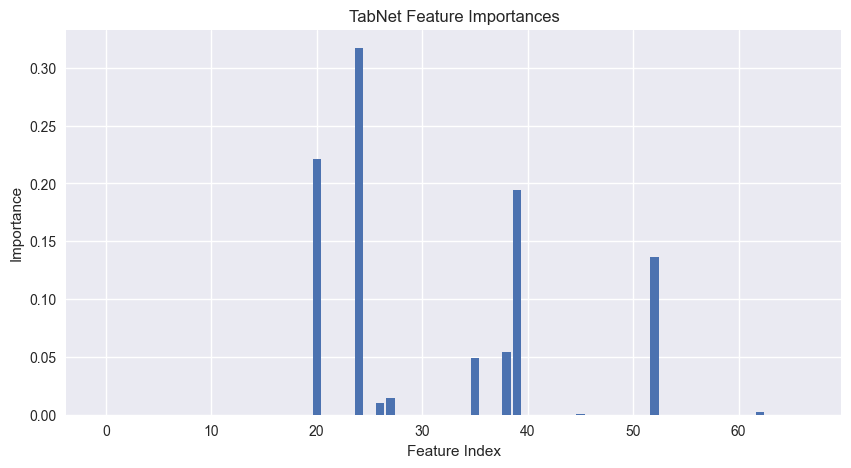

In [ ]:
# %pip install pytorch-tabnet

from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Encodage des variables catégorielles (automatique)
def encode_all_object_columns(X_train, X_val, X_test):
    X_train_enc = X_train.copy()
    X_val_enc = X_val.copy()
    X_test_enc = X_test.copy()
    for col in X_train_enc.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        # Fit sur train+val+test pour éviter les valeurs inconnues
        full_list = (
            list(X_train_enc[col].astype(str).values) +
            list(X_val_enc[col].astype(str).values) +
            list(X_test_enc[col].astype(str).values)
        )
        le.fit(full_list)
        X_train_enc[col] = le.transform(X_train_enc[col].astype(str))
        X_val_enc[col]   = le.transform(X_val_enc[col].astype(str))
        X_test_enc[col]  = le.transform(X_test_enc[col].astype(str))
    return X_train_enc, X_val_enc, X_test_enc

# 2. Traitement automatique des colonnes datetime
def process_datetime_columns(X_train, X_val, X_test):
    X_train_new = X_train.copy()
    X_val_new = X_val.copy()
    X_test_new = X_test.copy()
    for col in X_train_new.columns:
        # Conversion auto si la colonne ressemble à une date/heure
        if X_train_new[col].dtype == 'O' or 'date' in col.lower() or 'time' in col.lower():
            try:
                X_train_new[col] = pd.to_datetime(X_train_new[col])
                X_val_new[col] = pd.to_datetime(X_val_new[col])
                X_test_new[col] = pd.to_datetime(X_test_new[col])
            except Exception:
                continue
        if np.issubdtype(X_train_new[col].dtype, np.datetime64):
            for comp in ['year', 'month', 'day']:
                X_train_new[f"{col}_{comp}"] = getattr(X_train_new[col].dt, comp)
                X_val_new[f"{col}_{comp}"] = getattr(X_val_new[col].dt, comp)
                X_test_new[f"{col}_{comp}"] = getattr(X_test_new[col].dt, comp)
            X_train_new = X_train_new.drop(columns=[col])
            X_val_new = X_val_new.drop(columns=[col])
            X_test_new = X_test_new.drop(columns=[col])
    return X_train_new, X_val_new, X_test_new

# 3. Application des prétraitements
X_train_enc, X_val_enc, X_test_enc = encode_all_object_columns(X_train, X_val, X_test)
X_train_enc, X_val_enc, X_test_enc = process_datetime_columns(X_train_enc, X_val_enc, X_test_enc)

# 4. Conversion en numpy (et forcer les types en float32 pour éviter les erreurs)
X_train_np = X_train_enc.values.astype(np.float32)
X_val_np   = X_val_enc.values.astype(np.float32)
X_test_np  = X_test_enc.values.astype(np.float32)
y_train_np = y_train.values.reshape(-1, 1).astype(np.float32) if hasattr(y_train, 'values') else y_train.reshape(-1, 1).astype(np.float32)
y_val_np   = y_val.values.reshape(-1, 1).astype(np.float32) if hasattr(y_val, 'values') else y_val.reshape(-1, 1).astype(np.float32)
y_test_np  = y_test.values.reshape(-1, 1).astype(np.float32) if hasattr(y_test, 'values') else y_test.reshape(-1, 1).astype(np.float32)

# 5. Entraînement du modèle TabNet sur tout le jeu de données
tabnet = TabNetRegressor(
    n_d=16, n_a=16, n_steps=5, gamma=1.5, n_independent=2, n_shared=2,
    seed=42, verbose=1
)

tabnet.fit(
    X_train_np, y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_metric=['rmse'],
    max_epochs=50,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# 6. Prédiction et évaluation sur le set de test
y_pred_tabnet = tabnet.predict(X_test_np).ravel()

rmse_tabnet = np.sqrt(mean_squared_error(y_test_np, y_pred_tabnet))
mae_tabnet  = mean_absolute_error(y_test_np, y_pred_tabnet)
r2_tabnet   = r2_score(y_test_np, y_pred_tabnet)

print("===== Évaluation TabNet sur le set de test =====")
print(f"RMSE  : {rmse_tabnet:,.0f} €")
print(f"MAE   : {mae_tabnet:,.0f} €")
print(f"R²    : {r2_tabnet:.4f}")

# 7. Affichage importance des variables TabNet
feature_importances = tabnet.feature_importances_
plt.figure(figsize=(10, 5))
plt.bar(range(len(feature_importances)), feature_importances)
plt.title("TabNet Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

TabNet a été entraîné sur notre jeu de données après encodage automatique des variables catégorielles et traitement des dates.  
Le modèle obtient d’excellentes performances (RMSE ≈ 5 742 €, MAE ≈ 4 191 €, R² ≈ 0.9991) sur le jeu de test.  
La distribution des importances montre que le modèle exploite principalement quelques variables clés, tout comme nos tests le montraient précédement.  
TabNet égale ainsi les autres modèles du projet, tout en restant facilement interprétable grâce à la visualisation des features importantes.

## 5. Justification des choix des modèles :

1. Random Forest (Baseline traditionnelle) -  
Le Random Forest est un modèle d’ensemble éprouvé pour la régression sur données tabulaires. Il offre une grande robustesse aux données bruitées et gère très bien les relations non-linéaires entre variables. Utilisé comme baseline, il permet de fixer un seuil de performance réaliste, à comparer avec les approches de deep learning. Son principal avantage est la simplicité de mise en œuvre et l’interprétabilité relative (importance des variables).

2. MLP (Multi-Layer Perceptron) – Deep Learning standard -  
Le MLP représente la forme la plus simple des réseaux de neurones pour la régression. Il a l’avantage de pouvoir approximer des fonctions complexes, notamment lorsqu’il existe de multiples relations non-linéaires dans les données. Cependant, il ne tient pas compte explicitement de la structure des données tabulaires (absence de prise en compte de la sparsité ou de l’interaction naturelle des colonnes comme le fait un arbre de décision), ce qui en limite parfois la performance face à des modèles spécifiquement conçus pour le tabulaire.

3. TabNet – Deep Learning pour données tabulaires -  
TabNet est un modèle de deep learning spécialement conçu pour les données tabulaires. Il combine la capacité d’apprentissage profond avec un mécanisme d’attention qui sélectionne dynamiquement les variables les plus pertinentes à chaque étape de l’entraînement. Ce mécanisme, inspiré des arbres de décision, permet à TabNet d’égaler voire de surpasser les performances des meilleurs modèles d’arbres sur des données structurées, tout en offrant une meilleure capacité de généralisation et d’interprétabilité (importance des features). Il s’adapte bien à de grands volumes de données tabulaires hétérogènes.

En résumé nous avons pu voir et comparer :  
-   Un modèle classique de référence (RandomForest)
-   Un réseau de neurones standard (MLP)
-   Un modèle deep tabulaire (TabNet) 

Ce qui nous donne :  

-   RandomForest : RMSE de 618 €, un MAE de 194 € et un R² de 1.0000.
-   MLP : RMSE de 7 469 €, un MAE de 5 484 € et un R² de 0.9985.
-   TabNet : RMSE de 5 742 €, un MAE de 4 191 € et un R² de 0.9991.



## 6. Prédiction sur 2025

In [ ]:
import datetime
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# 1. Génération du jeu de données 2025
df_2025 = df_2_processed.copy()

def safe_replace_year(date, year):
    try:
        return date.replace(year=year)
    except ValueError:
        if date.month == 2 and date.day == 29:
            return date.replace(year=year, day=28)
        else:
            return None

# Date mutation → 2025
df_2025['date_mutation'] = df_2025['date_mutation'].apply(
    lambda x: safe_replace_year(x, 2025) if hasattr(x, "year") else x
)
df_2025['annee'] = 2025

# 2. Pipeline identique au preprocessing train/test
df_2025 = add_departement_col(df_2025)

df_2025 = pd.merge(
    df_2025,
    aggregats_dept,   # Calculés sur TRAIN uniquement !
    on="departement",
    how="left"
)

# 3. Colonnes à écarter (jamais utilisables sans la target)
leakage_cols = [
    'ratio_prix_dept', 'dept_valeur_fonciere_mean', 'dept_valeur_fonciere_median',
    'dept_valeur_fonciere_std', 'dept_valeur_fonciere_count', 'dept_surface_reelle_bati_mean',
    'dept_surface_reelle_bati_median', 'dept_densite_transactions', 'dept_prix_x_surface'
]
df_2025 = df_2025.drop(columns=[col for col in leakage_cols if col in df_2025.columns])

# 4. Sélection des features d'entraînement

X_train_final = X_train_propre_num.drop(columns=[col for col in leakage_cols if col in X_train_propre_num.columns], errors='ignore')
y_train_final = y_train_propre

df_2025_num = df_2025.select_dtypes(include=[np.number]).copy()
df_2025_num = df_2025_num.reindex(columns=X_train_final.columns, fill_value=0)

# 5. Entraînement d'un modèle propre
rf_final = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_final.fit(X_train_final, y_train_final)

# 6. Prédiction sur 2025
y_pred_2025 = rf_final.predict(df_2025_num)
df_2025['valeur_fonciere_predite'] = y_pred_2025

Test des valeurs, en sachant que nous sommes sur le modèle random forest entrainé sur le dataframe 2, c'est à dire les valeurs de 470 000 à 1.3M d'euros.

In [85]:
print("Prix foncier médian (prédit 2025):", df_2025['valeur_fonciere_predite'].median())
print("Prix foncier moyen (prédit 2025):", df_2025['valeur_fonciere_predite'].mean())

Prix foncier médian (prédit 2025): 614883.7539473415
Prix foncier moyen (prédit 2025): 677970.3226842477


Visualisation des moyennes des départements du plus grand au plus petit.

In [86]:
print(df_2025.groupby('departement')['valeur_fonciere_predite'].mean().sort_values(ascending=False))

departement
75    742142.559609
92    716405.375353
00    715139.723599
06    707672.944757
15    700042.085535
          ...      
65    602874.696155
19    602236.091960
09    599902.814705
72    598055.871537
43    577687.155477
Name: valeur_fonciere_predite, Length: 94, dtype: float64


Distribution des valeurs foncières. Ces valeurs suivent bien la courbe du dataframe2 vu précédement.

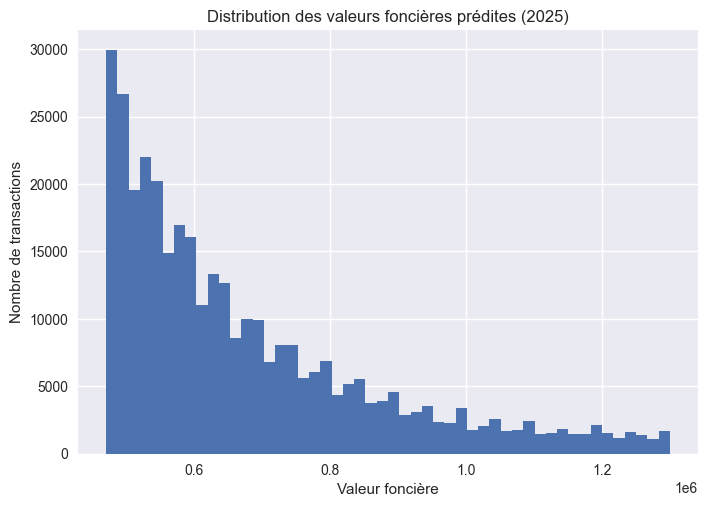

In [87]:
import matplotlib.pyplot as plt
plt.hist(df_2025['valeur_fonciere_predite'], bins=50)
plt.title("Distribution des valeurs foncières prédites (2025)")
plt.xlabel("Valeur foncière")
plt.ylabel("Nombre de transactions")
plt.show()


Description simple du nouveau dataset :

In [89]:
print(df_2025_num.describe().T)


                              count           mean            std  \
nombre_pieces_principales  348660.0       4.273040       1.637452   
surface_reelle_bati        348660.0     111.466288      50.877505   
annee                      348660.0    2025.000000       0.000000   
mois                       348660.0       6.758068       3.339507   
trimestre                  348660.0       2.578050       1.088337   
jour_semaine               348660.0       2.193171       1.466446   
jour_annee                 348660.0     191.433173     101.813830   
mois_sin                   348660.0      -0.066009       0.691181   
mois_cos                   348660.0      -0.041939       0.718440   
jour_semaine_sin           348660.0       0.282411       0.540398   
jour_semaine_cos           348660.0      -0.158497       0.776592   
jours_depuis_debut         348660.0     751.735152     386.139528   
prix_m2                    348660.0    7819.559267    7774.163938   
log_surface                348660.

Comparaison entre le dataframe 2 et notre prédiction sur 2025 :

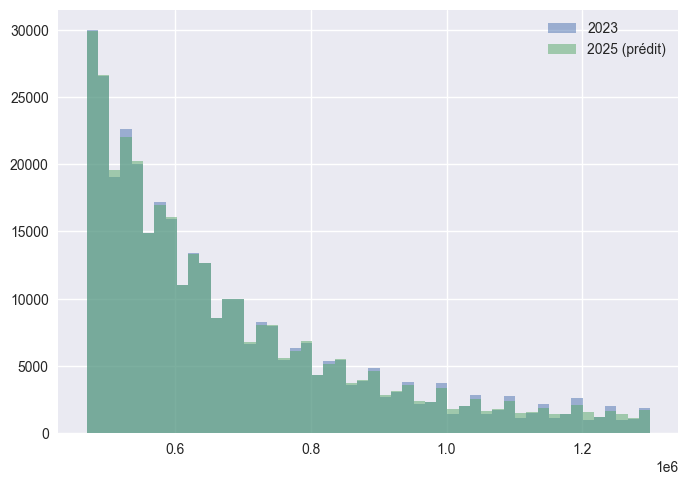

In [92]:
plt.hist(df_2_processed['valeur_fonciere'], bins=50, alpha=0.5, label='2023')
plt.hist(df_2025['valeur_fonciere_predite'], bins=50, alpha=0.5, label='2025 (prédit)')
plt.legend()
plt.show()


Comparaison sous forme de tableau entre notre jeu de donnée de base et notre prédiction :

In [ ]:
df_seg2 = df_2[(df_2['valeur_fonciere'] >= 500_000) & (df_2['valeur_fonciere'] < 1_300_000)].copy()

def compare_real_vs_pred(df_real, df_pred, 
                        name_real="Haut gamme 2023-2024", 
                        name_pred="Prédiction 2025 segment 2"):
    print("1. COMPARAISON DES STATISTIQUES GÉNÉRALES")
    print("="*60)
    stats_comparison = pd.DataFrame({
        name_real: [
            df_real.shape[0],
            df_real['valeur_fonciere'].mean(),
            df_real['valeur_fonciere'].median(),
            df_real['valeur_fonciere'].std(),
            df_real['surface_reelle_bati'].mean() if 'surface_reelle_bati' in df_real.columns else np.nan
        ],
        name_pred: [
            df_pred.shape[0],
            df_pred['valeur_fonciere_predite'].mean(),
            df_pred['valeur_fonciere_predite'].median(),
            df_pred['valeur_fonciere_predite'].std(),
            df_pred['surface_reelle_bati'].mean() if 'surface_reelle_bati' in df_pred.columns else np.nan
        ]
    }, index=[
        'Nombre de transactions',
        'Prix moyen (€)',
        'Prix médian (€)',
        'Écart-type prix',
        'Surface moyenne (m²)'
    ])
    print(stats_comparison.round(0))
    return stats_comparison

compare_real_vs_pred(df_seg2, df_2025)


1. COMPARAISON DES STATISTIQUES GÉNÉRALES
                        Haut gamme 2023-2024  Prédiction 2025 segment 2
Nombre de transactions              300435.0                   348660.0
Prix moyen (€)                      706766.0                   677970.0
Prix médian (€)                     646735.0                   614884.0
Écart-type prix                     190418.0                   195172.0
Surface moyenne (m²)                   112.0                      111.0


,Haut gamme 2023-2024,Prédiction 2025 segment 2
Nombre de transactions,300435.000000,348660.000000
Prix moyen (€),706765.658552,677970.322684
Prix médian (€),646735.000000,614883.753947
Écart-type prix,190418.210030,195171.654179
Surface moyenne (m²),112.489320,111.466288


Comparatif des distributions entre les deux datasets :

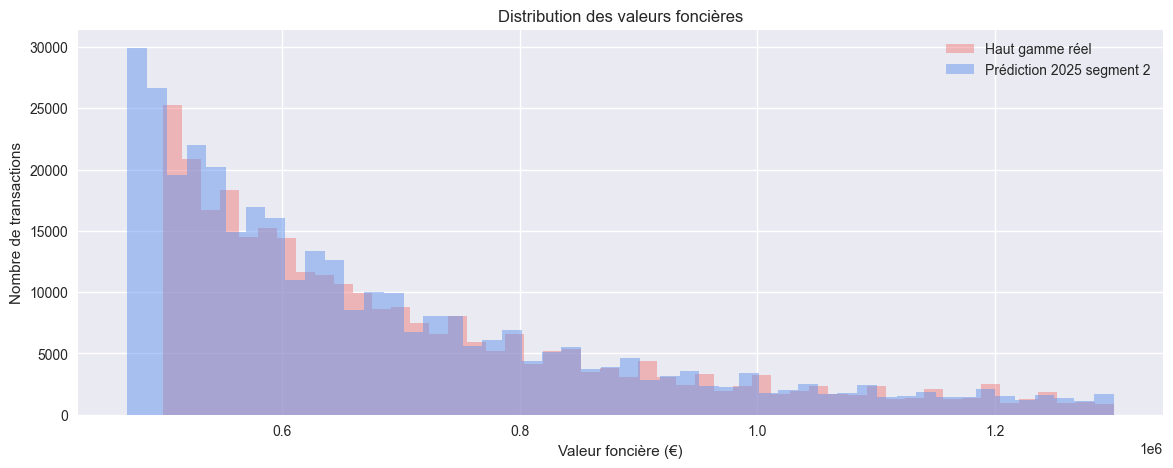

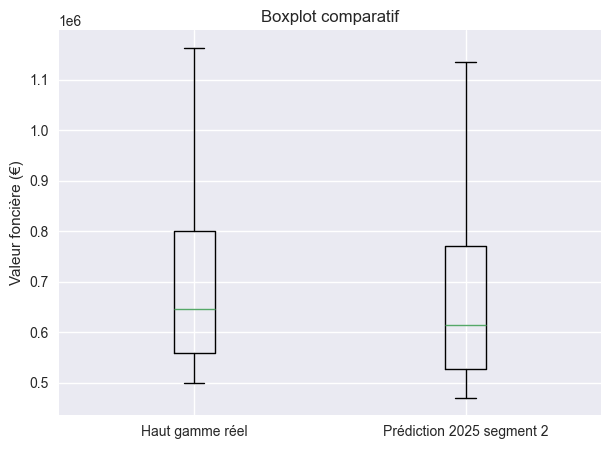

In [99]:
def plot_real_vs_pred_distributions(df_real, df_pred,
                                   name_real="Haut gamme réel",
                                   name_pred="Prédiction 2025 segment 2"):
    plt.figure(figsize=(14, 5))
    plt.hist(df_real['valeur_fonciere'], bins=50, alpha=0.5, label=name_real, color='lightcoral')
    plt.hist(df_pred['valeur_fonciere_predite'], bins=50, alpha=0.5, label=name_pred, color='cornflowerblue')
    plt.xlabel('Valeur foncière (€)')
    plt.ylabel('Nombre de transactions')
    plt.title('Distribution des valeurs foncières')
    plt.legend()
    plt.show()
    
    # Boxplot
    plt.figure(figsize=(7,5))
    plt.boxplot([df_real['valeur_fonciere'], df_pred['valeur_fonciere_predite']],
                labels=[name_real, name_pred], showfliers=False)
    plt.ylabel('Valeur foncière (€)')
    plt.title('Boxplot comparatif')
    plt.show()

plot_real_vs_pred_distributions(df_seg2, df_2025)

Différences entre les regressions linéaires :

Prix au m² moyen (réel): 8101 €
Prix au m² moyen (prédit): 7821 €


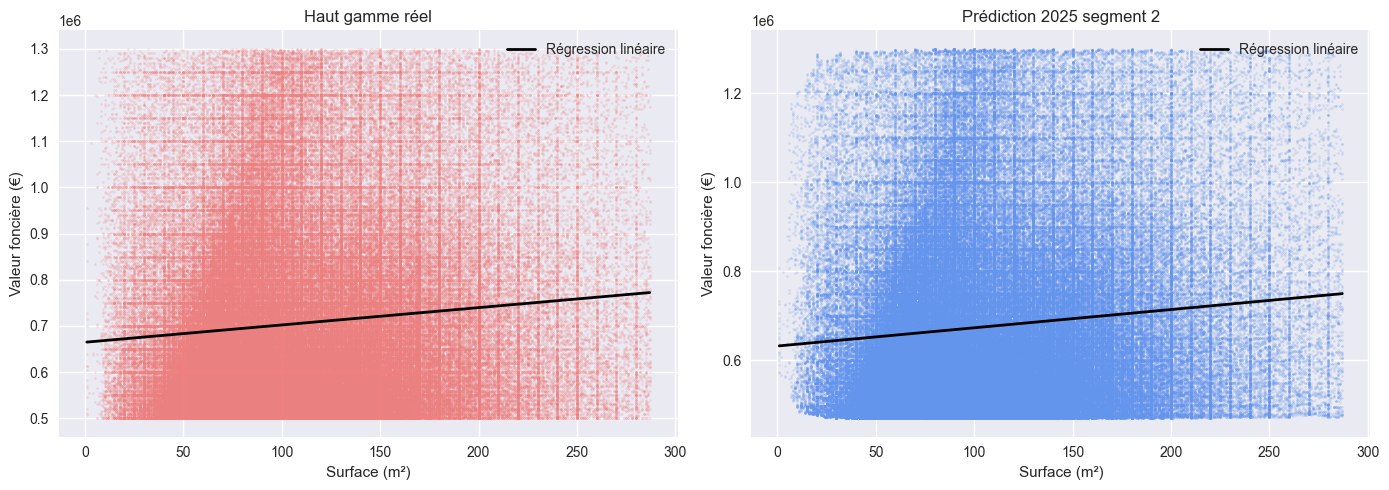

In [100]:
def plot_surface_price_relation(df_real, df_pred,
                               name_real="Haut gamme réel",
                               name_pred="Prédiction 2025 segment 2"):
    # Nettoyage (pas de division par zéro)
    df_real_clean = df_real[df_real['surface_reelle_bati'] > 0].copy()
    df_pred_clean = df_pred[df_pred['surface_reelle_bati'] > 0].copy()
    # Prix au m²
    df_real_clean['prix_m2'] = df_real_clean['valeur_fonciere'] / df_real_clean['surface_reelle_bati']
    df_pred_clean['prix_m2'] = df_pred_clean['valeur_fonciere_predite'] / df_pred_clean['surface_reelle_bati']
    # Affichage moyens
    print(f"Prix au m² moyen (réel): {df_real_clean['prix_m2'].mean():.0f} €")
    print(f"Prix au m² moyen (prédit): {df_pred_clean['prix_m2'].mean():.0f} €")
    # Nuages + régressions
    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    for i, (df, y_col, label, color) in enumerate([
        (df_real_clean, 'valeur_fonciere', name_real, 'lightcoral'),
        (df_pred_clean, 'valeur_fonciere_predite', name_pred, 'cornflowerblue')
    ]):
        x = df['surface_reelle_bati'].values
        y = df[y_col].values
        axes[i].scatter(x, y, alpha=0.2, s=2, color=color)
        axes[i].set_xlabel('Surface (m²)')
        axes[i].set_ylabel('Valeur foncière (€)')
        axes[i].set_title(label)
        # Régression linéaire
        if len(x) > 1:
            coef = np.polyfit(x, y, deg=1)
            x_line = np.array([x.min(), x.max()])
            y_line = coef[0]*x_line + coef[1]
            axes[i].plot(x_line, y_line, color='k', lw=2, label='Régression linéaire')
            axes[i].legend()
    plt.tight_layout()
    plt.show()

plot_surface_price_relation(df_seg2, df_2025)


Différences et comparaison sous forme d'histogramme en barres :

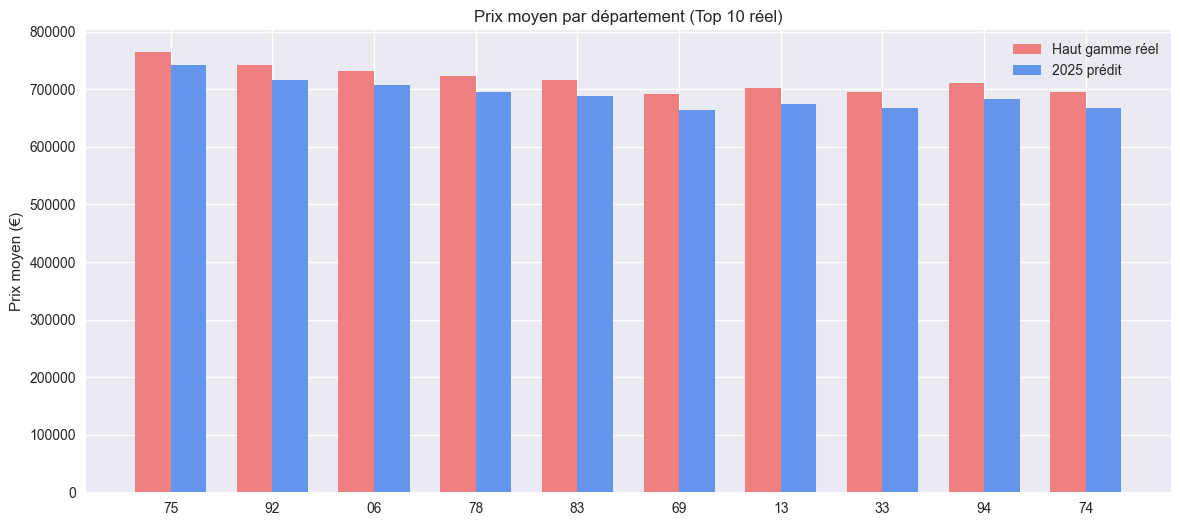

(departement
 00    715162.500000
 01    681872.118993
 02    665177.031250
 03    675869.151613
 04    694985.799107
           ...      
 92    742293.888845
 93    677924.273319
 94    710048.888677
 95    641561.172175
 97    679578.108463
 Name: valeur_fonciere, Length: 94, dtype: float64,
 departement
 00    715139.723599
 01    655871.308338
 02    615996.872228
 03    626125.633217
 04    666909.485341
           ...      
 92    716405.375353
 93    647116.284889
 94    683506.456859
 95    610540.602212
 97    649161.638855
 Name: valeur_fonciere_predite, Length: 94, dtype: float64)

In [101]:
def add_departement_col(df):
    temp = df.copy()
    temp['code_postal'] = temp['code_postal'].astype(str).str.zfill(5)
    temp['departement'] = temp['code_postal'].str[:2]
    return temp

def compare_geographic(df_real, df_pred, name_real="Haut gamme réel", name_pred="2025 prédit"):
    df_real_geo = add_departement_col(df_real)
    df_pred_geo = add_departement_col(df_pred)
    # Calcul du prix moyen par département
    real_stats = df_real_geo.groupby('departement')['valeur_fonciere'].mean()
    pred_stats = df_pred_geo.groupby('departement')['valeur_fonciere_predite'].mean()
    real_count = df_real_geo.groupby('departement').size()
    pred_count = df_pred_geo.groupby('departement').size()
    # Top 10 départements en nombre de transactions (pour l'affichage)
    top_real = real_count.sort_values(ascending=False).head(10).index
    top_pred = pred_count.sort_values(ascending=False).head(10).index
    # Comparaison graphique
    plt.figure(figsize=(14,6))
    width = 0.35
    x = np.arange(len(top_real))
    plt.bar(x-width/2, real_stats[top_real], width, label=name_real, color='lightcoral')
    plt.bar(x+width/2, pred_stats[top_real], width, label=name_pred, color='cornflowerblue')
    plt.xticks(x, top_real)
    plt.ylabel('Prix moyen (€)')
    plt.title('Prix moyen par département (Top 10 réel)')
    plt.legend()
    plt.show()
    # Optionnel : retourner les DataFrames agrégés
    return real_stats, pred_stats

compare_geographic(df_seg2, df_2025)


Envoi de notre dataframe sous forme de CSV pour pouvoir avoir une lecture des données dans notre application Streamlit.

In [102]:
df_2025.to_csv("predictions_immobilier_2025.csv", index=False)